# phase_locking_to_hpc2.ipynb

In [2]:
# General
import sys
import os
import glob
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Neuro
import mne
from ptsa.data.TimeSeriesX import TimeSeries 
#import neurodsp

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
from formatting import *
from helper_funcs import *
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
import lfp_synchrony
from eeg_plotting import plot_trace, plot_trace2

# Colors
colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

proj_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta'

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ptsa/data/TimeSeriesX.py:7: DeprecationWarning: importing from ptsa.data.TimeSeries is deprecated; import from ptsa.data.timeseries instead
  DeprecationWarning)


In [3]:
def spike_triggered_lfp(info, 
                        subj_df, 
                        time_win=2, 
                        sampling_rate=2000, 
                        sub_mean=True,
                        create_spread=True,
                        spike_shift=0,
                        step=1):
    """Return the spike-triggered LFP for a given unit-to-region connection."""
    lfp_chans = [str(iChan+1) for iChan in info.lfp_chan_inds]
    cut_inds = int(sampling_rate*time_win)
    
    # Load LFP.
    _, lfp_preproc = manning_analysis.process_lfp(info.subj_sess, 
                                                  subj_df,
                                                  chans=lfp_chans,
                                                  resampling_rate=sampling_rate,
                                                  notch_freqs=[60, 120])
    lfp_preproc = lfp_preproc.data.astype(np.float32)
    
    # Load spikes.
    spike_inds, n_timepoints = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/spike_inds', 
                                                            'spike_inds-{}Hz-{}-unit{}.pkl'
                                                            .format(sampling_rate, info.subj_sess, info.unit)))
    if spike_shift:
        spike_inds = phase_locking.shift_spike_inds(spike_inds, n_timepoints, spike_shift)
    spike_inds = np.unique(spike_inds[(spike_inds>cut_inds) & (spike_inds<(n_timepoints-(cut_inds+1)))])
    
    st_lfp = []
    for iChan in range(len(lfp_chans)):
        st_lfp_ = []
        for spike_ind in spike_inds:
            st_lfp_.append(lfp_preproc[iChan, spike_ind-cut_inds:spike_ind+cut_inds+1][::step])
        st_lfp.append(st_lfp_)
    st_lfp = np.mean(st_lfp, axis=1) * 1e6 # chan x time; mean across spikes; converting V to μV
    
    if sub_mean:
        st_lfp = st_lfp - np.expand_dims(np.mean(st_lfp, axis=1), axis=1)
    
    if create_spread:
        offsets = np.arange(st_lfp.shape[0]) * 1.2 * (np.percentile(st_lfp, 99) - np.percentile(st_lfp, 1))
        st_lfp = (st_lfp + np.expand_dims(offsets, axis=-1))
        
    return [st_lfp, offsets]

def fmt_str(x, unit_roi=True):
    if unit_roi:
        return '{} {}      {} {}'.format(x.unit_hem, x.unit_roi.upper(), x.lfp_hem, x.lfp_roi2.upper())
        #return '{} {}$\longleftrightarrow${} {}'.format(x.unit_hem, x.unit_roi.upper(), x.lfp_hem, x.lfp_roi2.upper())
    else:
        return '{} {}      {} {}'.format(x.unit_hem, x.unit_roi2.upper(), x.lfp_hem, x.lfp_roi2.upper())
        #return '{} {}$\longleftrightarrow${} {}'.format(x.unit_hem, x.unit_roi2.upper(), x.lfp_hem, x.lfp_roi2.upper())
    
def update_pl_freq_time(info,
                        t0=200,
                        thresh=2,
                        time_win=2,
                        sampling_rate=2000):
    """Return the new phase-locking frequency and time.
    
    (Given the cross-correlated phase-locking strength matrix.)
    
    Finds the frequency and time that correspond to the maximum 
    phase-locking strength within the "phase-locking region,"
    defined as all phase-locking strengths>thresh that are
    continuous with the zero offset time.
    
    Returns
    -------
    new_pl_params : OrderedDict
        Contains the new phase-locking strength, frequency, and time,
        along with the duration and number of cycles that the neuron
        was phase-locked (contiguous Z>thresh).
    updated : bool
        Whether or not new phase-locking values were chosen
        vs. the existing ones.
    """
    # Get starting params.
    updated = False
    time_steps = np.arange(-time_win*sampling_rate, time_win*sampling_rate+1, sampling_rate*0.01, dtype=int)
    time_steps_ms = (time_steps / sampling_rate) * 1000
    freqs = np.array([2**((i/2) - 1) for i in range(16)])
    tl_mrls_z = info['tl_mrls_z']
    locked_mrl = info['pl_strength']
    locked_freq = info['pl_freq']
    locked_time = info['pl_time_shift']
    locked_duration = 0
    
    # Find all phase-locking strengths > thresh,
    # and iterate over frequencies for which
    # the zero offset shift is > thresh.
    ma = tl_mrls_z > thresh
    ma_inds = np.array(list(np.where(ma))).T
    for iFreq in ma_inds[ma_inds[:, 1]==t0][:, 0]: 
        ma_inds_ = list(ma_inds[ma_inds[:, 0]==iFreq, 1])
        zero_ind = ma_inds_.index(t0)
        keep_inds = [t0]
        
        # Negative shifts.
        offset = 1
        while offset < len(ma_inds_)-1:
            if t0 - offset not in ma_inds_:
                break
            else:
                keep_inds.append(t0 - offset)
            offset += 1
        
        # Positive shifts.
        offset = 1
        while offset < len(ma_inds_)-1:
            if t0 + offset not in ma_inds_:
                break
            else:
                keep_inds.append(t0 + offset)
            offset += 1
        
        max_mrl = tl_mrls_z[iFreq, keep_inds].max()
        max_freq = iFreq
        max_time = keep_inds[tl_mrls_z[iFreq, keep_inds].argmax()]
        max_duration = len(keep_inds) * 10 # converting time-shift steps to ms
        max_cycles = freqs[iFreq] * (max_duration/1000.0)
        
        if max_mrl > locked_mrl:
            locked_mrl = max_mrl
            locked_freq = max_freq
            locked_time = time_steps_ms[max_time]
            locked_duration = max_duration
            locked_cycles = max_cycles
            updated = True
        elif max_mrl == locked_mrl:
            locked_duration = max_duration
            locked_cycles = max_cycles
        
    new_pl_params = od([('pl_strength', locked_mrl), 
                        ('pl_freq', locked_freq), 
                        ('pl_time_shift', locked_time),
                        ('pl_duration', locked_duration),
                        ('pl_cycles', locked_cycles)])
    
    return new_pl_params, updated

In [4]:
# Inches for 1, 1.5, and 2 column width.
colws = od([(1, 3.34646), (1.5, 4.48819), (2, 6.85039)])

In [9]:
# Get session info.
freqs = np.array([2**((i/2) - 1) for i in range(16)])
freq_ind_2hz = int(np.where(freqs==2)[0])
freq_ind_8hz = int(np.where(freqs==8)[0])

subj_df = phase_locking.get_subj_df()
subj_df.insert(4, 'chan_ind', subj_df.chan.apply(lambda x: int(x)-1))
# subjs = list(np.unique(hpc_pl_df['subj']))
# subj_df = subj_df.query("(subj=={})".format(subjs))['subj'].copy()

# Public data release

In [131]:
if False:
    cols = ['subj', 'sess', 'subj_sess', 'chan', 'location']
    df_ = subj_df.query("(subj=={})".format(subjs))[cols].copy()
    print(df_.shape)
    fname = '/home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/lfps/channel_locations.csv'
    df_.to_csv(fname, index=False)
    print('Saved {}'.format(fname))

(2696, 4)
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/lfps/channel_locations.csv


In [59]:
print(len(pl_df), 
      len(pl_df.query("(subj=={})".format(subjs))), 
      len(pl_df.query("(subj=={}) & (edge=='ctx-hpc')".format(subjs))),
      len(pl_df.query("(subj=={}) & (edge=='ctx-hpc') & (sig_z_fdr==True)".format(subjs))),
      len(pl_df.query("(subj=={}) & (edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True)".format(subjs))),
      len(pl_df.query("(subj=={}) & (edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True) & ({}<=locked_freq_ind_z<={})".format(subjs, freq_ind_2hz, freq_ind_8hz))))

13793 12953 2405 478 362 258


In [94]:
# Copy over downsampled (2000Hz) LFP data to the public release dir
import shutil
start_time = time()

dsamp_output_d = '/home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/crosselec_phase_locking/lfps/dsamp_2000hz'
files_copied = 0
for idx, row in subj_df.query("(subj=={})".format(subjs)).iterrows():
    input_chan_f = row['raw_lfp_file']
    output_chan_f = os.path.join(dsamp_output_d, '{}_{}'.format(row['subj_sess'], os.path.basename(input_chan_f)))
    _ = shutil.copy(input_chan_f, output_chan_f)
    files_copied += 1
    
print('Copied {} files'.format(files_copied))
print('Done in {:.2f} secs'.format(time() - start_time))

Copied 2696 files
Done in 172.75 secs


In [96]:
# Copy over raw LFP data to the public release dir
start_time = time()

raw_output_d = '/home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/crosselec_phase_locking/lfps/raw_lfps'
files_copied = 0
raw_lfp_files = []
missing_files = []
for idx, row in subj_df.query("(subj=={})".format(subjs)).iterrows():
    input_chan_f = row['raw_lfp_file']
    f = os.path.basename(input_chan_f)
    chan_num = int(f[f.find('.')+1:])
    input_raw_lfp_f = os.path.join(os.path.dirname(os.path.dirname(input_chan_f)), 'cheetah', 'CSC{}.Ncs'.format(chan_num))
    if os.path.exists(input_raw_lfp_f):
        output_raw_lfp_f = os.path.join(raw_output_d, '{}_{}'.format(row['subj_sess'], os.path.basename(input_raw_lfp_f)))
        raw_lfp_files.append({'input': input_raw_lfp_f,
                              'output': output_raw_lfp_f})
        shutil.copy(input_raw_lfp_f, output_raw_lfp_f)
        files_copied += 1
    else:
        missing_files.append(input_raw_lfp_f)

print('{} missing files'.format(len(missing_files)))
print('Copied {} files'.format(files_copied))
print('Done in {:.2f} secs'.format(time() - start_time))

0 missing files
Copied 2696 files
Done in 1118.04 secs


In [133]:
# Save the pl_df for public release dir
cols = ['subj', 'sess', 'subj_sess', 'subj_sess_unit', 'subj_unit_chan', 'unit',
        'unit_chan_ind', 'unit_hemroi', 'unit_hem', 'unit_roi', 'unit_roi2', 'unit_roi3',
        'spike_inds', 'unit_nspikes', 'unit_fr', 
        'lfp_chan_inds', 'lfp_hemroi', 'lfp_hem', 'lfp_roi', 'lfp_roi2',
        'same_chan', 'same_hemroi', 'same_hem', 'edge',
        'tl_mrls', 'tl_mrls_z', 'bs_mrls', 'bs_mrls_z', 'mrls_z',
        'locked_freq_ind_z', 'locked_mrl_z', 'bs_ind_z', 'bs_pval_z', 'sig_z', 'sig_z_fdr',
        'tl_locked_freq_z', 'tl_locked_time_z', 'tl_locked_mrl_z', 'pref_phase', 'phase_offsets']
d = '/home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/phase_locking_results/unit_to_region'
fname = 'phase_locking_dataframe-{}_unit_to_region_pairs-16log10freqs_0.5_to_90.5Hz.pkl'
df_ = pl_df.query("(subj=={})".format(subjs))[cols].copy()
dio.save_pickle(df_, os.path.join(d, fname.format(len(df_))))

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/phase_locking_results/unit_to_region/phase_locking_dataframe-12953_unit_to_region_pairs-16log10freqs_0.5_to_90.5Hz.pkl


# Setup

In [11]:
# Load phase-locking stats.
start_time = time()

if True:
    # Load the unit-to-region phase-locking DataFrame.
    pl_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region'
    pl_fname = os.path.join(pl_dir, 'all_phase_locking_stats-14026_unit_to_region_pairs-2000Hz-notch60_120Hz-5cycles-16log10freqs_0.5_to_90.5Hz.pkl')
    pl_df = phase_locking.load_pl_df(pl_fname)
else:
    pl_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region'
    pl_files = glob(os.path.join(pl_dir, 'phase_locking_stats*.pkl'))
    pl_df = pd.DataFrame(dio.open_pickle(pl_files[0])).T
    for f in pl_files[1:]:
        pl_df = pl_df.append(dio.open_pickle(f))
    pl_df.reset_index(drop=True, inplace=True)

print(pl_df.shape, pl_df.query("(edge=='ctx-hpc')").shape)

print('Done in {:.2f} secs'.format(time() - start_time))

(13793, 56) (2405, 56)
Done in 13.17 secs


In [916]:
# # Update phase-locking parameters.
# start_time = time()

# n_updated = {'sig': 0, 'nsig': 0}
# for idx, row in pl_df.iterrows():
#     new_pl_params, updated = phase_locking.update_pl_freq_time(pl_df.loc[idx])
    
#     if updated:
#         for key in new_pl_params.keys():
#             pl_df.at[idx, key] = new_pl_params[key]
        
#         if row['sig_z_fdr']:
#             n_updated['sig'] += 1
#         else:
#             n_updated['nsig'] += 1
    
# pl_df['pl_latency'] = np.abs(pl_df['pl_time_shift'])
    
# print('{}/{} ({:.1f}%) significant phase-locking parameters updated'.format(n_updated['sig'], len(pl_df.loc[pl_df['sig_z_fdr']==True]), 
#                                                                             100 * n_updated['sig'] / len(pl_df.loc[pl_df['sig_z_fdr']==True])), end='\n\n')
# print('{}/{} ({:.1f}%) insignificant phase-locking parameters updated'.format(n_updated['nsig'], len(pl_df.loc[pl_df['sig_z_fdr']==False]), 
#                                                                               100 * n_updated['sig'] / len(pl_df.loc[pl_df['sig_z_fdr']==False])), end='\n\n')

# print('Done in {:.2f} secs'.format(time() - start_time))

430/3113 (13.8%) significant phase-locking parameters updated

477/10680 (4.0%) insignificant phase-locking parameters updated

Done in 27.32 secs


In [12]:
# Get dataframe subset for just the significant ctx-hpc connections
files = glob('/home1/dscho/projects/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_for_power/sig/*.pkl')
cols = dio.open_pickle(files[0]).index.tolist()
hpc_pl_df = pd.DataFrame([dio.open_pickle(f) for f in files], columns=cols)
hpc_pl_df.shape

(362, 57)

In [1218]:
# For all cortical neurons that are phase-locked to HPC LFP,
# get the preferred phase and phase offset for each spike when
# referenced to the local LFP at the HPC LFP preferred frequency.
# This info is appended to the unit-to-region phase-locking Series 
# and saved to /.../unit_to_region_for_power/sig
# and /.../unit_to_region_for_power/nsig (for insignificant comparisons)
start_time = time()

overwrite = False

hpc_local_pl_df = pl_df.query("(edge=='hpc-local') & (sig_z_fdr==True)").reset_index(drop=True).copy()
print('Before:', circstats.circmoment(hpc_local_pl_df['pref_phase_tl_locked_time_freq_z']))

n_saved = 0
for idx, hpc_row in hpc_local_pl_df.iterrows():
    subj_sess = hpc_row.subj_sess
    unit = hpc_row.unit
    lfp_roi = hpc_row.lfp_hemroi
    hpc_locked_iFreq = hpc_row.pl_freq
    hpc_locked_iTimeLag = int(-hpc_row.pl_time_shift * 2)
    
    # Update phase offsets.
    pref_phase, phase_offsets = phase_locking.phase_offsets_by_spike(hpc_row, hpc_locked_iFreq, hpc_locked_iTimeLag)
    hpc_local_pl_df.at[idx, 'pref_phase_tl_locked_time_freq_z'] = pref_phase
    hpc_local_pl_df.at[idx, 'phase_offsets_tl_locked_time_freq_z'] = phase_offsets
    
    # Save
    fname = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region',
                         'phase_locking_stats-{}-unit_{}-lfp_{}-2000Hz-notch60_120Hz-5cycles-16log10freqs_0.5_to_90.5Hz.pkl'
                         .format(subj_sess, unit, lfp_roi))
    if (overwrite) or (not os.path.exists(fname)):
        hpc_row['pref_phase_tl_locked_time_freq_z'] = pref_phase
        hpc_row['phase_offsets_tl_locked_time_freq_z'] = phase_offsets
        dio.save_pickle(hpc_row, fname, verbose=False)
        n_saved += 1
print('Saved {}/{} files'.format(n_saved, len(hpc_local_pl_df)))

print('After:', circstats.circmoment(hpc_local_pl_df['pref_phase_tl_locked_time_freq_z']))

print('Done in {:.2f} secs'.format(time() - start_time))

Before: (-3.022519120500042, 0.3083281419257666)
Saved 0/307 files
After: (-2.992305092904871, 0.48707789290900244)
Done in 15.34 secs


In [16]:
freq_ind_1hz = int(np.where(freqs==1)[0])

n_theta_sig = len(hpc_pl_df.query("({}<=locked_freq_ind_z<={})".format(freq_ind_1hz, freq_ind_8hz)))
n_sig = len(hpc_pl_df)
print('{}/{} ({:.1f}%) of sig. phase-locking cortical neurons are preferentially phase-locked from 1-8Hz'
      .format(n_theta_sig, n_sig, 100 * n_theta_sig/n_sig))
display(hpc_pl_df
 .query("({}<=locked_freq_ind_z<={})".format(freq_ind_1hz, freq_ind_8hz))
 .groupby('unit_roi3')
 .agg({'unit': len, 
       'pref_phase': lambda x: circstats.circmoment(x)}))

n_theta_sig = len(hpc_pl_df.query("({}<=locked_freq_ind_z<={})".format(freq_ind_2hz, freq_ind_8hz)))
n_sig = len(hpc_pl_df)
print('{}/{} ({:.1f}%) of sig. phase-locking cortical neurons are preferentially phase-locked from 2-8Hz'
      .format(n_theta_sig, n_sig, 100 * n_theta_sig/n_sig))
display(hpc_pl_df
 .query("({}<=locked_freq_ind_z<={})".format(freq_ind_2hz, freq_ind_8hz))
 .groupby('unit_roi3')
 .agg({'unit': len, 
       'pref_phase': lambda x: circstats.circmoment(x)}))

317/362 (87.6%) of sig. phase-locking cortical neurons are preferentially phase-locked from 1-8Hz


unit                                  pref_phase
unit_roi3                                                  
amy         148    (3.106718476252636, 0.07528083980272801)
ctx          81  (2.1532697338216065, 0.055311199292406805)
ec           88   (0.7506997104082006, 0.12035133082474242)

258/362 (71.3%) of sig. phase-locking cortical neurons are preferentially phase-locked from 2-8Hz


unit                                 pref_phase
unit_roi3                                                 
amy         114   (2.256853813468769, 0.11311464471471305)
ctx          67  (1.1805519973743432, 0.09360517016032197)
ec           77  (0.6387967925865705, 0.13829680595927754)

In [8]:
def polar_histogram(phases, bins=16):
    """Count the number of phases in each bin.
    
    Parameters
    ----------
    phases : np.ndarray
        Vector of phase values in radians.
    bins : int
        The number of evenly-spaced bins to
        divide phases into.
        
    Returns
    ------
    counts : np.ndarray
        The number of phases within each bin.
    bin_edges : np.ndarray
        Edge values for each bin.
    bin_centers : np.ndarray
        Center value for each bin.
    """
    # Define the bins.
    min_phi = 0
    max_phi = 2 * np.pi
    bin_size = (max_phi - min_phi) / bins
    bin_centers = np.linspace(min_phi, max_phi, bins + 1)[:-1]
    bounds = phase_locking.convert_radians(bin_centers + (bin_size / 2))

    # Format phases.
    phases = phase_locking.convert_radians(np.array(phases))
    
    # Count no. phases in each bin.
    counts = []
    bin_edges = []
    for i in range(bins):
        if bounds[i-1] > bounds[i]:
            counts.append(len(phases[(phases>=bounds[i-1]) | (phases<bounds[i])]))
        else:
            counts.append(len(phases[(phases>=bounds[i-1]) & (phases<bounds[i])]))
        bin_edges.append((bounds[i-1], bounds[i]))
    counts = np.array(counts)
    bin_edges = np.array(bin_edges)
    
    return counts, bin_edges, bin_centers

In [13]:
qry = ("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True) & ({}<=locked_freq_ind_z<={})"
       .format(freq_ind_2hz, freq_ind_8hz) + " & (unit_roi3=='{}')")
pref_phases = {}
pref_phases['hpc'] = pl_df.query("(edge=='hpc-local') & (sig_z_fdr==True) & ({}<=locked_freq_ind_z<={})".format(freq_ind_2hz, freq_ind_8hz))['pref_phase'].to_numpy()
for roi in ['ctx', 'amy', 'ec']:
    pref_phases[roi] = pl_df.query(qry.format(roi))['pref_phase'].to_numpy()
pref_phases['ehpc'] = np.concatenate((pref_phases['ctx'], pref_phases['amy'], pref_phases['ec']))

for roi in pref_phases.keys():
    print('{} (n={})\nMean phase: {:.2f}\nMagnitude: {:.2f}\nRayleigh p: {}'.format(roi, len(pref_phases[roi]), 
                                                                                    *circstats.circmoment(pref_phases[roi]), 
                                                                                    circstats.rayleightest(pref_phases[roi])))

hpc (n=131)
Mean phase: -2.52
Magnitude: 0.25
Rayleigh p: 0.00030392693615829784
ctx (n=67)
Mean phase: 1.18
Magnitude: 0.09
Rayleigh p: 0.5559654271722495
amy (n=114)
Mean phase: 2.26
Magnitude: 0.11
Rayleigh p: 0.2325567018464998
ec (n=77)
Mean phase: 0.64
Magnitude: 0.14
Rayleigh p: 0.22930494964315973
ehpc (n=258)
Mean phase: 1.45
Magnitude: 0.09
Rayleigh p: 0.14554072559265505


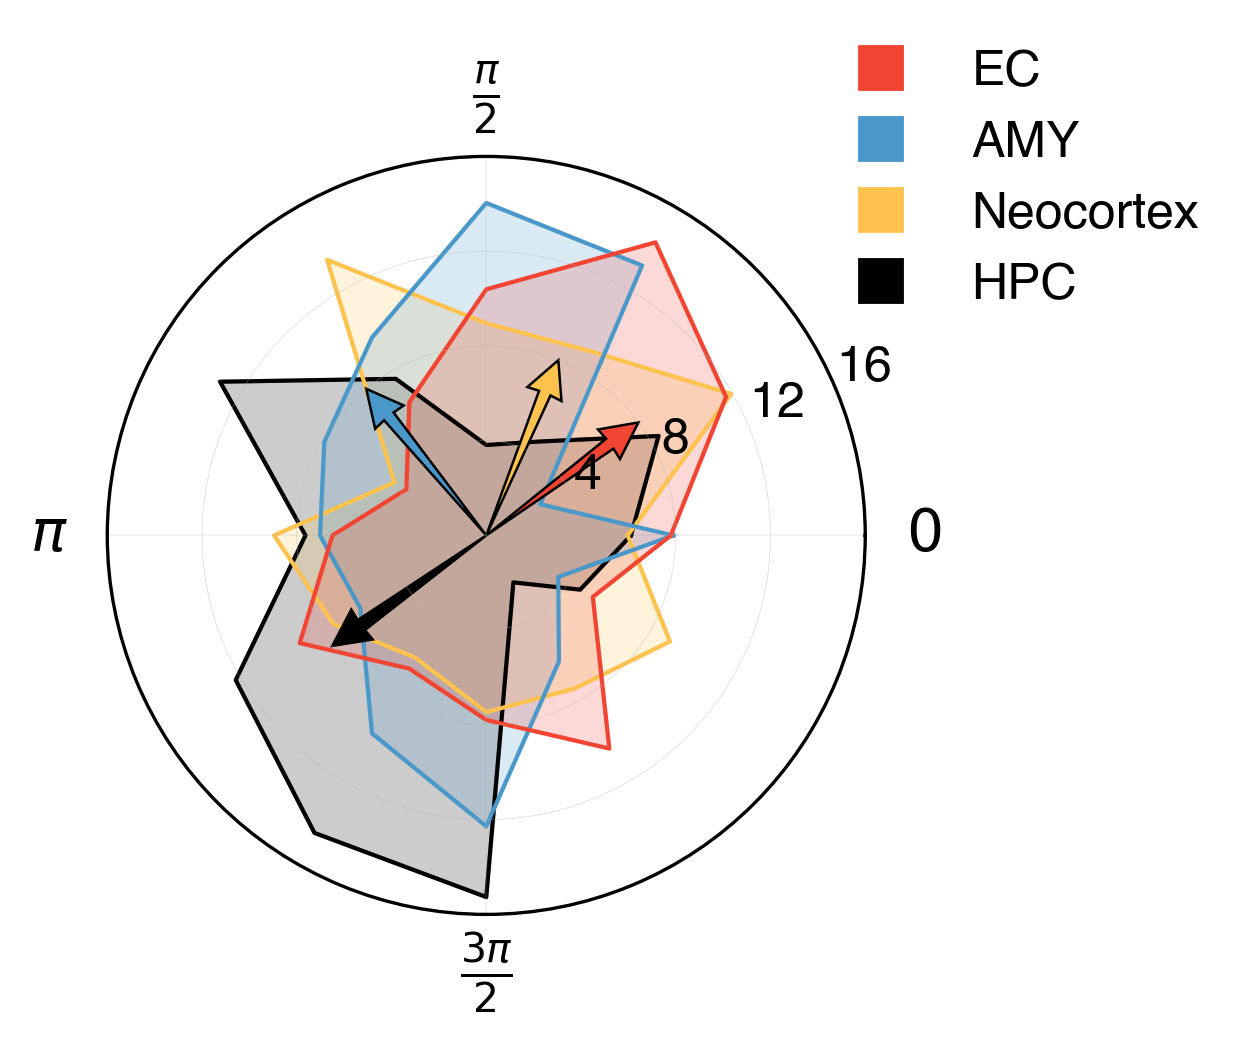

In [188]:
rois = ['hpc', 'ctx', 'amy', 'ec']
colors_ = [colors[7], colors[6], colors[0], colors[1]]
fig, ax = plt.subplots(1, 1, figsize=(colws[1], colws[1]), dpi=300, subplot_kw={'polar': True})
ax = np.ravel(ax)

i = 0
for iRoi, roi in enumerate(rois):
    counts, bin_edges, bin_centers = polar_histogram(pref_phases[roi], 12)
    counts = counts / np.sum(counts)
    ax[i].plot(np.hstack((bin_centers, bin_centers[0])), 
            np.hstack((counts, counts[0])), 
            color=colors_[iRoi], linewidth=1, linestyle='solid', zorder=0)
    ax[i].fill(np.hstack((bin_centers, bin_centers[0])), 
            np.hstack((counts, counts[0])),
            color=colors_[iRoi], alpha=0.2, zorder=0)
    phi, length = circstats.circmoment(pref_phases[roi])
    ax[i].arrow(phi, 0, 0, 0.065,
                facecolor=colors_[iRoi], lw=0.6, width=0.08, head_length=0.015, zorder=0)
xticks = [0, (np.pi / 2), np.pi, 3 * (np.pi / 2)]
yticks = np.arange(0, 16, 3, dtype=np.int)[1:]
ax[i].set_xticks(xticks)
ax[i].set_xticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$'], fontsize=font['label'])
ax[i].set_ylim((0, 0.16))
ax[i].set_yticks((0.04, 0.08, 0.12, 0.16))
ax[i].set_yticklabels((4, 8, 12, 16), fontsize=font['tick'])

custom_lines = [Line2D([0], [0], marker='s', color='w', lw=0, label='EC', markerfacecolor=colors[1], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', lw=0, label='AMY', markerfacecolor=colors[0], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', lw=0, label='Neocortex', markerfacecolor=colors[6], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', lw=0, label='HPC', markerfacecolor=colors[7], markersize=tickfontsize)]
legend = ax[0].legend(handles=custom_lines, fontsize=font['tick'], bbox_to_anchor=(1.5, 1.2))

plt.show()

In [96]:

pl_df.query(qry.format(freq_ind_2hz, freq_ind_8hz))['unit_roi3'] # & (unit_roi3=='{}')

amy    114
ec      77
ctx     67
Name: unit_roi3, dtype: int64

In [1219]:
freq_ind_2hz = int(np.where(freqs==2)[0])
freq_ind_8hz = int(np.where(freqs==8)[0])
n_theta_sig = len(pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & ({}<=locked_freq_ind_z<={})".format(freq_ind_2hz, freq_ind_8hz)))
n_sig = len(hpc_pl_df)
print('{}/{} ({:.1f}%) of sig. phase-locking cortical neurons are preferentially phase-locked from 1-8Hz'
      .format(n_theta_sig, n_sig, 100 * n_theta_sig/n_sig))
(hpc_pl_df
 .query("({}<=pl_freq<={})".format(freq_ind_2hz, freq_ind_8hz))
 .groupby('unit_roi3')
 .agg({'unit': len, 
       'pref_phase_tl_locked_time_freq_z': lambda x: circstats.circmoment(x)}))

317/362 (87.6%) of sig. phase-locking cortical neurons are preferentially phase-locked from 1-8Hz


unit          pref_phase_tl_locked_time_freq_z
unit_roi3                                                
amy         148   (3.048858207752354, 0.4658926824914629)
ctx          81   (3.126921864741354, 0.3623139598376269)
ec           88  (2.839474019034025, 0.39918878310538464)

In [1225]:
n_hpc_sig = len(pl_df.query("(edge=='hpc-local') & (sig_z_fdr==True)"))
n_hpc_theta_sig = len(pl_df.query("(edge=='hpc-local') & (sig_z_fdr==True) & ({}<=pl_freq<={})".format(freq_ind_1hz, freq_ind_8hz)))
print('{}/{} ({:.1f}%) of sig. phase-locking hippocampal neurons are preferentially phase-locked from 1-8Hz'
      .format(n_hpc_theta_sig, n_hpc_sig, 100 * n_hpc_theta_sig/n_hpc_sig))
circstats.circmoment(hpc_local_pl_df.query("({}<=pl_freq<={})".format(freq_ind_1hz, freq_ind_8hz))['pref_phase_tl_locked_time_freq_z'])

175/307 (57.0%) of sig. phase-locking hippocampal neurons are preferentially phase-locked from 1-8Hz


(-2.779974477453334, 0.31488856479214483)

In [1619]:
# Get dataframe subset for just the significant ctx-hpc connections
hpc_pl_df = pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)").reset_index(drop=True).copy()
hpc_pl_df['mono_roi'] = ''
hpc_pl_df['mono_roi2'] = ''
hpc_pl_df.loc[(hpc_pl_df.same_hem==True) & (hpc_pl_df.unit_roi2=='amy'), 'mono_roi'] = 'amy'
hpc_pl_df.loc[(hpc_pl_df.same_hem==True) & (hpc_pl_df.unit_roi2=='ec'), 'mono_roi'] = 'ec'
hpc_pl_df.loc[(hpc_pl_df.mono_roi==''), 'mono_roi'] = 'other'
hpc_pl_df.loc[(hpc_pl_df.same_hem==True) & (hpc_pl_df.unit_roi2=='amy'), 'mono_roi2'] = 'ipsi_amy'
hpc_pl_df.loc[(hpc_pl_df.same_hem==True) & (hpc_pl_df.unit_roi2=='ec'), 'mono_roi2'] = 'ipsi_ec'
hpc_pl_df.loc[(hpc_pl_df.same_hem==True) & (hpc_pl_df.mono_roi2==''), 'mono_roi2'] = 'ipsi_other'
hpc_pl_df.loc[(hpc_pl_df.same_hem==False) & (hpc_pl_df.unit_roi2=='amy'), 'mono_roi2'] = 'contra_amy'
hpc_pl_df.loc[(hpc_pl_df.same_hem==False) & (hpc_pl_df.unit_roi2=='ec'), 'mono_roi2'] = 'contra_ec'
hpc_pl_df.loc[(hpc_pl_df.same_hem==False) & (hpc_pl_df.mono_roi2==''), 'mono_roi2'] = 'contra_other'
hpc_pl_df['gamma_pl'] = hpc_pl_df['mrls_z'].apply(lambda x: np.max(x[10:])>3)
print(hpc_pl_df.shape)

(478, 61)


In [902]:
# Save the phase-locking DataFrame for mixed effects analysis in R
if False:
    cols = ['subj', 'sess', 'unit_chan_ind', 'unit', 'unit_hemroi', 'lfp_hemroi', 'unit_roi2', 'unit_roi3',
            'roi_unit_to_lfp', 'same_hem', 'locked_freq_ind_z', 'locked_mrl_z', 
            'tl_locked_freq_z', 'tl_locked_time_z', 'tl_locked_mrl_z', 'sig_z_fdr',
            'pl_freq', 'pl_strength', 'pl_time_shift', 'pl_latency']
    df = pl_df[cols].copy()
    df['tl_locked_time_z'] = -df['tl_locked_time_z'] # flip times back (positive values = spikes precede LFP)
    fname = '/home1/dscho/projects/unit_activity_and_hpc_theta/figs/pl_df_{}-ctx-hpc.csv'.format(len(df))
    df.to_csv(fname, index=False)
    print('Saved {}'.format(fname))

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs/pl_df_2405-ctx-hpc.csv


In [111]:
# Save the phase-locking DataFrame for mixed effects analysis in R
if False:
    cols = ['subj', 'sess', 'unit_chan_ind', 'unit', 'unit_hemroi', 'lfp_hemroi', 
            'unit_roi2', 'unit_roi3', 'locked_mrl_z', 'locked_freq_ind_z', 'sig_z_fdr']
    df = pl_df.query("(edge=='ctx-hpc') & (same_hem==True)")[cols].copy()
    fname = '/home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/R_tables/ipl_df-ctx_hpc_{}-rows.csv'.format(len(df))
    df.to_csv(fname, index=False)
    print('Saved {}'.format(fname))

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/R_tables/ipl_df-ctx_hpc_1233-rows.csv


In [1447]:
(pl_df
 .query("(sig_z_fdr==True) & (same_hem==True)")
 .groupby('edge')
 .agg({'unit': len, 'pl_strength': np.mean, 'locked_freq_ind_z': np.mean, 'pl_freq': np.mean, 'pl_time_shift': np.mean, 'pl_latency': np.mean}))

unit  pl_strength  locked_freq_ind_z    pl_freq  pl_time_shift  \
edge                                                                        
ctx-ctx     431     8.883567           5.211137   5.245940    -104.222738   
ctx-hpc     362     8.948787           5.174033   5.143646     -60.745856   
ctx-local  1207    11.641962          10.566694  10.338028     -27.357084   
hpc-ctx     304     8.786580           5.417763   5.509868     -64.407895   
hpc-hpc      36     8.714774           4.027778   4.138889    -131.111111   
hpc-local   307    15.489058           7.996743   7.794788     -58.110749   

           pl_latency  
edge                   
ctx-ctx    200.974478  
ctx-hpc    146.215470  
ctx-local  129.378625  
hpc-ctx    168.355263  
hpc-hpc    158.888889  
hpc-local  126.449511

# Table 1

In [908]:
print(np.median(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby('subj_sess_unit')['unit_fr'].apply(lambda x: np.mean(x))),
      np.percentile(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby('subj_sess_unit')['unit_fr'].apply(lambda x: np.mean(x)), 25),
      np.percentile(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby('subj_sess_unit')['unit_fr'].apply(lambda x: np.mean(x)), 75))

2.3338735103607178 0.8900693655014038 5.590949058532715


In [838]:
table1 = (pl_df
          .query("(edge=='ctx-hpc')")
          .groupby('unit_roi2')
          .agg({'subj': lambda x: len(np.unique(x)), 
                'subj_sess': lambda x: len(np.unique(x)),
                'subj_sess_unit': lambda x: len(np.unique(x)),
                'same_hem': lambda x: '{}, {}'.format(np.sum(x), len(x) - np.sum(x))}))
table1

subj  subj_sess  subj_sess_unit  same_hem
unit_roi2                                           
ac            5         12             116   101, 99
amy          14         30             359  327, 316
ctx          10         24             303  277, 270
ec           12         30             247  221, 209
ofc           9         20             168  155, 158
phg          10         22             155  152, 120

In [841]:
table1 = (pl_df
          .query("(edge=='ctx-hpc') & (same_hem==True)")
          .groupby('unit_roi2')
          .agg({'subj': lambda x: len(np.unique(x)), 
                'subj_sess': lambda x: len(np.unique(x)),
                'subj_sess_unit': lambda x: len(np.unique(x))}))
table1

subj  subj_sess  subj_sess_unit
unit_roi2                                 
ac            5         12             101
amy          14         30             327
ctx          10         23             277
ec           12         30             221
ofc           8         17             155
phg           9         21             152

In [1476]:
table1 = (pl_df
          .query("(edge=='ctx-hpc') & (same_hem==True)")
          .groupby('unit_roi2')
          .agg({'subj': lambda x: len(np.unique(x)), 
                'subj_sess': lambda x: len(np.unique(x)),
                'subj_sess_unit': lambda x: len(np.unique(x)),
                'sig_z_fdr': lambda x: np.round(100*np.mean(x), 1)}))
table1

subj  subj_sess  subj_sess_unit  sig_z_fdr
unit_roi2                                            
ac            5         12             101        5.0
amy          14         30             327       49.2
ctx          10         23             277       19.5
ec           12         30             221       48.0
ofc           8         17             155       10.3
phg           9         21             152       13.2

In [1867]:
sess_per_subj = np.array(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby('subj').agg({'subj': lambda x: str(x), 'subj_sess': lambda x: len(np.unique(x))})['subj_sess'].tolist())
print('{:.1f} ± {:.1f} sessions per subject (M ± SD)'.format(np.mean(sess_per_subj), np.std(sess_per_subj)))
print('{}–{} sessions per subject (median {})'.format(np.min(sess_per_subj), np.max(sess_per_subj), np.median(sess_per_subj)))

2.4 ± 1.0 sessions per subject (M ± SD)
1–4 sessions per subject (median 2.5)


In [1856]:
print('subj:', len(np.unique(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)")['subj'])))
print('subj_sess:', len(np.unique(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)")['subj_sess'])))
print('subj_sess_unit:', len(np.unique(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)")['subj_sess_unit'])))

subj: 18
subj_sess: 43
subj_sess_unit: 1233


In [904]:
# Get the column totals
print('subj:', len(np.unique(pl_df.query("(edge=='ctx-hpc')")['subj'])))
print('subj_sess:', len(np.unique(pl_df.query("(edge=='ctx-hpc')")['subj_sess'])))
print('subj_sess_unit:', len(np.unique(pl_df.query("(edge=='ctx-hpc')")['subj_sess_unit'])))
print('ipsi, contra:', len(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)")), len(pl_df.query("(edge=='ctx-hpc') & (same_hem==False)")))

subj: 18
subj_sess: 43
subj_sess_unit: 1348
ipsi, contra: 1233 1172


# Table 2

In [1907]:
def format_table(x, is_freq=False):
    if is_freq:
        return '{} $\pm$ {}'.format(np.round(2**(np.mean(x)/2 - 1), 1), np.round(2**(np.std(x)/2 - 1), 1))
    else:
        return '{} $\pm$ {}'.format(np.round(np.mean(x), 1), np.round(np.std(x), 1))
    
def format_table2(x, is_freq=False):
    if is_freq:
        return '{} $\pm$ {}'.format(np.round(stats.mstats.gmean(x), 1), np.round(2**(np.std(x)/2 - 1), 1))
    else:
        return '{} $\pm$ {}'.format(np.round(np.mean(x), 1), np.round(np.std(x), 1))
    
def format_table_conf(x, is_freq=False):
    if is_freq:
        return '{} $\pm$ {}'.format(np.round(2**(np.mean(x)/2 - 1), 1), np.round(2**((stats.sem(x)*stats.t.ppf(0.975, len(x)-1))/2 - 1), 1))
    else:
        return '{} $\pm$ {}'.format(np.round(np.mean(x), 1), np.round(stats.sem(x)*stats.t.ppf(0.975, len(x)-1), 1))

In [1906]:
freqs, (np.log2(freqs) + 1) * 2

(array([ 0.5       ,  0.70710678,  1.        ,  1.41421356,  2.        ,
         2.82842712,  4.        ,  5.65685425,  8.        , 11.3137085 ,
        16.        , 22.627417  , 32.        , 45.254834  , 64.        ,
        90.50966799]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15.]))

In [1914]:
df.groupby('unit_roi3').agg({'unit': len, 'locked_freq_ind_z': lambda x: 2**(np.mean(x)/2 - 1), 'locked_freq_z': lambda x: stats.mstats.gmean(x)})

unit  locked_freq_ind_z  locked_freq_z
unit_roi3                                        
amy         161           2.645842       2.645842
ctx          95           2.737069       2.737069
ec          106           3.960957       3.960957

In [1899]:
df = pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True)")[['unit', 'unit_roi3', 'same_hem', 'locked_freq_ind_z', 'locked_mrl_z']].copy()
df['locked_freq_z'] = 2**(df['locked_freq_ind_z']/2 - 1)
display(df.groupby(['unit_roi3']).agg({'unit': len,
                                       'locked_mrl_z': lambda x: format_table2(x), 
                                       'locked_freq_z': lambda x: format_table2(x, True)}))

unit   locked_mrl_z   locked_freq_z
unit_roi3                                     
amy         161  8.8 $\pm$ 5.5   2.6 $\pm$ 1.4
ctx          95  6.2 $\pm$ 3.0   2.7 $\pm$ 9.3
ec          106  9.0 $\pm$ 7.1  4.0 $\pm$ 39.7

In [1875]:
df = pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True)")[['unit', 'unit_roi3', 'same_hem', 'locked_freq_ind_z', 'locked_mrl_z']].copy()
# df['pl_time_shift'] = -df['pl_time_shift'] # flip times back (positive values = spikes precede LFP)
display(df.groupby(['unit_roi3']).agg({'unit': len,
                                       'locked_mrl_z': lambda x: format_table(x), 
                                       'locked_freq_ind_z': lambda x: format_table(x, True)}))

unit   locked_mrl_z locked_freq_ind_z
unit_roi3                                       
amy         161  8.8 $\pm$ 5.5     2.6 $\pm$ 1.0
ctx          95  6.2 $\pm$ 3.0     2.7 $\pm$ 1.2
ec          106  9.0 $\pm$ 7.1     4.0 $\pm$ 1.2

In [674]:
print(len(hpc_pl_df.query("(same_hem==True) & (pl_freq<3)")), len(hpc_pl_df.query("(same_hem==True)")), 100 * len(hpc_pl_df.query("(same_hem==True) & (pl_freq<3)")) / len(hpc_pl_df.query("(same_hem==True)")))
print(len(hpc_pl_df.query("(same_hem==True) & (pl_freq>8)")), len(hpc_pl_df.query("(same_hem==True)")), 100 * len(hpc_pl_df.query("(same_hem==True) & (pl_freq>8)")) / len(hpc_pl_df.query("(same_hem==True)")))

31 362 8.56353591160221
27 362 7.458563535911602


In [645]:
display(np.round(df[['pl_strength', 'pl_freq', 'pl_time_shift', 'pl_latency']].corr(), 2))

pl_strength  pl_freq  pl_time_shift  pl_latency
pl_strength           1.00     0.10           0.04       -0.14
pl_freq               0.10     1.00          -0.25       -0.39
pl_time_shift         0.04    -0.25           1.00        0.24
pl_latency           -0.14    -0.39           0.24        1.00

# Phase-locking by region

In [1437]:
keep_units = (pl_df
              .query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True) & (unit_roi3=='ctx')") #(2<=pl_freq<=8)
              .sort_values('unit_fr', ascending=False)
              .groupby(['subj_sess', 'unit_chan_ind'])
              .agg({'subj_sess_unit': lambda x: list(x)[0],
                    'unit_fr': lambda x: list(x)})['subj_sess_unit'].tolist())
qry = "(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True) & (subj_sess_unit=={})".format(keep_units)

roi_freq_pairs = od([('same', []), ('diff', [])])
for subj_sess, df in pl_df.query(qry).groupby('subj_sess'):
    for iRow1, iRow2 in itertools.combinations(range(len(df)), 2):
        if df.iloc[iRow1]['unit_hemroi'] == df.iloc[iRow2]['unit_hemroi']:
            roi_freq_pairs['same'].append(np.abs(df.iloc[iRow1]['pl_freq'] - df.iloc[iRow2]['pl_freq']))
        else:
            roi_freq_pairs['diff'].append(np.abs(df.iloc[iRow1]['pl_freq'] - df.iloc[iRow2]['pl_freq']))

for key in roi_freq_pairs.keys():
    print(key, len(roi_freq_pairs[key]))

same 225
diff 105


In [1438]:
print(np.mean(roi_freq_pairs['same']), np.std(roi_freq_pairs['same']))
print(np.mean(roi_freq_pairs['diff']), np.std(roi_freq_pairs['diff']))
print(stats.ttest_ind(roi_freq_pairs['same'], roi_freq_pairs['diff'], equal_var=False))

1.568888888888889 1.732284583012621
1.8095238095238095 1.5681061558771374
Ttest_indResult(statistic=-1.250320833319987, pvalue=0.21249790691127737)


In [647]:
print('Ipsilateral:')
n_cells = len(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby('subj_sess_unit'))
n_sig_cells = len(pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True)").groupby('subj_sess_unit'))
print('{}/{} ({:.1f}% phase-locked cells)'.format(n_sig_cells, n_cells, 100*(n_sig_cells/n_cells)))

print('\nContralateral:')
n_cells = len(pl_df.query("(edge=='ctx-hpc') & (same_hem==False)").groupby('subj_sess_unit'))
n_sig_cells = len(pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==False)").groupby('subj_sess_unit'))
print('{}/{} ({:.1f}% phase-locked cells)'.format(n_sig_cells, n_cells, 100*(n_sig_cells/n_cells)))

Ipsilateral:
362/1233 (29.4% phase-locked cells)

Contralateral:
116/1172 (9.9% phase-locked cells)


In [648]:
n_cells = len(pl_df.query("(edge=='ctx-hpc')").groupby('subj_sess_unit'))
n_sig_cells = len(pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)").groupby('subj_sess_unit'))
print('{}/{} ({:.1f}% phase-locked cells)'.format(n_sig_cells, n_cells, 100*(n_sig_cells/n_cells)))

394/1348 (29.2% phase-locked cells)


In [649]:
# What number and percent of cells in each region phase-locked 
# to ipsilateral vs contralateral HPC LFPs?
(pl_df
 .query("(edge=='ctx-hpc')")
 .groupby(['subj_sess_unit', 'same_hem'])
 .agg({'unit': len, 'unit_roi3': lambda x: list(x)[0],'sig_z_fdr': lambda x: np.sum(x)>0})
 .reset_index()
 .groupby(['unit_roi3', 'same_hem'])
 .agg({'unit': len, 'sig_z_fdr': [np.sum, lambda x: 100 * np.mean(x)]})
 .reset_index())

unit_roi3 same_hem unit sig_z_fdr           
                      len       sum   <lambda>
0       amy    False  316      61.0  19.303797
1       amy     True  327     161.0  49.235474
2       ctx    False  647      35.0   5.409583
3       ctx     True  685      95.0  13.868613
4        ec    False  209      20.0   9.569378
5        ec     True  221     106.0  47.963801

In [650]:
# What number and percent of cells in each region phase-locked 
# to ipsilateral vs contralateral HPC LFPs?
(pl_df
 .query("(edge=='ctx-hpc')")
 .groupby(['subj_sess_unit', 'same_hem'])
 .agg({'unit': len, 'unit_roi2': lambda x: list(x)[0],'sig_z_fdr': lambda x: np.sum(x)>0})
 .reset_index()
 .groupby(['unit_roi2', 'same_hem'])
 .agg({'unit': len, 'sig_z_fdr': [np.sum, lambda x: 100 * np.mean(x)]})
 .reset_index())

unit_roi2 same_hem unit sig_z_fdr           
                       len       sum   <lambda>
0         ac    False   99       1.0   1.010101
1         ac     True  101       5.0   4.950495
2        amy    False  316      61.0  19.303797
3        amy     True  327     161.0  49.235474
4        ctx    False  270      14.0   5.185185
5        ctx     True  277      54.0  19.494585
6         ec    False  209      20.0   9.569378
7         ec     True  221     106.0  47.963801
8        ofc    False  158       8.0   5.063291
9        ofc     True  155      16.0  10.322581
10       phg    False  120      12.0  10.000000
11       phg     True  152      20.0  13.157895

In [45]:
# What number and percent of cells phase-locked 
# to ipsilateral vs contralateral HPC LFPs?
(pl_df
 .query("(edge=='ctx-hpc')")
 .groupby(['subj_sess_unit', 'same_hem'])
 .agg({'unit': len, 'unit_roi2': lambda x: list(x)[0],'sig_z_fdr': lambda x: np.sum(x)>0})
 .reset_index()
 .groupby(['same_hem'])
 .agg({'unit': len, 'sig_z_fdr': [np.sum, lambda x: 100 * np.mean(x)]})
 .reset_index())

same_hem  unit sig_z_fdr           
             len       sum   <lambda>
0    False  1172     116.0   9.897611
1     True  1233     362.0  29.359286

In [1732]:
# Calculate the percent of neurons in each region that significantly
# phase-lock to ipsi- and contralateral hippocampal oscillations
def get_conf(x):
    """Return a 95% confidence interval using normal approximation of the binomial distribution.
    
    np ± 1.96 * sqrt(np(1-p))
    
    where n is the sample size and p is the probability of a given outcome
    """
    n = x.unit
    p = x.sig_z_fdr
    np_ =  n * p
    return 1.96 * np.sqrt(np_ * (1 - p))

df = (pl_df
      .query("(edge=='ctx-hpc')")
      .groupby(['subj_sess_unit', 'same_hem'])
      .agg({'unit': len, 'unit_roi2': lambda x: list(x)[0],'sig_z_fdr': lambda x: np.sum(x)>0})
      .reset_index()
      .groupby(['unit_roi2', 'same_hem'])
      .agg({'unit': len, 'sig_z_fdr': np.mean})
      .reset_index())

rois = od([('amy', 'AMY'),
           ('ec', 'EC'), 
           ('phg', 'PHG'),
           ('ofc', 'OFC'),
           ('ac', 'AC'),
           ('ctx', 'Other')])

df['unit_roi2'] = df.unit_roi2.astype('category').cat.reorder_categories(rois.keys(), ordered=True)
df['hem'] = df.same_hem.apply(lambda x: 'ipsi' if x else 'contra')
df['hem'] = df.hem.astype('category').cat.reorder_categories(['ipsi', 'contra'], ordered=True)
df['err'] = df.apply(lambda x: get_conf(x)/x.unit, axis=1)
df['sig_z_ratio'] = df['sig_z_fdr'] / max(df['sig_z_fdr'])

In [326]:
pl_df.query("(same_hem==True) & (sig_z_fdr==True)").groupby('unit_roi').agg({'unit': len, 
                                                                             'subj': lambda x: [len(np.unique(x)), 
                                                                                                list(np.unique(x, return_counts=True)[1])]})

unit                                               subj
unit_roi                                                         
A          161  [13, [9, 6, 30, 4, 5, 2, 36, 7, 23, 2, 9, 24, 4]]
AC           5                                        [2, [1, 4]]
EC         106       [11, [1, 20, 11, 5, 3, 11, 2, 24, 13, 8, 8]]
MC          19                                          [1, [19]]
MST          1                                           [1, [1]]
OF          16                            [6, [1, 1, 1, 3, 2, 8]]
PC           2                                           [1, [2]]
PG          20                            [6, [7, 1, 4, 2, 3, 3]]
PO           1                                           [1, [1]]
PS           4                                           [1, [4]]
SAO          2                                           [1, [2]]
ST           7                                        [2, [6, 1]]
TP          18                                          [1, [18]]

In [330]:
pl_df.query("(same_hem==False) & (subj==['U373', 'U374', 'U379'])").groupby(['subj', 'unit_roi']).agg({'unit': len,
                                                                            'sig_z_fdr': [np.sum, np.mean]})

unit sig_z_fdr          
               len       sum      mean
subj unit_roi                         
U373 A          28       4.0  0.142857
     EC         14       1.0  0.071429
     OF          7       0.0  0.000000
U374 AC         15       0.0  0.000000
     EC         12       1.0  0.083333
     SMA        22       0.0  0.000000
U379 A          19       0.0  0.000000
     AC         17       0.0  0.000000
     pSMA       23       0.0  0.000000

In [1478]:
pl_df.query("(same_hem==True) & (edge=='ctx-hpc')").groupby('unit_roi').agg({'unit': len, 
                                                         'subj': lambda x: [len(np.unique(x)), 
                                                                            list(np.unique(x, return_counts=True)[0]),
                                                                            list(np.unique(x, return_counts=True)[1])], 
                                                         'sig_z_fdr': [np.sum, np.mean]})

unit                                               subj sig_z_fdr  \
          len                                           <lambda>       sum   
unit_roi                                                                     
A         327  [14, [U369, U370, U371, U372, U373, U379, U381...     161.0   
AC        101  [5, [U374, U379, U381, U385, U387], [12, 17, 3...       5.0   
EC        221  [12, [U370, U371, U372, U373, U374, U380, U381...     106.0   
IPO         1                                   [1, [U390], [1]]       0.0   
MC         53                                  [1, [U380], [53]]      19.0   
MST        34                                  [1, [U380], [34]]       1.0   
OF        155  [8, [U370, U381, U384, U385, U387, U392, U394,...      16.0   
PC          6                                   [1, [U394], [6]]       2.0   
PG        152  [9, [U371, U372, U373, U380, U387, U390, U393,...      20.0   
PO         14                                  [1, [U372], [14]]       1.0   
PS         30                                  [1, [U369], [30]]       4.0   
PST         2                                   [1, [U380], [2]]       0.0   
SAO         5                                   [1, [U390], [5]]       2.0   
SMA        33                        [2, [U373, U374], [23, 10]]       0.0   
ST         51      [4, [U369, U380, U393, U394], [27, 13, 3, 8]]       7.0   
TP         25                                  [1, [U385], [25]]      18.0   
pSMA       23                                  [1, [U379], [23]]       0.0   

                    
              mean  
unit_roi            
A         0.492355  
AC        0.049505  
EC        0.479638  
IPO       0.000000  
MC        0.358491  
MST       0.029412  
OF        0.103226  
PC        0.333333  
PG        0.131579  
PO        0.071429  
PS        0.133333  
PST       0.000000  
SAO       0.400000  
SMA       0.000000  
ST        0.137255  
TP        0.720000  
pSMA      0.000000

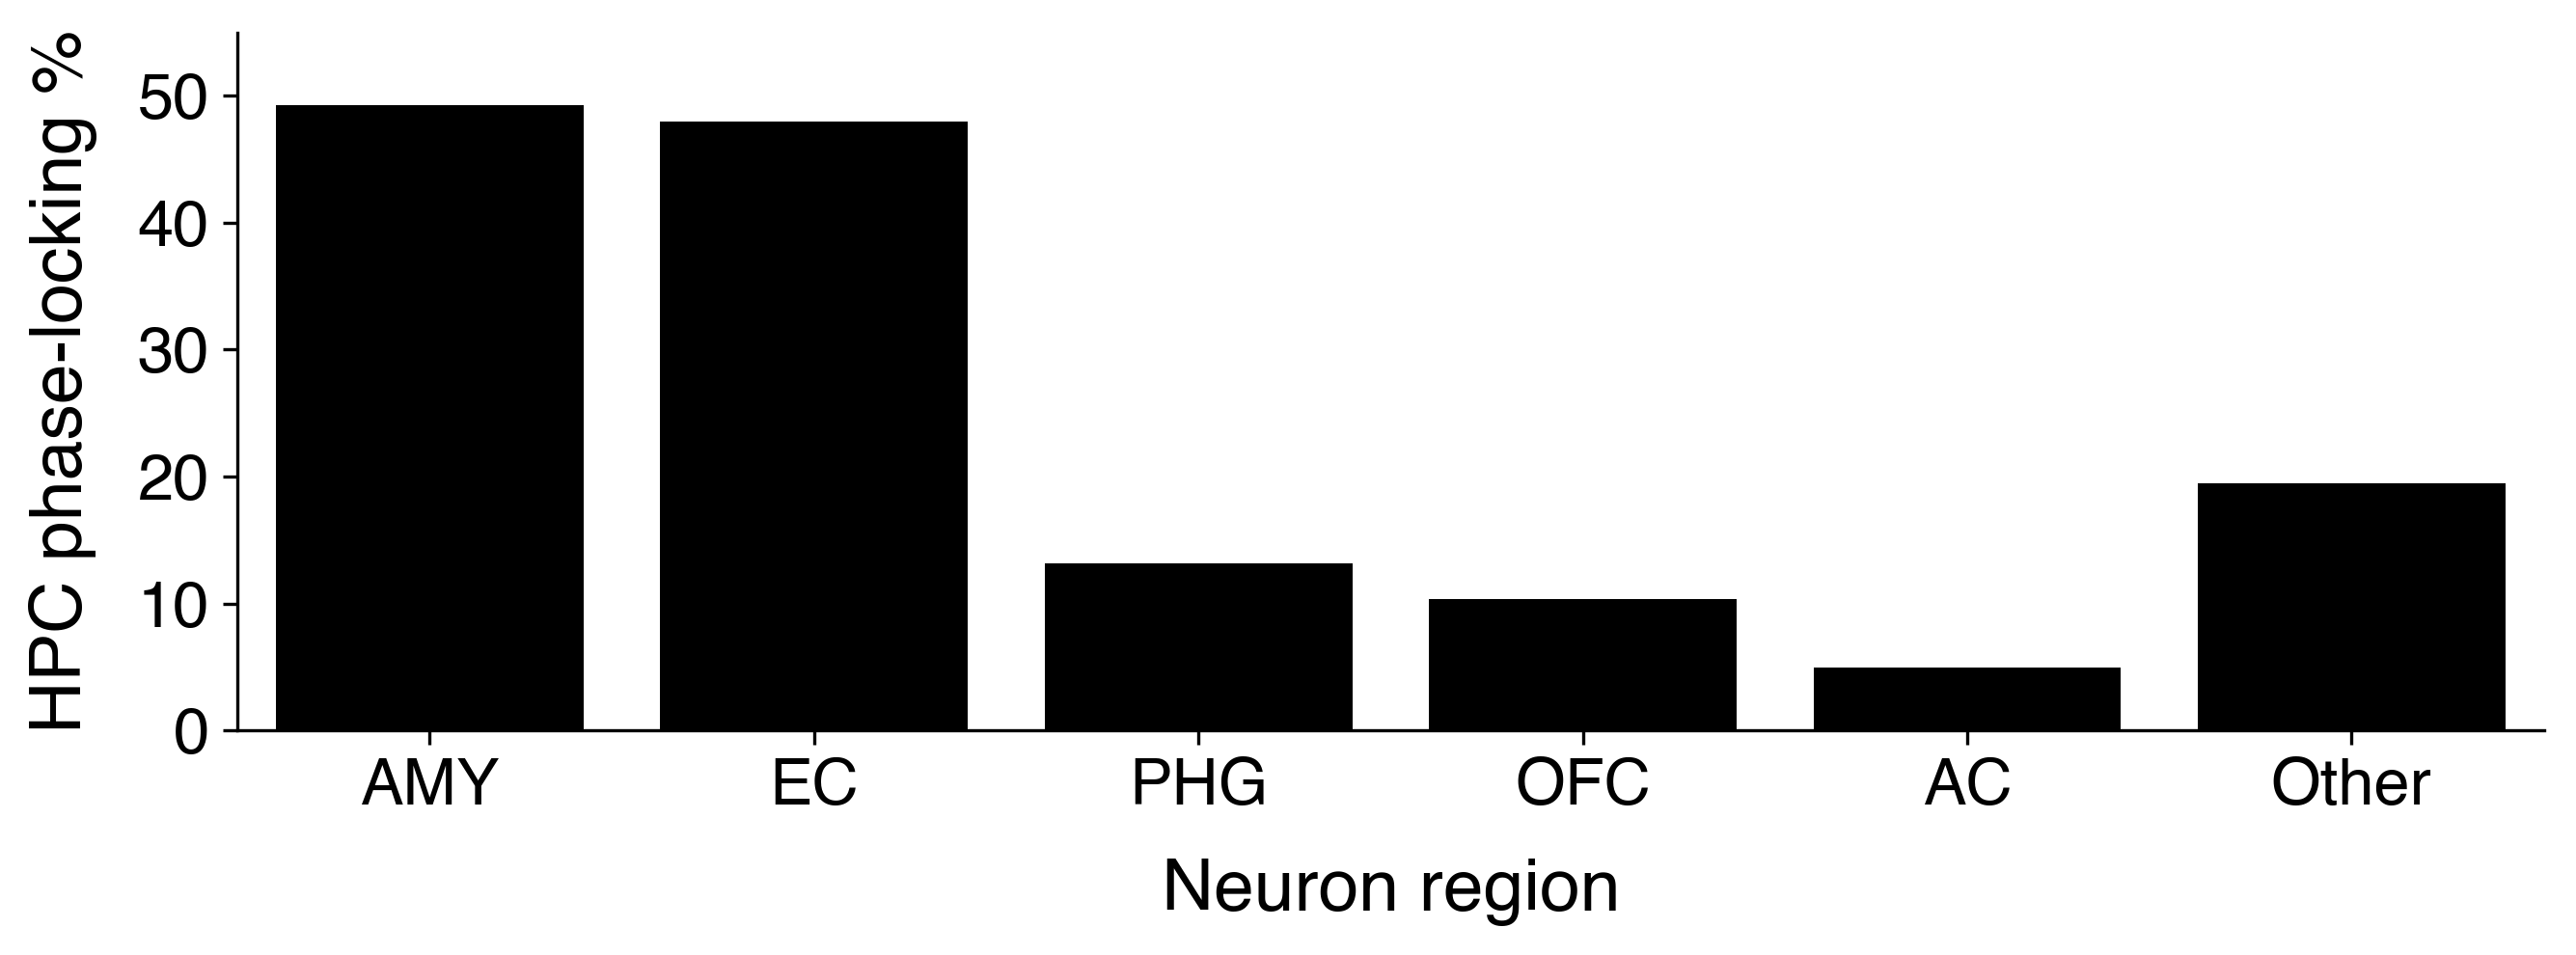

In [1737]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3.4), dpi=300) # 2 column width
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

i = 0
sns.barplot(x='unit_roi2', y='sig_z_fdr', data=df.query("(same_hem==True)"), color='k', ax=ax[i])
xax = np.repeat(np.arange(6, dtype=float), 2)
xax[::2] -= 0.2
xax[1::2] += 0.2
ax[i].set_xticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylim([0, 0.55])
ax[i].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax[i].set_yticklabels([0, 10, 20, 30, 40, 50], fontsize=tickfontsize)
ax[i].set_xlabel('Neuron region', fontsize=labelfontsize, labelpad=10)
ax[i].set_ylabel('HPC phase-locking %', fontsize=labelfontsize, labelpad=10)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_pct_by_roi_forCNS.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_pct_by_roi_forCNS.png', 
                format='png', dpi=300, bbox_inches='tight')

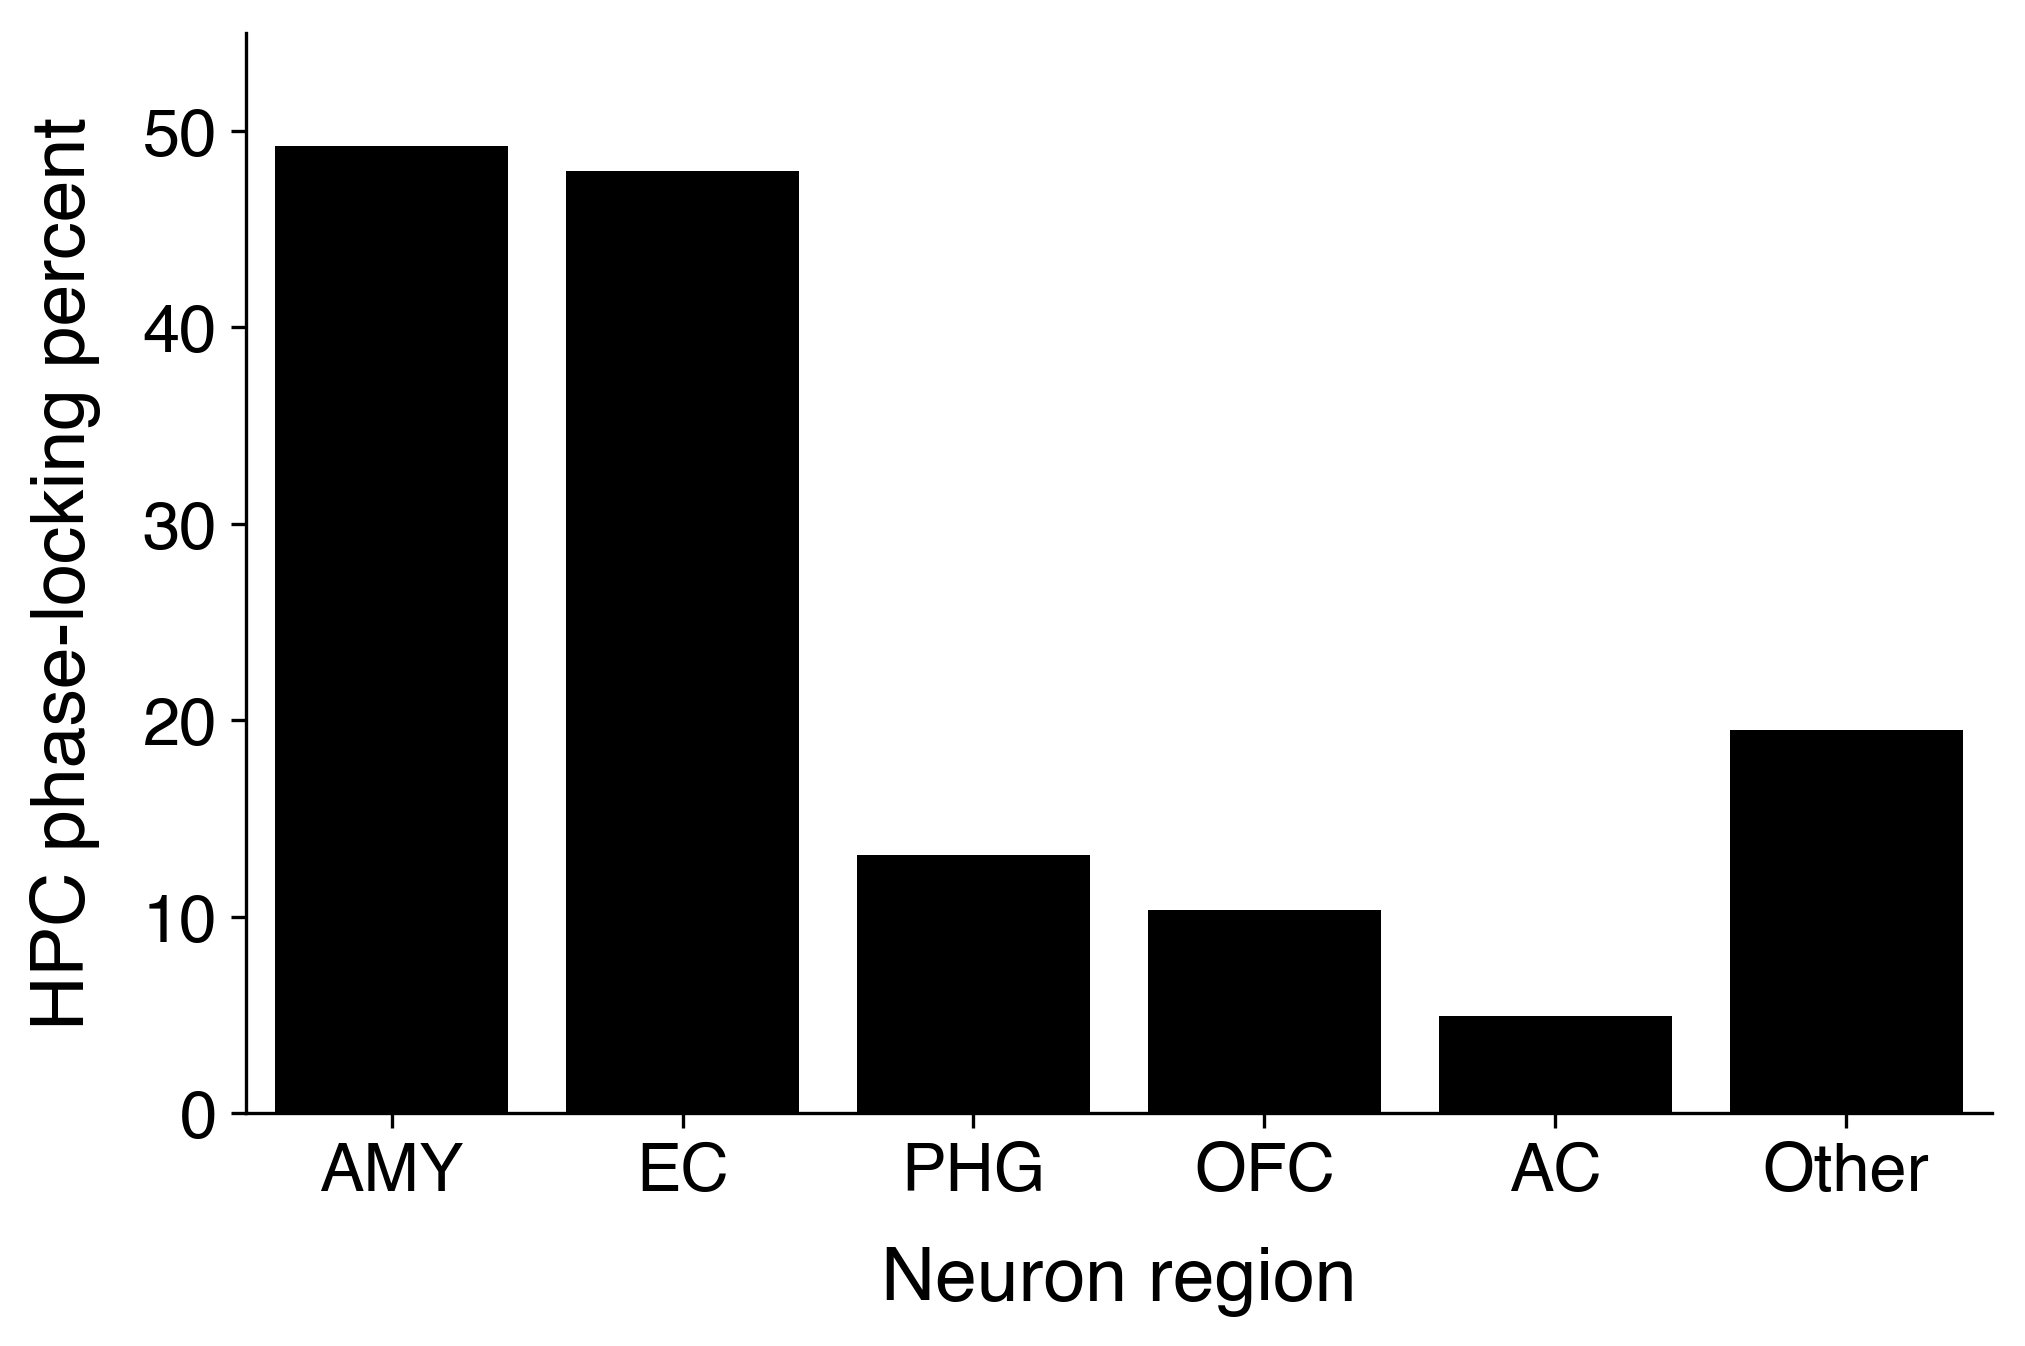

In [856]:
fig, ax = plt.subplots(1, 1, figsize=(colws[2], colws[2]*0.67), dpi=300) # 2 column width
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

i = 0
sns.barplot(x='unit_roi2', y='sig_z_fdr', data=df.query("(same_hem==True)"), color='k', ax=ax[i])
xax = np.repeat(np.arange(6, dtype=float), 2)
xax[::2] -= 0.2
xax[1::2] += 0.2
ax[i].set_xticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylim([0, 0.55])
ax[i].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax[i].set_yticklabels([0, 10, 20, 30, 40, 50], fontsize=tickfontsize)
ax[i].set_xlabel('Neuron region', fontsize=labelfontsize, labelpad=10)
ax[i].set_ylabel('HPC phase-locking percent', fontsize=labelfontsize, labelpad=10)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_pct_by_roi.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_pct_by_roi.png', 
                format='png', dpi=300, bbox_inches='tight')

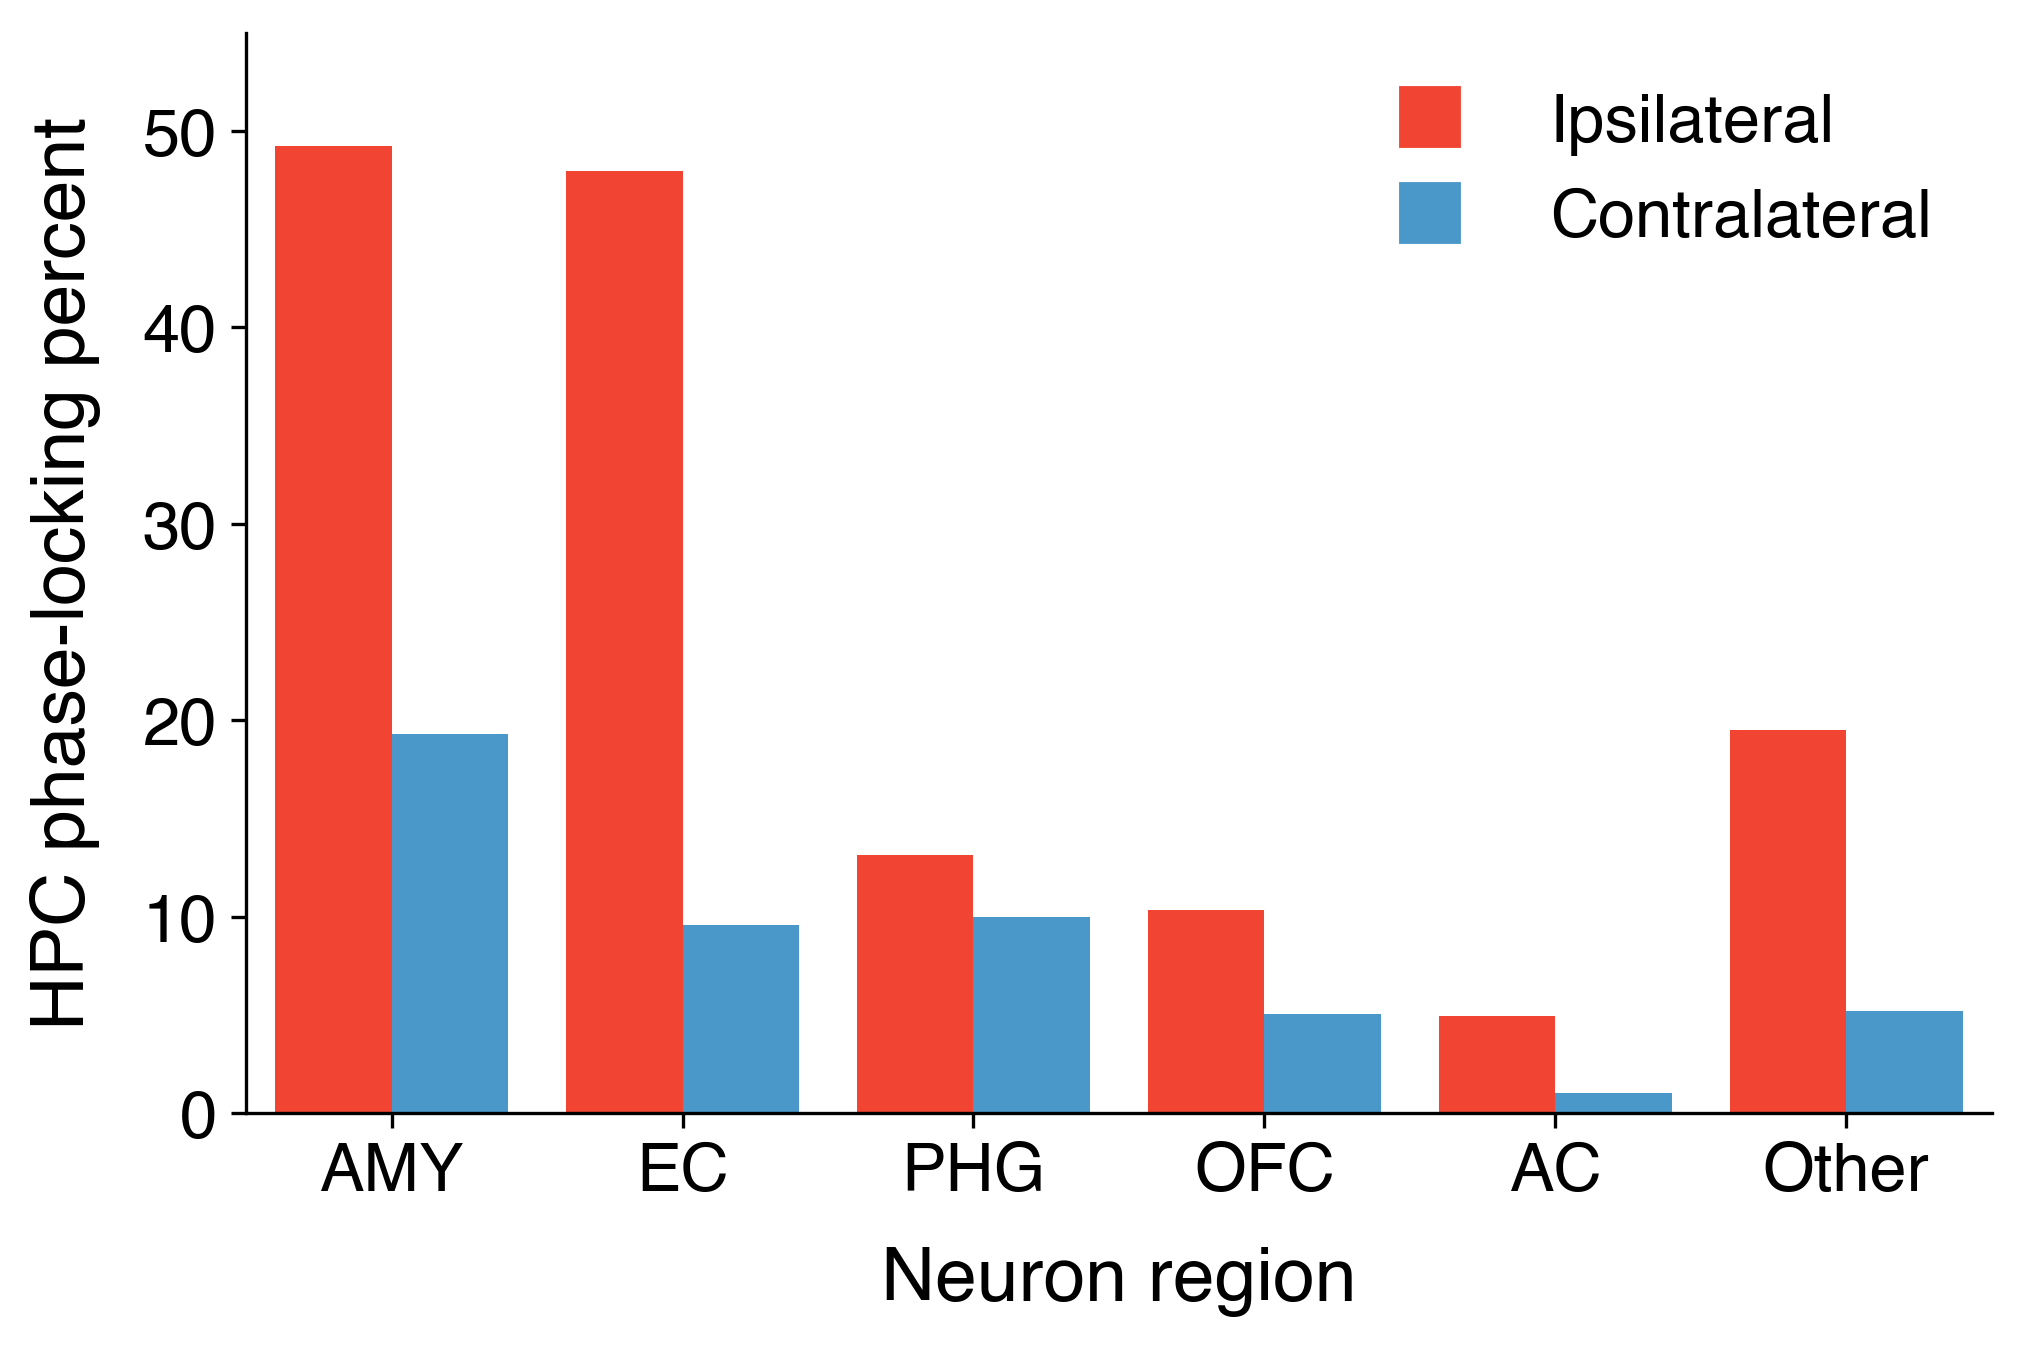

In [332]:
# fig, ax = plt.subplots(1, 1, figsize=(3.34646, 2.34252), dpi=300) # 1 column width
# fig, ax = plt.subplots(1, 1, figsize=(4.48819, 3.14173), dpi=300) # 1.5 column width
fig, ax = plt.subplots(1, 1, figsize=(6.85039, 6.85039*0.67), dpi=300) # 2 column width
ax = np.ravel(ax)

# tickfontsize = 10
# labelfontsize = 12
tickfontsize = 16
labelfontsize = 18


i = 0
sns.barplot(x='unit_roi2', y='sig_z_fdr', hue='hem', data=df, 
            palette=[colors[1], colors[0]], saturation=1, ax=ax[i])
xax = np.repeat(np.arange(6, dtype=float), 2)
xax[::2] -= 0.2
xax[1::2] += 0.2
ax[i].set_xticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylim([0, 0.55])
ax[i].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax[i].set_yticklabels([0, 10, 20, 30, 40, 50], fontsize=tickfontsize)
ax[i].set_xlabel('Neuron region', fontsize=labelfontsize, labelpad=10)
ax[i].set_ylabel('HPC phase-locking percent', fontsize=labelfontsize, labelpad=10)
ax[i].get_legend().remove()

custom_lines = [Line2D([0], [0], marker='s', color='w', label='Ipsilateral', markerfacecolor=colors[1], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Contralateral', markerfacecolor=colors[0], markersize=tickfontsize)]
legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_pct_by_roi_and_hem_noerrorbars.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_pct_by_roi_and_hem_noerrorbars.png', 
                format='png', dpi=300, bbox_inches='tight')

# Phase-locking by frequency and strength

In [1659]:
sig_neurons = pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)")['subj_sess_unit'].tolist()
theta_neurons = pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True) & (2<=locked_freq_ind_z<=8)")['subj_sess_unit'].tolist()
print('{}/{} {:.1f}% neurons preferentially phase-locked to 1-8Hz hippocampal theta'.format(len(theta_neurons), len(sig_neurons), 100*len(theta_neurons)/len(sig_neurons)))

pl_df.query("(same_hem==True) & (edge=='ctx-hpc') & (subj_sess_unit=={})".format(theta_neurons)).apply(lambda x: x['tl_mrls'][x['locked_freq_ind_z'], 200], axis=1).mean()

317/362 87.6% neurons preferentially phase-locked to 1-8Hz hippocampal theta


0.07248697225121951

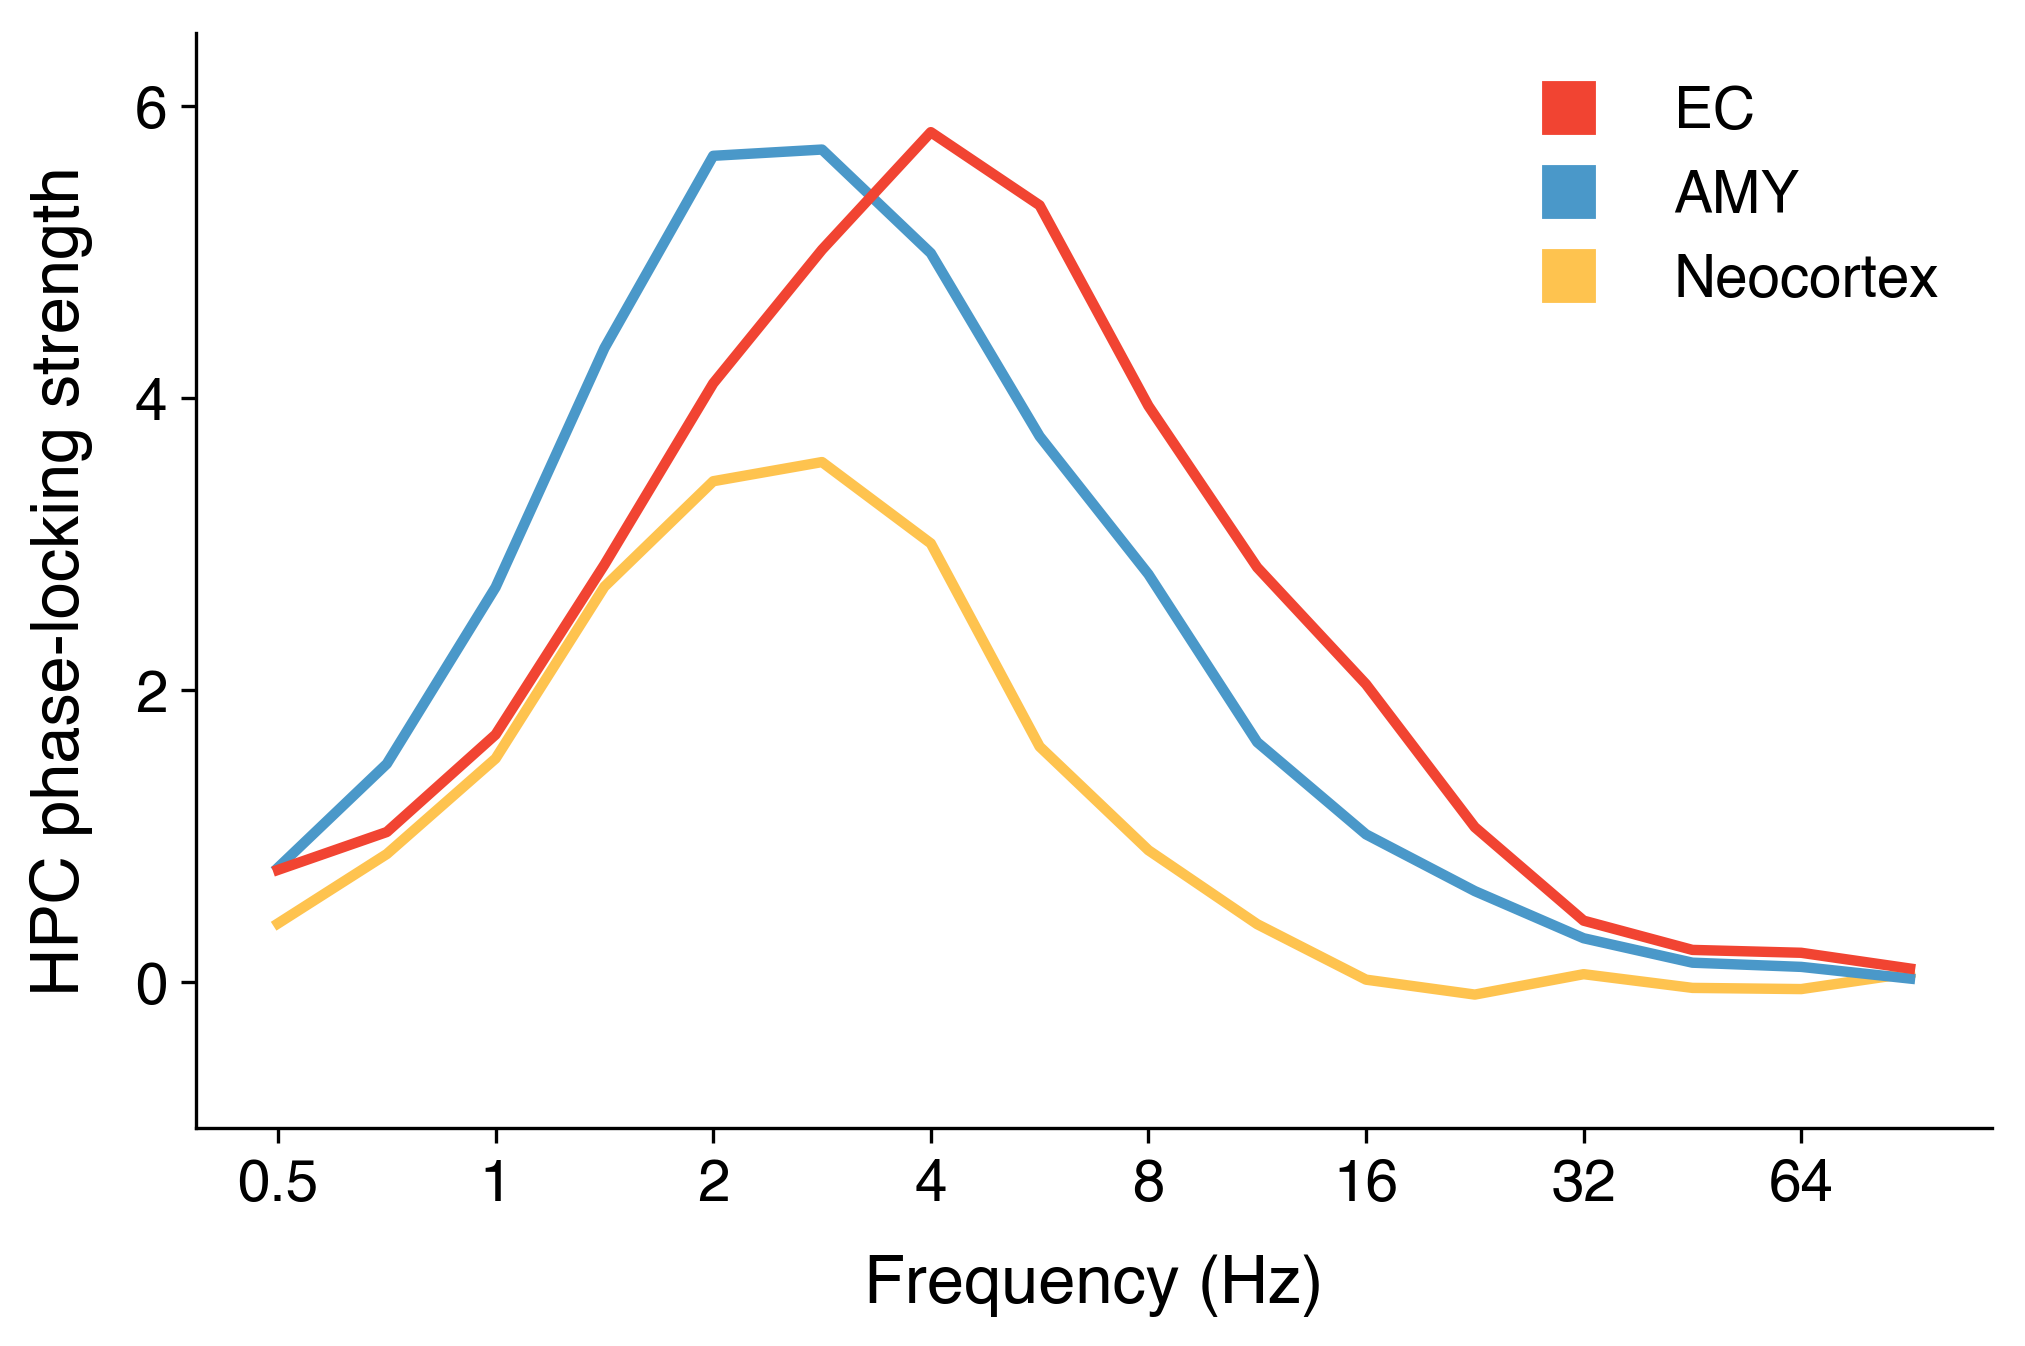

In [1618]:
fig, ax = plt.subplots(1, 1, figsize=(colws[2], colws[2]*0.67), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14
labelfontsize = 16

rois = ['ctx', 'amy', 'ec']
color_inds = [6, 0, 1]

ymax = 6.5
i = 0
for iRoi, roi in enumerate(rois):
    mrls = hpc_pl_df.query("(unit_roi3=='{}') & (same_hem==True)".format(roi)).mrls_z.tolist()
    mrl_means = np.mean(mrls, axis=0)
    ax[i].plot(np.arange(len(freqs)), mrl_means, color=colors[color_inds[iRoi]], linewidth=2.5)
    
ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize)
ax[i].set_ylim([-1, ymax])
ax[i].set_yticks(np.arange(0, ymax, 2, dtype=int))
ax[i].set_yticklabels(np.arange(0, ymax, 2, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=10)
ax[i].set_ylabel('HPC phase-locking strength', fontsize=labelfontsize, labelpad=10)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='EC', markerfacecolor=colors[1], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='AMY', markerfacecolor=colors[0], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Neocortex', markerfacecolor=colors[6], markersize=tickfontsize)]
legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_strength_by_freq_mono_rois2_noerrorbars.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_strength_by_freq_mono_rois2_noerrorbars.png', 
                format='png', dpi=300, bbox_inches='tight')

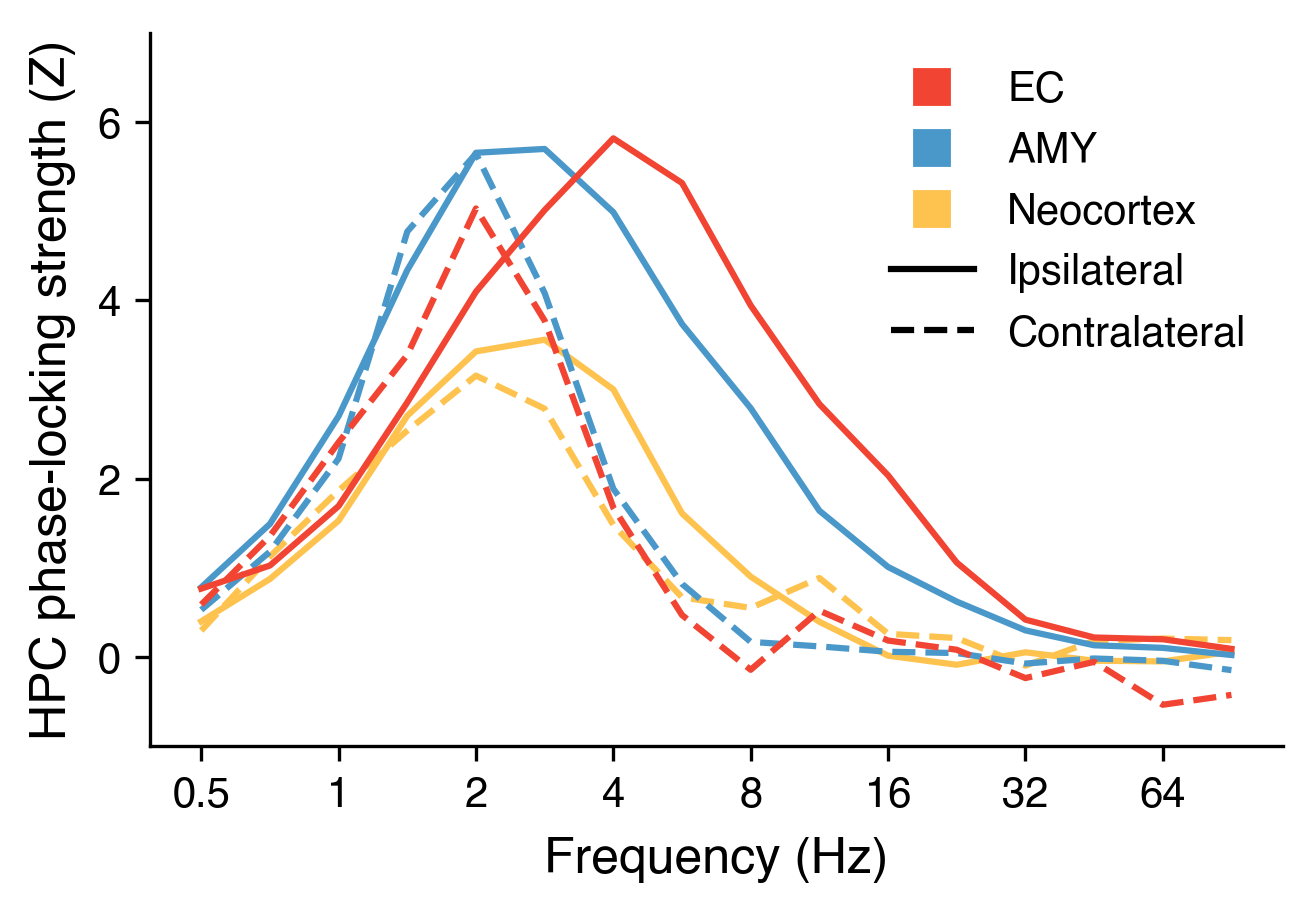

In [1620]:
fig, ax = plt.subplots(1, 1, figsize=(4.48819, 3.14173), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12

mono_rois = ['other', 'amy', 'ec']
color_inds = [6, 0, 1]

i = 0
for iRoi, roi in enumerate(mono_rois):
    for hem in ['contra', 'ipsi']:
        mrls = hpc_pl_df.query("(mono_roi2=='{}')".format('{}_{}'.format(hem, roi))).mrls_z.tolist()
        means = np.mean(mrls, axis=0)
        sems = stats.sem(mrls, axis=0)
        if hem == 'ipsi':
            ax[i].plot(np.arange(len(freqs)), means, color=colors[color_inds[iRoi]], linewidth=1.5)
        else:
            ax[i].plot(np.arange(len(freqs)), means, color=colors[color_inds[iRoi]], linewidth=1.5, linestyle='--')
    
ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize)
ax[i].set_ylim([-1, 7])
ax[i].set_yticks(np.arange(0, 7, 2, dtype=int))
ax[i].set_yticklabels(np.arange(0, 7, 2, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='EC', markerfacecolor=colors[1], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='AMY', markerfacecolor=colors[0], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Neocortex', markerfacecolor=colors[6], markersize=tickfontsize),
                Line2D([0], [0], label='Ipsilateral', color=colors[7], linewidth=1.5),
                Line2D([0], [0], label='Contralateral', color=colors[7], linewidth=1.5, linestyle='--')]
legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_strength_by_freq_mono_rois2_noerrorbars.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_strength_by_freq_mono_rois2_noerrorbars.png', 
                format='png', dpi=300, bbox_inches='tight')

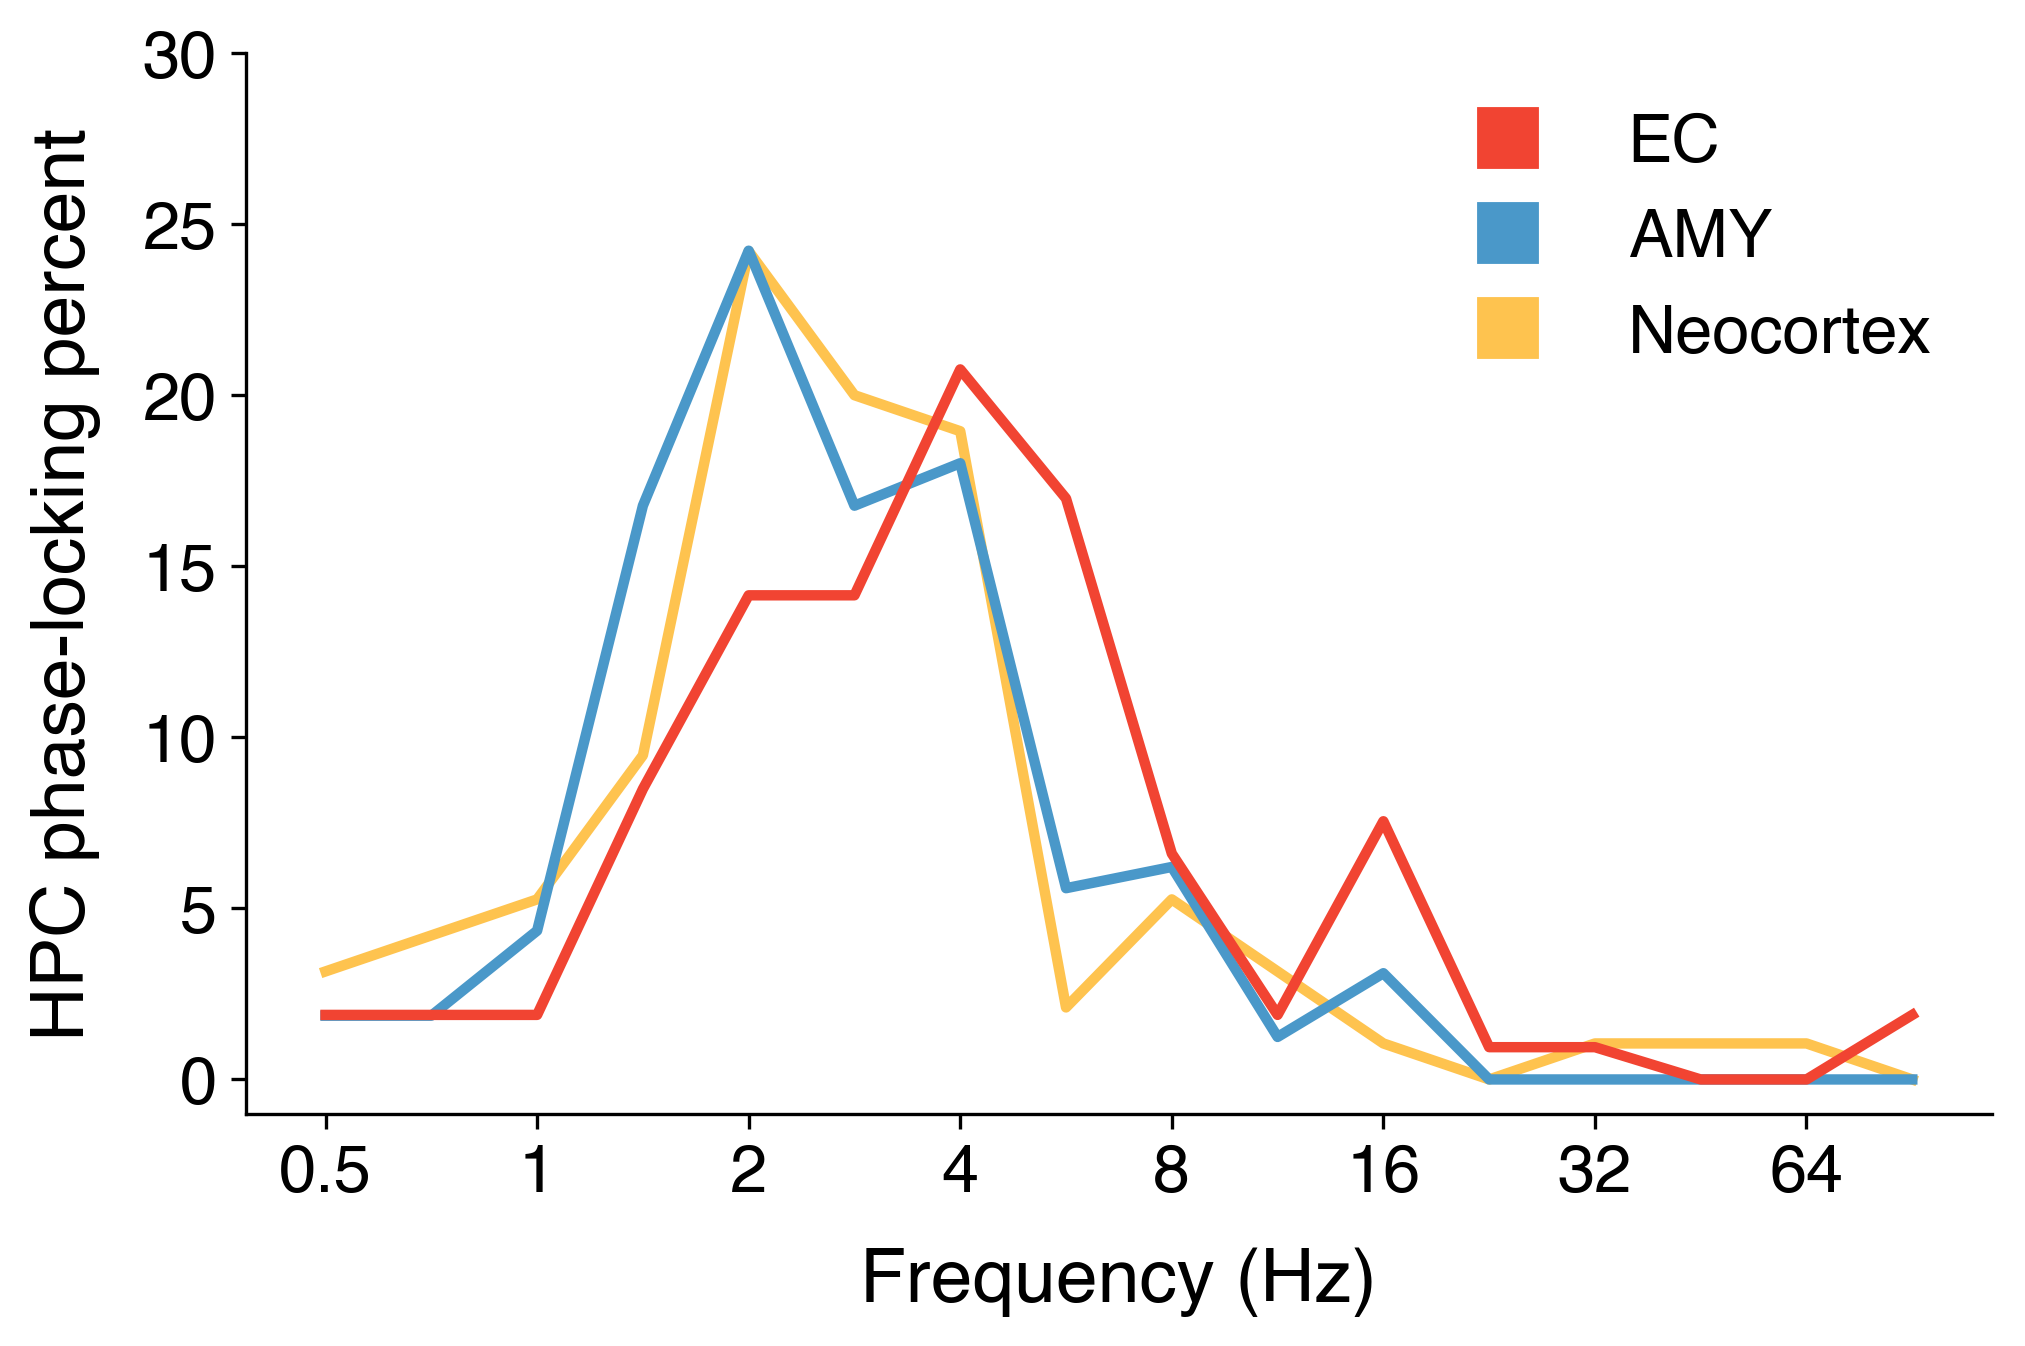

In [1623]:
# Plot the number of neurons with maximum phase-locking to each frequency.
fig, ax = plt.subplots(1, 1, figsize=(colws[2], colws[2]*0.67), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

rois = ['ctx', 'amy', 'ec']
color_inds = [6, 0, 1]

i = 0
ymax = 30
for iRoi, roi in enumerate(rois):
    vals, counts = np.unique(hpc_pl_df.query("(same_hem==True) & (unit_roi3=='{}')".format(roi))['locked_freq_ind_z'], return_counts=True)
    f_counts = dict(zip(vals, counts))
    yvals = np.array([f_counts.get(iFreq, 0) for iFreq in range(len(freqs))])
    ax[i].plot(np.arange(len(freqs)), 100 * yvals / np.sum(yvals), color=colors[color_inds[iRoi]], linewidth=2.5)
    
ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize)
ax[i].set_ylim([-1, ymax])
ax[i].set_yticks(np.arange(0, ymax+1, 5, dtype=int))
ax[i].set_yticklabels(np.arange(0, ymax+1, 5, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=10)
ax[i].set_ylabel('HPC phase-locking percent', fontsize=labelfontsize, labelpad=10)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='EC', markerfacecolor=colors[1], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='AMY', markerfacecolor=colors[0], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Neocortex', markerfacecolor=colors[6], markersize=tickfontsize)]
legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_strength_by_tl_maxfreq_ipsi_rois.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_strength_by_tl_maxfreq_ipsi_rois.png', 
                format='png', dpi=300, bbox_inches='tight')

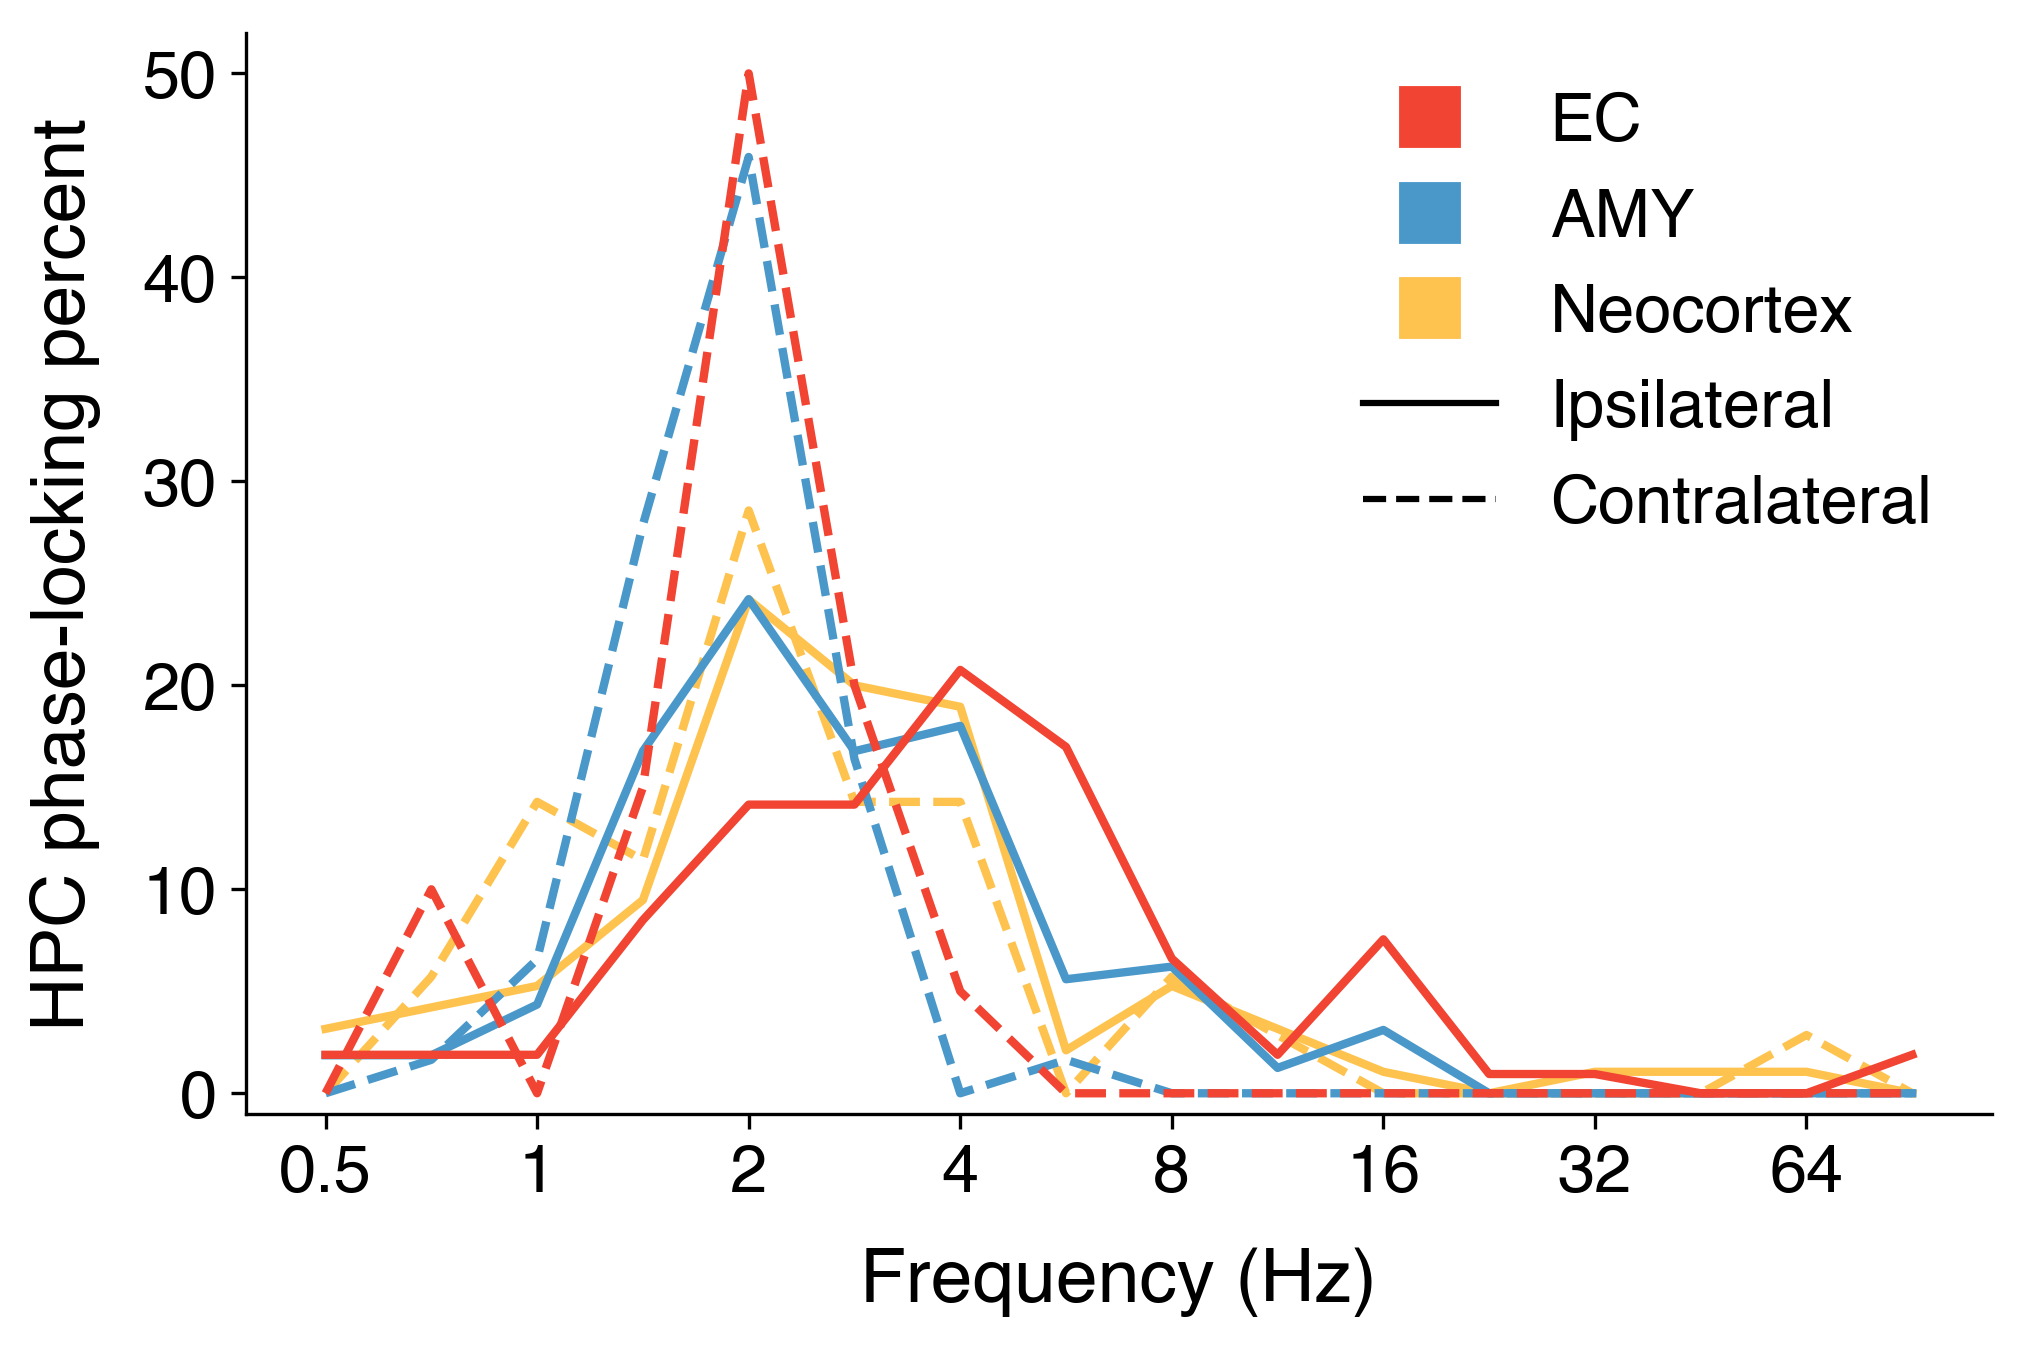

In [1710]:
# Plot the number of neurons with maximum phase-locking to each frequency.
fig, ax = plt.subplots(1, 1, figsize=(6.85039, 6.85039*0.67), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

mono_rois = ['other', 'amy', 'ec']
color_inds = [6, 0, 1]

i = 0
ymax = 0
for iRoi, roi in enumerate(mono_rois):
    for hem in ['contra', 'ipsi']:
        vals, counts = np.unique(hpc_pl_df.query("(mono_roi2=='{}')".format('{}_{}'.format(hem, roi)))['locked_freq_ind_z'], return_counts=True)
        f_counts = dict(zip(vals, counts))
        yvals = np.array([f_counts.get(iFreq, 0) for iFreq in range(len(freqs))])
        ymax = 50 #np.max([ymax] + yvals)
        if hem == 'ipsi':
            ax[i].plot(np.arange(len(freqs)), 100 * yvals / np.sum(yvals), color=colors[color_inds[iRoi]], linewidth=2)
        else:
            ax[i].plot(np.arange(len(freqs)), 100 * yvals / np.sum(yvals), color=colors[color_inds[iRoi]], linewidth=2, linestyle='--')
    
ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize)
ax[i].set_ylim([-1, ymax+2])
ax[i].set_yticks(np.arange(0, ymax+2, 10, dtype=int))
ax[i].set_yticklabels(np.arange(0, ymax+2, 10, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=10)
ax[i].set_ylabel('HPC phase-locking percent', fontsize=labelfontsize, labelpad=10)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='EC', markerfacecolor=colors[1], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='AMY', markerfacecolor=colors[0], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Neocortex', markerfacecolor=colors[6], markersize=tickfontsize),
                Line2D([0], [0], label='Ipsilateral', color=colors[7], linewidth=1.5),
                Line2D([0], [0], label='Contralateral', color=colors[7], linewidth=1.5, linestyle='--')]
legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_strength_by_tl_maxfreq_mono_rois2_noerrorbars.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_strength_by_tl_maxfreq_mono_rois2_noerrorbars.png', 
                format='png', dpi=300, bbox_inches='tight')

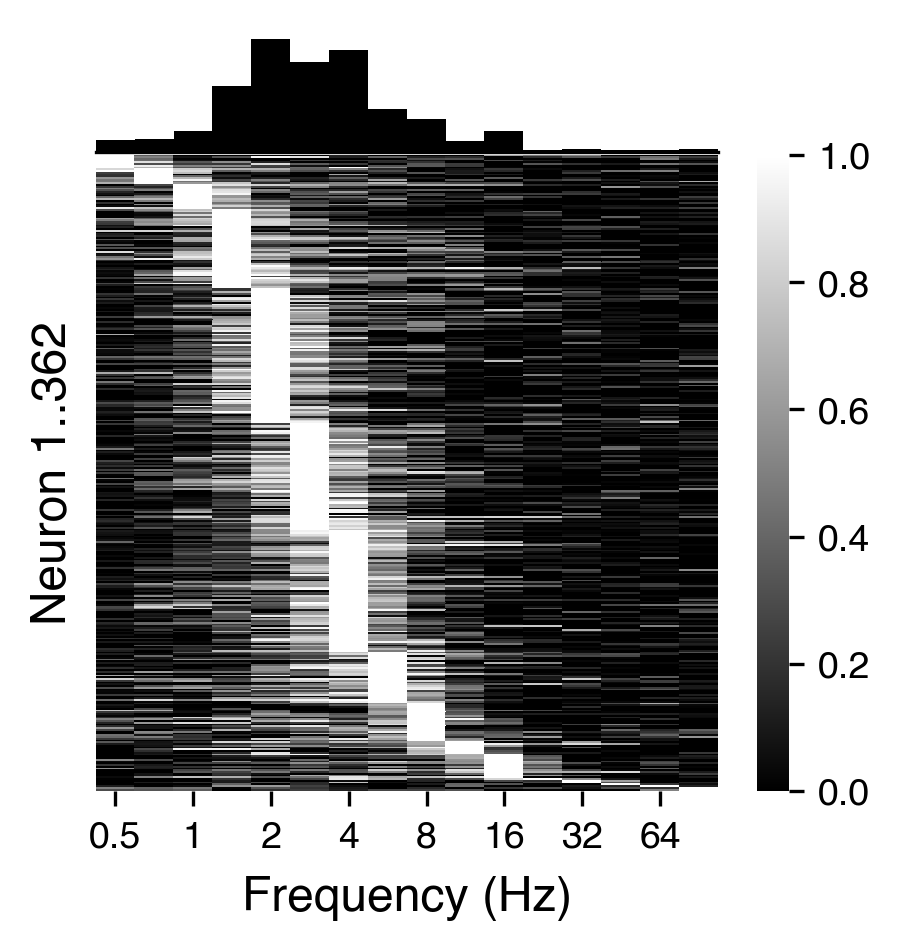

In [1641]:
hpc_tl_mrls = np.array(pl_df
                       .query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)")
                       .sort_values(['locked_freq_ind_z'], ascending=True)['mrls_z']
                       .tolist())

fig = plt.figure(figsize=(colws[1], colws[1]*1), dpi=300)
ax = [plt.subplot2grid((50, 50), (0, 0), rowspan=8, colspan=40),
      plt.subplot2grid((50, 50), (8, 0), rowspan=45, colspan=50)]

tickfontsize = 9
labelfontsize = 11.5

hpc_d = (pl_df
         .query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)")
         .groupby('locked_freq_ind_z')
         .size()
         .to_dict())
counts = []
for i in np.arange(len(freqs)):
    counts.append([hpc_d.get(i, 0)])
counts = pd.DataFrame(counts, columns=['hpc']).reset_index()

i = 0
ax[i].bar(counts.index+0.5, counts.hpc, width=1, color='k')
# locked_freqs = np.array(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")['locked_freq_ind_z'].tolist())
# ax[i].axvline(np.mean(locked_freqs) + 0.5, color=colors[1], linewidth=1, linestyle='-')
ax[i].set_xlim([0, len(freqs)])
ax[i].set_xticks(np.arange(len(freqs))[::2]+0.5)
ax[i].set_xticklabels('')
ax[i].set_xticks([])
ax[i].set_yticks([])
ax[i].set_xlabel('')
ax[i].set_ylabel('')
ax[i].spines['left'].set_visible(False)
ax[i].grid(False)
# ax[i].annotate('{:.1f} Hz'.format(2**((np.mean(locked_freqs)/2) - 1)), xy=(0.5, 0.75), 
#                                   color='k', xycoords='axes fraction', fontsize=tickfontsize)

i = 1
sns.heatmap((hpc_tl_mrls[:, :].T / np.max(hpc_tl_mrls, axis=1)).T, ax=ax[i], 
             vmin=0, vmax=1, cmap='gray', cbar=True)
ax[i].axvline(x=200, color='k', linewidth=0.75, alpha=1)
ax[i].set_xlim([0, len(freqs)])
ax[i].set_xticks(np.arange(len(freqs))[::2]+0.5)
ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_yticks([])
ax[i].set_ylabel('Neuron 1..{}'.format(counts['hpc'].sum()), fontsize=labelfontsize, labelpad=5)
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(np.round(np.linspace(0, 1, 6), 1))
# cbar.set_label('Norm. phase-locking strength', fontsize=labelfontsize, labelpad=5)

# fig.tight_layout(pad=0, h_pad=0)

if False:
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/phase_locking_by_freq_1.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/phase_locking_by_freq_1.png', 
                format='png', dpi=600, bbox_inches='tight')

In [1869]:
pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)").groupby('unit_roi3').agg({'unit': len, 'locked_freq_ind_z': lambda x: })

unit
unit_roi3      
amy         161
ctx          95
ec          106

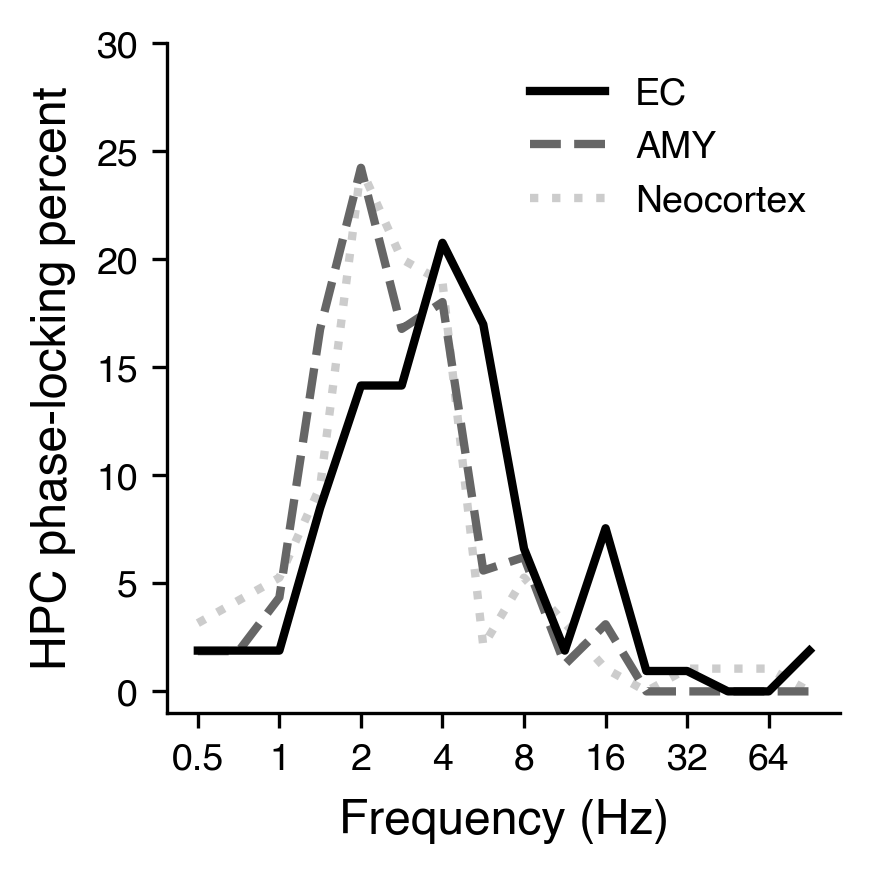

In [1642]:
# Plot the number of neurons with maximum phase-locking to each frequency.
fig, ax = plt.subplots(1, 1, figsize=(colws[1], colws[1]*1), dpi=300)
ax = np.ravel(ax)

tickfontsize = 9
labelfontsize = 11.5

rois = ['ctx', 'amy', 'ec']
colors_ = [colors[6], colors[0], colors[1]]
colors_ = ['#29335C', '#f37735', '#43AA8B']
colors_ = ['#cccccc', '#666666', '#000000']
linestyles = ['dotted', '--', '-']

i = 0
ymax = 30
for iRoi, roi in enumerate(rois):
    vals, counts = np.unique(pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True) & (unit_roi3=='{}')".format(roi))['locked_freq_ind_z'], return_counts=True)
    f_counts = dict(zip(vals, counts))
    yvals = np.array([f_counts.get(iFreq, 0) for iFreq in range(len(freqs))])
    ax[i].plot(np.arange(len(freqs)), 100 * yvals / np.sum(yvals), color=colors_[iRoi], linestyle=linestyles[iRoi], linewidth=2)
    
ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize)
ax[i].set_ylim([-1, ymax])
ax[i].set_yticks(np.arange(0, ymax+1, 5, dtype=int))
ax[i].set_yticklabels(np.arange(0, ymax+1, 5, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC phase-locking percent', fontsize=labelfontsize, labelpad=5)

# custom_lines = [Line2D([0], [0], marker='s', color='w', label='EC', markerfacecolor=colors_[2], markersize=tickfontsize),
#                 Line2D([0], [0], marker='s', color='w', label='AMY', markerfacecolor=colors_[1], markersize=tickfontsize),
#                 Line2D([0], [0], marker='s', color='w', label='Neocortex', markerfacecolor=colors_[0], markersize=tickfontsize)]
custom_lines = [Line2D([0], [0], label='EC', color=colors_[2], linewidth=2, linestyle=linestyles[2]),
                Line2D([0], [0], label='AMY', color=colors_[1], linewidth=2, linestyle=linestyles[1]),
                Line2D([0], [0], label='Neocortex', color=colors_[0], linewidth=2, linestyle=linestyles[0])]
legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 0.9, 0.9])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/phase_locking_by_freq_2.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/phase_locking_by_freq_2.png', 
                format='png', dpi=300, bbox_inches='tight')

In [1729]:
(pl_df
 .query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True) & (2<=locked_freq_ind_z<=8)")
 .groupby('subj')
 .agg({'unit': len}))

unit
subj      
U369    18
U370     6
U371    51
U372    15
U373    11
U374     3
U379     2
U380    26
U381    37
U384    27
U385    35
U387    23
U390     5
U393    12
U394    10
U395    27
U396     9

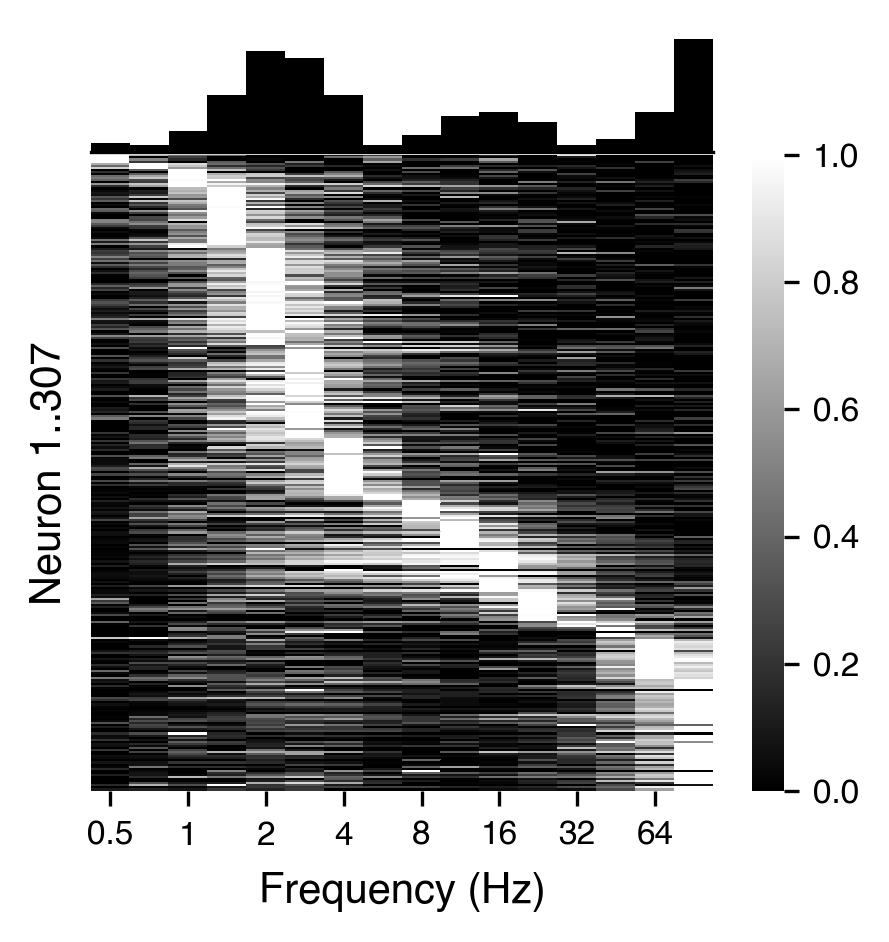

In [1643]:
hpc_tl_mrls = np.array(pl_df
                       .query("(sig_z_fdr==True) & (edge=='hpc-local')")
                       .sort_values(['locked_freq_ind_z'], ascending=True)
                       .apply(lambda x: x['tl_mrls_z'][:, list(time_steps_ms).index(x['pl_time_shift'])], axis=1)
                       .tolist())

fig = plt.figure(figsize=(colws[1], colws[1]*1), dpi=300)
ax = [plt.subplot2grid((50, 50), (0, 0), rowspan=8, colspan=40),
      plt.subplot2grid((50, 50), (8, 0), rowspan=45, colspan=50)]

tickfontsize = 8
labelfontsize = 10

hpc_d = (pl_df
         .query("(sig_z_fdr==True) & (edge=='hpc-local')")
         .groupby('locked_freq_ind_z')
         .size()
         .to_dict())
counts = []
for i in np.arange(len(freqs)):
    counts.append([hpc_d.get(i, 0)])
counts = pd.DataFrame(counts, columns=['hpc']).reset_index()

i = 0
ax[i].bar(counts.index+0.5, counts.hpc, width=1, color='k')
locked_freqs = np.array(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-local')")['locked_freq_ind_z'].tolist())
# ax[i].axvline(np.mean(locked_freqs) + 0.5, color=colors[1], linewidth=1, linestyle='-')
ax[i].set_xlim([0, len(freqs)])
ax[i].set_xticks(np.arange(len(freqs))[::2]+0.5)
ax[i].set_xticklabels('')
ax[i].set_xticks([])
ax[i].set_yticks([])
ax[i].set_xlabel('')
ax[i].set_ylabel('')
ax[i].spines['left'].set_visible(False)
ax[i].grid(False)
# ax[i].annotate('{:.1f} Hz'.format(2**((np.mean(locked_freqs)/2) - 1)), xy=(0.5, 0.75), 
#                                   color='k', xycoords='axes fraction', fontsize=tickfontsize)

i = 1
sns.heatmap((hpc_tl_mrls[:, :].T / np.max(hpc_tl_mrls, axis=1)).T, ax=ax[i], 
             vmin=0, vmax=1, cmap='gray', cbar=True)
ax[i].axvline(x=200, color='k', linewidth=0.75, alpha=1)
ax[i].set_xlim([0, len(freqs)])
ax[i].set_xticks(np.arange(len(freqs))[::2]+0.5)
ax[i].set_xticklabels([str(x).rstrip('.0') for x in np.round(freqs[::2], 1)], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_yticks([])
ax[i].set_ylabel('Neuron 1..{}'.format(counts['hpc'].sum()), fontsize=labelfontsize, labelpad=5)
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(np.round(np.linspace(0, 1, 6), 1))
# cbar.set_label('Norm. phase-locking strength', fontsize=labelfontsize, labelpad=5)

# fig.tight_layout(pad=0, h_pad=0)

if False:
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/phase_locking_by_freq_HPC_neurons.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/phase_locking_by_freq_HPC_neurons.png', 
                format='png', dpi=600, bbox_inches='tight')

## Phase-locking percent by subject

In [1522]:
#subj_df['subj_sess_chan_ind'] = ['{}_{}'.format(subj_df['subj_sess'].tolist()[iRow], subj_df['chan_ind'].tolist()[iRow]) for iRow in range(len(subj_df))]

In [1543]:
np.unique(pd.merge(subj_df, df_, how='left', on='subj_sess_chan_ind')['subj_sess_unit'], return_counts=True)

(array([ 1.,  2.,  3., ..., nan, nan, nan]),
 array([565, 227,  58, ...,   1,   1,   1]))

In [1559]:
#subj_df.query("(subj_sess=={})".format(sessions))

In [1572]:
subj_df.columns

Index(['Unnamed: 0', 'subj_sess', 'subj', 'sess', 'chan_ind', 'chan',
       'location', 'sess_duration', 'raw_lfp_file', 'spike_times_file',
       'input_files_exist', 'process_chan', 'n_clusters', 'proc_lfp_file',
       'session_spikes_file', 'subj_sess_chan_ind', 'n_neurons'],
      dtype='object')

In [1583]:
sessions = list(np.unique(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)")['subj_sess']))
df_ = pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby(['subj_sess', 'unit_chan_ind']).agg({'subj_sess_unit': lambda x: len(np.unique(x))}).reset_index().copy()
df_['subj_sess_chan_ind'] = ['{}_{}'.format(df_['subj_sess'].tolist()[iRow], df_['unit_chan_ind'].tolist()[iRow]) for iRow in range(len(df_))]

subj_df['subj_sess_chan_ind'] = ['{}_{}'.format(subj_df['subj_sess'].tolist()[iRow], subj_df['chan_ind'].tolist()[iRow]) for iRow in range(len(subj_df))]
subj_df['n_neurons'] = [0 if np.isnan(x) else x for x in pd.merge(subj_df, df_, how='left', on='subj_sess_chan_ind')['subj_sess_unit']]
neurons_per_chan = np.sort(subj_df
                           .query("(subj_sess=={}) & (location!={})".format(sessions, ['LAH', 'LMH', 'LPH', 'RAH', 'RMH', 'RPH']))
                           .groupby('subj_sess_chan_ind')
                           .agg({'n_neurons': lambda x: int(x)})
                           .reset_index()['n_neurons'].tolist())
print('{:.1f} $\pm$ {:.1f} neurons per channel'.format(np.mean(neurons_per_chan), np.std(neurons_per_chan)))

0.6 $\pm$ 0.8 neurons per channel


In [1582]:
neurons_per_subj = np.sort(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby('subj').agg({'subj_sess_unit': lambda x: len(np.unique(x))})['subj_sess_unit'].tolist())

print('{:.1f} $\pm$ {:.1f} neurons per subject'.format(np.mean(neurons_per_subj), np.std(neurons_per_subj)))

68.5 $\pm$ 46.4 neurons per subject


In [1592]:
subj_df.query("(subj_sess=={}) & (location=={})".format(sessions, ['LAH', 'LMH', 'LPH', 'RAH', 'RMH', 'RPH'])).groupby('subj').agg({'location': lambda x: len(np.unique(x))}).sum()

location    36
dtype: int64

In [1596]:
pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby('subj').agg({'lfp_hemroi': lambda x: len(np.unique(x))}).sum()
np.unique(subj_df['subj_sess'])

array(['U367_env2', 'U369_env1', 'U369_env2', 'U370_env1', 'U371_env1',
       'U371_env2', 'U371_env3', 'U372_ses1', 'U372_ses2', 'U373_ses1',
       'U373_ses2', 'U373_ses3', 'U374_ses1', 'U374_ses2', 'U379_ses1',
       'U380_ses1a', 'U380_ses2', 'U380_ses3', 'U381_ses1', 'U381_ses2',
       'U381_ses3', 'U384_ses1', 'U384_ses2', 'U384_ses3', 'U385_ses1',
       'U385_ses2', 'U385_ses3', 'U385_ses4', 'U386_ses1', 'U386_ses2',
       'U387_ses1', 'U387_ses2', 'U387_ses3', 'U390_ses1', 'U390_ses2',
       'U390_ses3', 'U390_ses4', 'U392_ses1', 'U393_ses2', 'U394_ses1',
       'U394_ses3', 'U395_ses1', 'U395_ses2', 'U395_ses3', 'U396_ses2',
       'U396_ses3'], dtype=object)

In [1460]:
def f(x):
    n_low_theta = np.sum((x>=2) & (x<=6))
    n_high_theta = np.sum((x>=7) & (x<=9))
    n_theta = n_low_theta + n_high_theta
    pct_low_theta = n_low_theta/n_theta
    return [n_theta, pct_low_theta]
(pl_df
 .query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)")
 .groupby('subj')
 .agg({'unit': len, 'locked_freq_ind_z': lambda x: f(x)}))

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


unit         locked_freq_ind_z
subj                                
U369    19  [18, 0.5555555555555556]
U370     8   [7, 0.5714285714285714]
U371    57   [51, 0.803921568627451]
U372    17                 [15, 0.8]
U373    14  [11, 0.7272727272727273]
U374     3   [3, 0.6666666666666666]
U379     2                  [2, 1.0]
U380    33  [29, 0.8620689655172413]
U381    40  [39, 0.8461538461538461]
U384    32  [28, 0.6785714285714286]
U385    38  [35, 0.9714285714285714]
U387    25  [23, 0.9130434782608695]
U390     5                  [5, 1.0]
U392     2                  [0, nan]
U393    12                 [12, 1.0]
U394    11                 [10, 0.9]
U395    32  [27, 0.7407407407407407]
U396    12                  [9, 1.0]

In [1383]:
# What percent of cells were phase-locked at the subject level?
df = (pl_df
      .query("(edge=='ctx-hpc') & (same_hem==True)")
      .groupby('subj_sess_unit')
      .agg({'subj': lambda x: list(x)[0], 'subj_sess': lambda x: list(x)[0], 'unit': len, 'sig_z_fdr': lambda x: np.sum(x)>0})
      .groupby(['subj'])
      .agg({'subj_sess': lambda x: list(np.unique(x)), 'unit': len, 'sig_z_fdr': lambda x: int(np.sum(x))})
      .sort_values('unit', ascending=False))
df['pct'] = df.apply(lambda x: np.round(100 * (x.sig_z_fdr/x.unit), 1), axis=1)
print('Mean: {:.1f}%, std: {:.1f}%'.format(np.mean(df['pct']), np.std(df['pct'])))
df

Mean: 31.5%, std: 17.3%


subj_sess  unit  sig_z_fdr   pct
subj                                                                     
U381             [U381_ses1, U381_ses2, U381_ses3]   149         40  26.8
U380            [U380_ses1a, U380_ses2, U380_ses3]   148         33  22.3
U384             [U384_ses1, U384_ses2, U384_ses3]   135         32  23.7
U371             [U371_env1, U371_env2, U371_env3]   122         57  46.7
U385  [U385_ses1, U385_ses2, U385_ses3, U385_ses4]   111         38  34.2
U373             [U373_ses1, U373_ses2, U373_ses3]   103         14  13.6
U369                        [U369_env1, U369_env2]    84         19  22.6
U395             [U395_ses1, U395_ses2, U395_ses3]    63         32  50.8
U379                                   [U379_ses1]    59          2   3.4
U372                        [U372_ses1, U372_ses2]    45         17  37.8
U387             [U387_ses1, U387_ses2, U387_ses3]    45         25  55.6
U390  [U390_ses1, U390_ses2, U390_ses3, U390_ses4]    31          5  16.1
U393                                   [U393_ses2]    31         12  38.7
U394                        [U394_ses1, U394_ses3]    30         11  36.7
U374                        [U374_ses1, U374_ses2]    26          3  11.5
U370                                   [U370_env1]    24          8  33.3
U396                        [U396_ses2, U396_ses3]    16         12  75.0
U392                                   [U392_ses1]    11          2  18.2

In [1382]:
# What percent of cells were phase-locked at the subject level?
df = (pl_df
      .query("(edge=='ctx-hpc') & (same_hem==True)")
      .groupby('subj_sess_unit')
      .agg({'subj_sess': lambda x: list(x)[0], 'unit': len, 'sig_z_fdr': lambda x: np.sum(x)>0})
      .groupby(['subj_sess'])
      .agg({'unit': len, 'sig_z_fdr': lambda x: int(np.sum(x))})
      .sort_values('unit', ascending=False))
df['pct'] = df.apply(lambda x: np.round(100 * (x.sig_z_fdr/x.unit), 1), axis=1)
print('Mean: {:.1f}%, std: {:.1f}%'.format(np.mean(df['pct']), np.std(df['pct'])))
df

Mean: 31.9%, std: 19.6%


unit  sig_z_fdr   pct
subj_sess                        
U381_ses3     60         14  23.3
U379_ses1     59          2   3.4
U380_ses1a    57         12  21.1
U380_ses2     53         12  22.6
U369_env1     51         13  25.5
U384_ses1     48         14  29.2
U371_env3     48         16  33.3
U381_ses2     47         15  31.9
U384_ses2     45         11  24.4
U371_env1     43         22  51.2
U381_ses1     42         11  26.2
U384_ses3     42          7  16.7
U373_ses1     38          4  10.5
U380_ses3     38          9  23.7
U373_ses3     34          5  14.7
U369_env2     33          6  18.2
U385_ses1     32         13  40.6
U373_ses2     31          5  16.1
U393_ses2     31         12  38.7
U371_env2     31         19  61.3
U385_ses2     29         11  37.9
U394_ses1     28         11  39.3
U372_ses2     27          9  33.3
U395_ses2     26         13  50.0
U385_ses4     26          7  26.9
U385_ses3     24          7  29.2
U370_env1     24          8  33.3
U395_ses1     22         10  45.5
U372_ses1     18          8  44.4
U387_ses3     17          7  41.2
U387_ses1     16          9  56.2
U395_ses3     15          9  60.0
U390_ses4     15          1   6.7
U374_ses1     14          1   7.1
U374_ses2     12          2  16.7
U387_ses2     12          9  75.0
U392_ses1     11          2  18.2
U396_ses3      9          6  66.7
U396_ses2      7          6  85.7
U390_ses3      6          3  50.0
U390_ses2      6          1  16.7
U390_ses1      4          0   0.0
U394_ses3      2          0   0.0

In [683]:
np.unique(pl_df
          .query("(edge=='ctx-hpc')")
          .groupby(['unit_roi3', 'subj_sess_unit'])
          .agg({'subj': lambda x: list(x)[0], 'unit': len, 'sig_z_fdr': lambda x: np.sum(x)>0})
          .groupby(['subj', 'unit_roi3'])
          .agg({'unit': len, 'sig_z_fdr': np.sum})
          .reset_index()
          .groupby('subj')
          .agg({'unit_roi3': len, 'unit': np.sum, 'sig_z_fdr': np.sum})['unit_roi3'],
          return_counts=True)

(array([1, 2, 3]), array([1, 8, 9]))

In [195]:
# ADD FIGURE

## Dual phase-locking to ipsi- and contralateral HPC

In [99]:
# 418/1348 or 31.0% cells were phase-locked to at least one HPC region at some frequency.
#
# 274 cells were phase-locked to only one HPC region, among which 26 cells are from 
# subjects (U373, U374) who only had one HPC depth electrode.
#
# 145 cells were phase-locked to more than one HPC region.
#
# So excluding the subjs with only one HPC region, 145/419 or 34.6% of cells 
# were phase-locked to multiple HPC regions.
df = (pl_df
      .query("(edge=='ctx-hpc') & (sig_z_fdr==True)") #  & (unit_roi3==['ec', 'amy'])
      .reset_index()
      .groupby('subj_sess_unit')
      .agg({'unit': len, 
            'unit_fr': lambda x: np.round(np.unique(x), 1), 
            'tl_locked_mrl_z': np.max, 
            'same_hem': lambda x: list(x),
            'unit_hemroi': lambda x: np.unique(x), 
            'lfp_hemroi': lambda x: list(x), 
            'pl_strength': lambda x: list(x), 
            'pl_freq': lambda x: list(x),
            'pl_time_shift': lambda x: list(x),
            'pl_latency': lambda x: list(x),
            'index': lambda x: list(x)})
      .query("(unit==2)")
      .reset_index())
df['lfp_hemroi_0'] = df['lfp_hemroi'].apply(lambda x: x[0])
df['lfp_hemroi_1'] = df['lfp_hemroi'].apply(lambda x: x[1])
units = df.subj_sess_unit.tolist()

# Get within-neuron matching pairs.
# keys = ['locked_mrl_z', 'locked_freq_ind_z', 'tl_locked_time_z_abs']
# keys = ['tl_locked_mrl_z', 'locked_freq_ind_z', 'tl_locked_time_z', 'tl_locked_time_z_abs']
keys = ['locked_mrl_z', 'locked_freq_ind_z', 'pl_strength', 'pl_freq', 'pl_time_shift', 'pl_latency']
dat = od()
for key in keys:
    dat[key] = []
    for unit in units:
        if key == 'pl_time_shift':
            dat[key].append([-pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True) & (subj_sess_unit=='{}')".format(unit)).iloc[0][key],
                             -pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==False) & (subj_sess_unit=='{}')".format(unit)).iloc[0][key]])
        else:
            dat[key].append([pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True) & (subj_sess_unit=='{}')".format(unit)).iloc[0][key],
                             pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==False) & (subj_sess_unit=='{}')".format(unit)).iloc[0][key]])
    dat[key] = np.array(dat[key]).astype(np.float32)
    
print('{} cells with bilateral phase-locking'.format(len(units)))

84 cells with bilateral phase-locking


In [1721]:
ipsi_units = pl_df.query("(edge=='ctx-hpc') & (same_hem==True)")['subj_sess_unit'].tolist()
np.unique(pl_df.query("(edge=='ctx-hpc') & (same_hem==False) & (sig_z_fdr==True) & (subj_sess_unit=={})".format(ipsi_units))['locked_freq_ind_z'], return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 14], dtype=uint8),
 array([ 5,  9, 22, 45, 18,  6,  1,  2,  1,  1]))

In [1722]:
freqs

array([ 0.5       ,  0.70710678,  1.        ,  1.41421356,  2.        ,
        2.82842712,  4.        ,  5.65685425,  8.        , 11.3137085 ,
       16.        , 22.627417  , 32.        , 45.254834  , 64.        ,
       90.50966799])

In [100]:
# Is the correlation for per-spike phase-locking between ipsilateral and
# contralateral connections from the same neuron greater than would be
# expected by chance?
start_time = time()

n_perms = 1000

bilat_pl = []
for unit in units:
    offset_ipsi = pl_df.query("(same_hem==True) & (subj_sess_unit=='{}')".format(unit)).iloc[0]['phase_offsets'].copy()
    offset_contra = pl_df.query("(same_hem==False) & (subj_sess_unit=='{}')".format(unit)).iloc[0]['phase_offsets'].copy()
    roi = pl_df.query("(subj_sess_unit=='{}')".format(unit)).iloc[0]['unit_roi3']
    
    r = stats.pearsonr(offset_ipsi, offset_contra)[0]
    
    # Circ-shift one of the phase offset vectors.
    r_null = []
    for iPerm in range(n_perms):
        np.random.shuffle(offset_contra)
        r_null.append(stats.pearsonr(offset_ipsi, offset_contra)[0])
    r_null = np.array(r_null)
    
    p = (1 + np.sum(r_null >= r)) / (1 + n_perms)
    
    bilat_pl.append([unit, roi, r, p])
bilat_pl = pd.DataFrame(bilat_pl, columns=['subj_sess_unit', 'unit_roi3', 'phase_offset_r', 'phase_offset_p'])

# FDR correct p-values.
alpha = 0.05
bilat_pl['phase_offset_sig_fdr'] = sm.stats.multipletests(bilat_pl['phase_offset_p'], alpha=alpha, 
                                                          method='fdr_bh', is_sorted=False, returnsorted=False)[0]

# Add in other columns of interest (ipsi - contra).
for key in keys:
    bilat_pl[key] = dat[key][:, 0] - dat[key][:, 1]
    
print('Done in {:.2f} secs'.format(time() - start_time))

Done in 29.68 secs


In [101]:
print('{}/{} ({:.1f}%) neurons have correlated phase offsets (mean r={:.2f})'
      .format(np.sum(bilat_pl['phase_offset_sig_fdr']), 
              len(bilat_pl), 
              100 * np.sum(bilat_pl['phase_offset_sig_fdr'])/len(bilat_pl), 
              np.mean(bilat_pl['phase_offset_r'])))

17/84 (20.2%) neurons have correlated phase offsets (mean r=0.02)


In [213]:
sm.stats.multipletests([5.757976203725324e-06, 2.618387711334124e-07, 0.48822702864836987, 0.02255031873689226], method='holm')

(array([ True,  True, False,  True]),
 array([1.72739286e-05, 1.04735508e-06, 4.88227029e-01, 4.51006375e-02]),
 0.012741455098566168,
 0.0125)

In [830]:
for key, vals in dat.items():
    print('** {} **{}\n'.format(key, stats.pearsonr(vals[:, 0], vals[:, 1])))

** pl_strength **(0.38015753, 0.0003612295303522472)

** pl_freq **(0.35243842, 0.0010092826155645239)

** pl_time_shift **(-0.0099825, 0.928189899325607)

** pl_latency **(-0.034845714, 0.7530073021936095)



In [102]:
bilat_pl.groupby('unit_roi3').size()

unit_roi3
amy    46
ctx    22
ec     16
dtype: int64

In [107]:
len(bilat_pl['subj_sess_unit'].tolist()), dfx.columns

(84, Index(['subj', 'subj_sess_unit', 'same_hem', 'unit_roi3', 'locked_mrl_z',
        'locked_freq_ind_z'],
       dtype='object'))

In [108]:
cols = ['subj', 'subj_sess_unit', 'same_hem', 'unit_roi3', 'locked_mrl_z', 'locked_freq_ind_z']
dfx = pl_df.query("(edge=='ctx-hpc') & (subj_sess_unit=={})".format(bilat_pl['subj_sess_unit'].tolist()))[cols].reset_index(drop=True).copy()
# dfx['pl_time_shift'] = -dfx['pl_time_shift'] # flip times back (positive values = spikes precede LFP)
if False:
    fname = '/home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/metadata/bilat_pl_neuron_stats.csv'.format(len(dfx))
    dfx.to_csv(fname, index=False)
    print('Saved {}'.format(fname))

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/metadata/bilat_pl_neuron_stats.csv


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


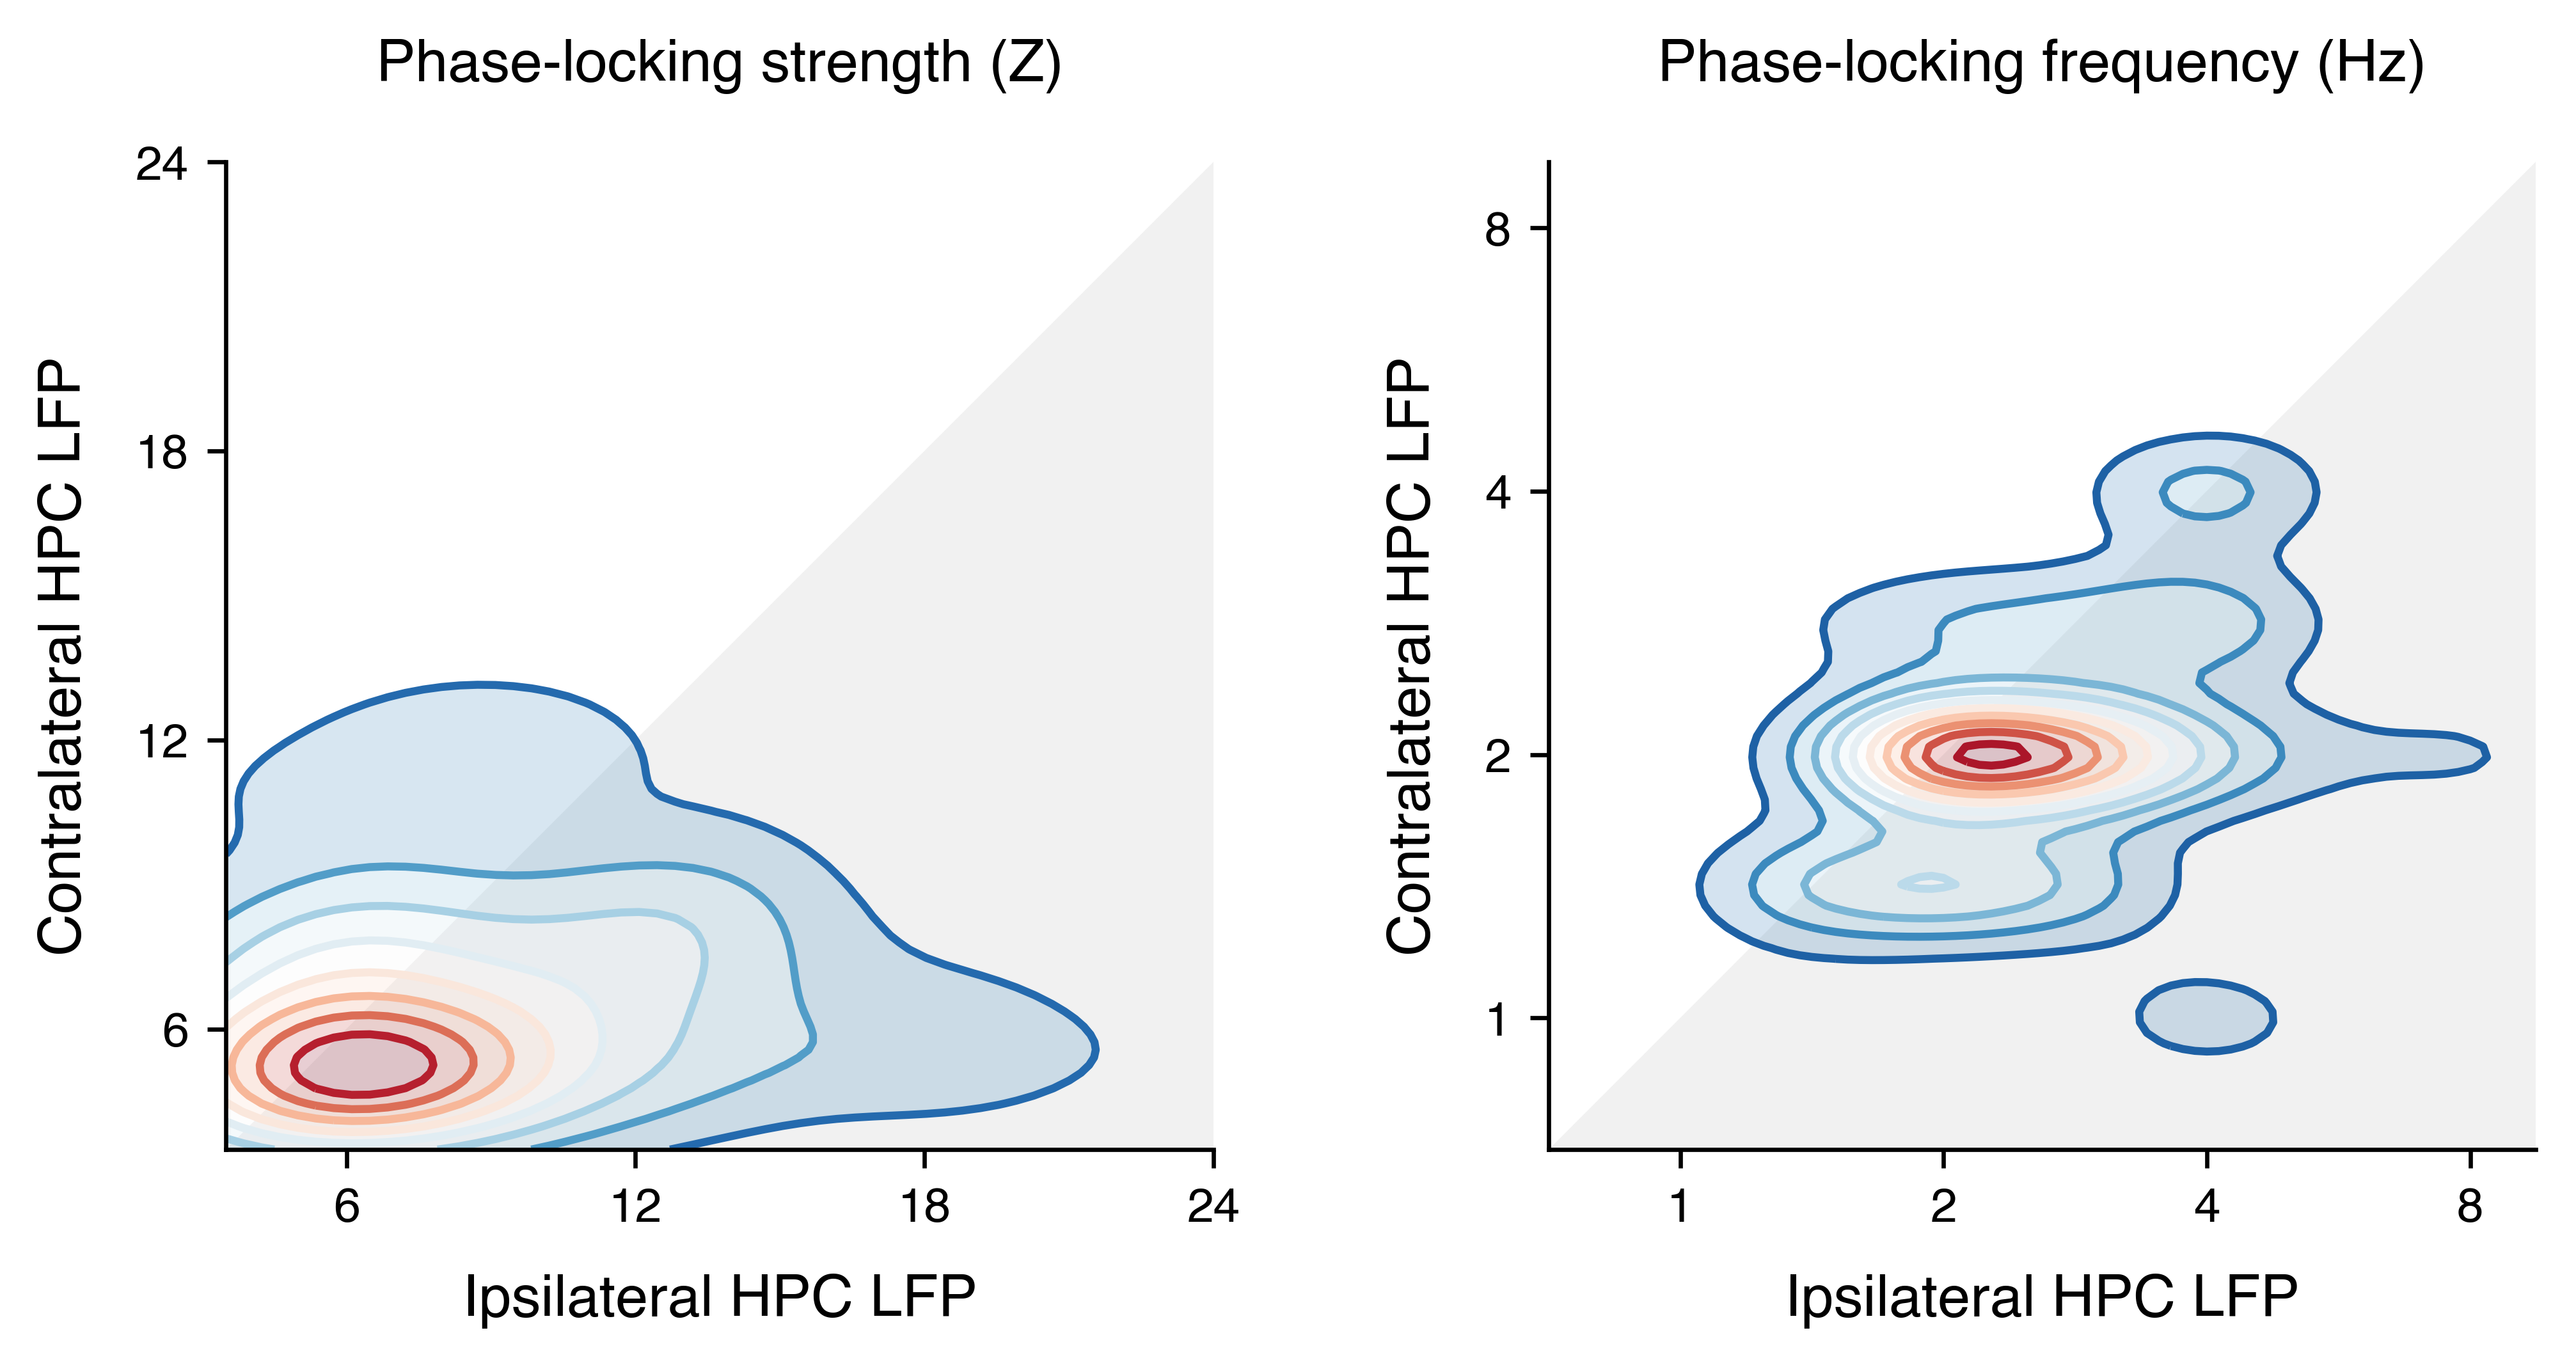

In [1251]:
fig, ax = plt.subplots(1, 2, figsize=(colws[2], colws[2]*0.5), dpi=600)
ax = np.ravel(ax)

tickfontsize = 9
labelfontsize = 11
figfontsize = 11

cols = ['locked_mrl_z', 'locked_freq_ind_z']
labs = ['Phase-locking strength (Z)', 'Phase-locking frequency (Hz)']
rois = bilat_pl['unit_roi3'].tolist()
lims = [(np.min(dat['locked_mrl_z']), 24, [6, 12, 18, 24]),
        (1, 8.5, [2, 4, 6, 8])]

for i in range(len(ax)):
    patch = patches.Polygon([(lims[i][0], lims[i][0]), (lims[i][1], lims[i][0]), (lims[i][1], lims[i][1])], 
                            linewidth=0, color=colors[5], alpha=0.1, zorder=0)
    ax[i].add_patch(patch)
    ax[i] = sns.kdeplot(dat[cols[i]][:, 0], dat[cols[i]][:, 1], clip=(np.min(dat[cols[i]]), np.max(dat[cols[i]])), ax=ax[i], linewidths=1.5, bw='scott',
                        cmap='RdBu_r', shade=False, shade_lowest=False, gridsize=100)
    ax[i] = sns.kdeplot(dat[cols[i]][:, 0], dat[cols[i]][:, 1], clip=(np.min(dat[cols[i]]), np.max(dat[cols[i]])), ax=ax[i], linewidths=1.5, bw='scott',
                        cmap='RdBu_r', shade=True, alpha=0.2, shade_lowest=False, gridsize=100)
    ax[i].set_aspect('equal')
    ax[i].set_xlim(lims[i][:2])
    ax[i].set_xticks(lims[i][2])
    ax[i].set_ylim(lims[i][:2])
    ax[i].set_yticks(lims[i][2])
    ax[i].set_title(labs[i], fontsize=figfontsize, y=1.05)
    
    if i == 1:
        ax[i].set_xticklabels([int(x) for x in freqs[lims[i][2]]], fontsize=tickfontsize)
        ax[i].set_yticklabels([int(x) for x in freqs[lims[i][2]]], fontsize=tickfontsize)
    else:
        ax[i].set_xticklabels(lims[i][2], fontsize=tickfontsize)
        ax[i].set_yticklabels(lims[i][2], fontsize=tickfontsize)
    
    if i < 2:
        ax[i].set_xlabel('Ipsilateral HPC LFP', fontsize=labelfontsize, labelpad=8)
        ax[i].set_ylabel('Contralateral HPC LFP', fontsize=labelfontsize, labelpad=8)
    else:
        ax[i].set_xlabel('', fontsize=labelfontsize, labelpad=8)
        ax[i].set_ylabel('', fontsize=labelfontsize, labelpad=8)
    
fig.tight_layout(w_pad=2.5)

if False:
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/bilateral_phase_locking_kde_2plots.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/bilateral_phase_locking_kde_2plots.png', 
                format='png', dpi=600, bbox_inches='tight')

In [1308]:
xvals = dat['pl_strength'][:, 0] - dat['pl_strength'][:, 1]
yvals = 0.5 * (dat['pl_freq'][:, 0] - dat['pl_freq'][:, 1])
np.min(xvals), np.max(xvals), np.min(yvals), np.max(yvals)

(-4.9992185, 30.252476, -1.0, 3.5)

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


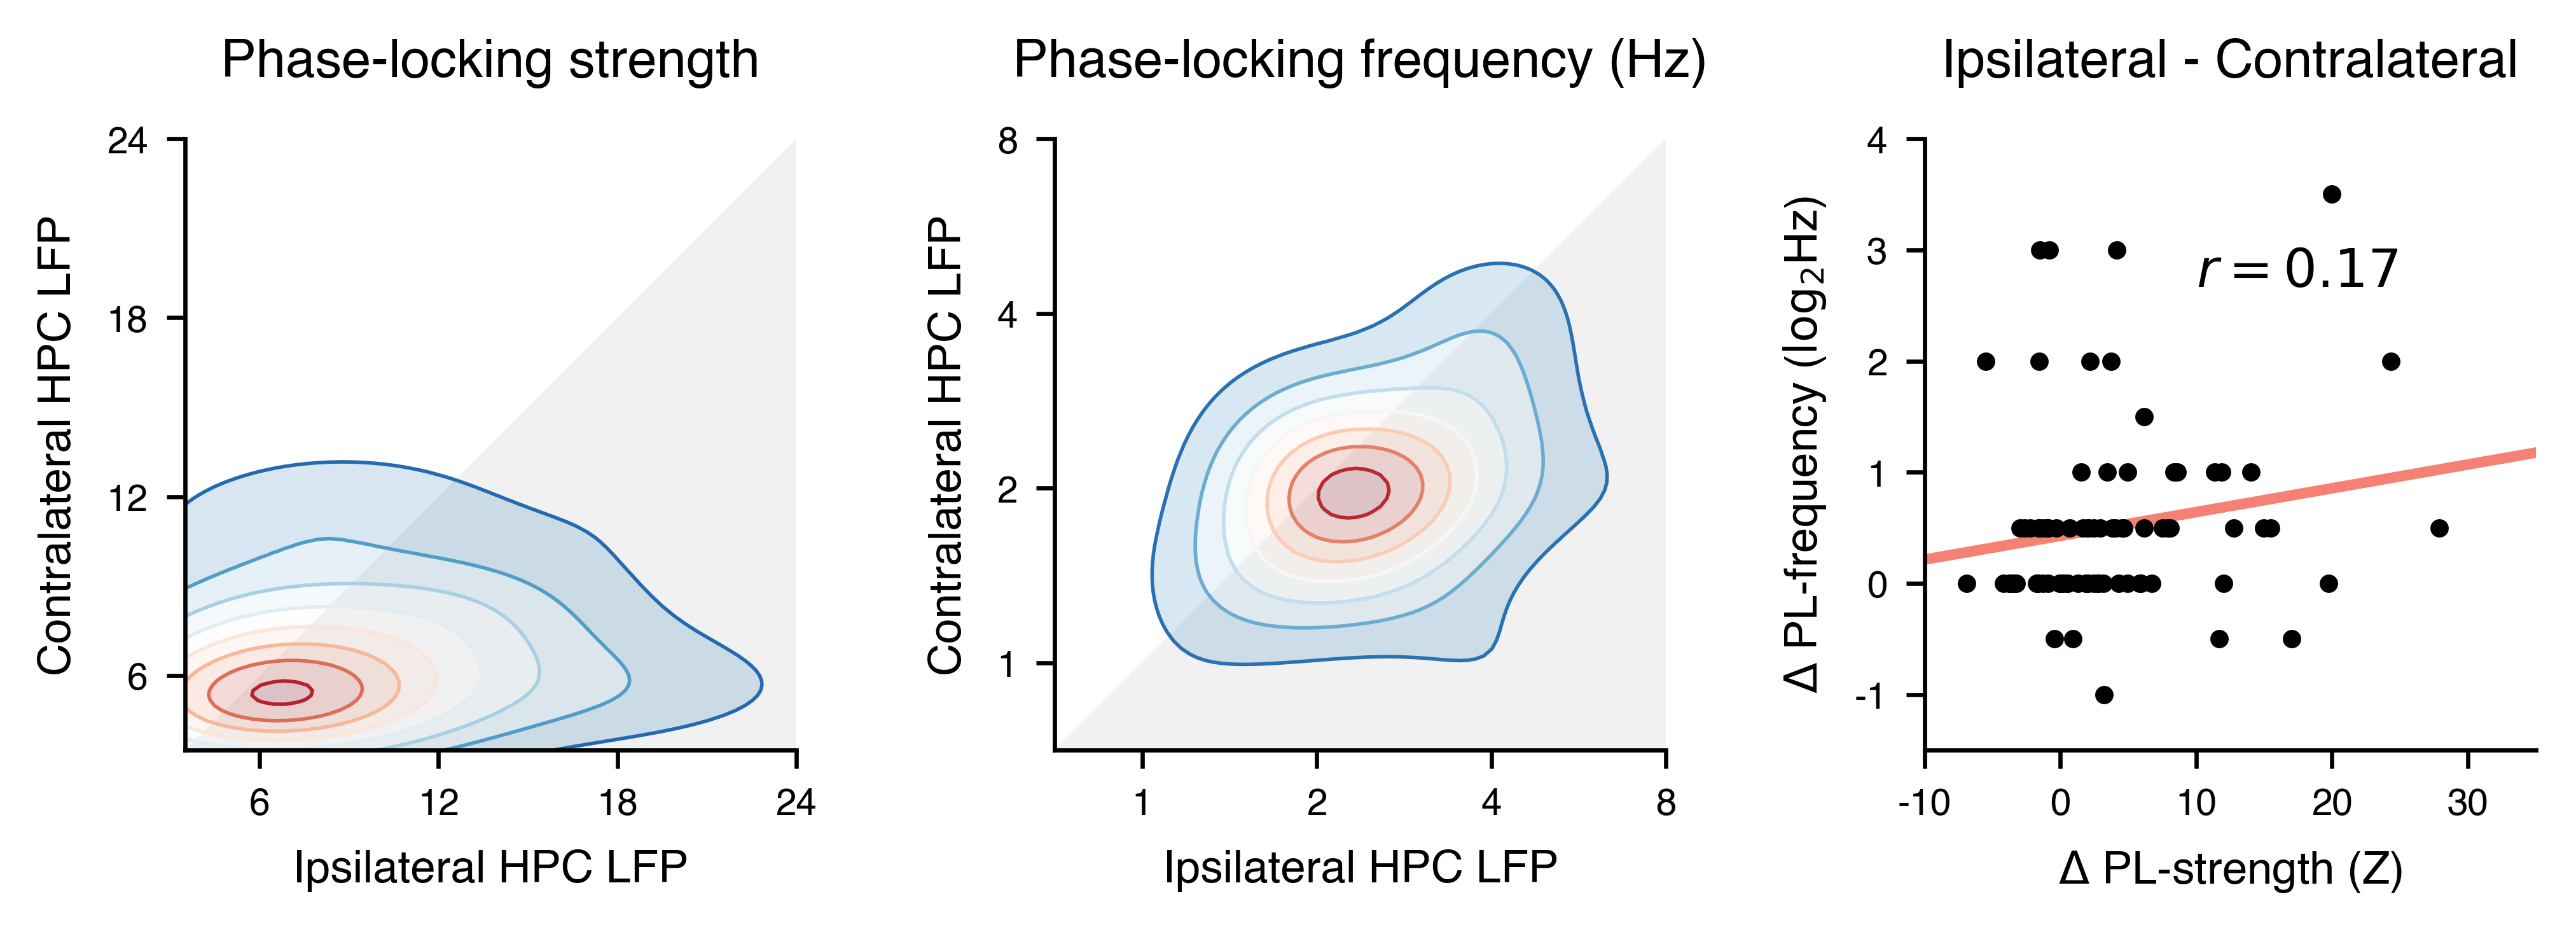

In [1661]:
fig, ax = plt.subplots(1, 3, figsize=(colws[2], colws[2]*0.4), dpi=600)
ax = np.ravel(ax)

tickfontsize = 7
labelfontsize = 8.5
figfontsize = 10

cols = ['locked_mrl_z', 'locked_freq_ind_z']
labs = ['Phase-locking strength', 'Phase-locking frequency (Hz)', 'Ipsilateral - Contralateral']
rois = bilat_pl['unit_roi3'].tolist()
lims = [(np.min(dat['locked_mrl_z']), 24, [6, 12, 18, 24]),
        (1, 8, [2, 4, 6, 8]),
        (-10, 35, [-10, 0, 10, 20, 30]),
        (-1.5, 4, [-1, 0, 1, 2, 3, 4])]

for i in range(2):
    patch = patches.Polygon([(lims[i][0], lims[i][0]), (lims[i][1], lims[i][0]), (lims[i][1], lims[i][1])], 
                            linewidth=0, color=colors[5], alpha=0.1, zorder=0)
    ax[i].add_patch(patch)
    ax[i] = sns.kdeplot(dat[cols[i]][:, 0], dat[cols[i]][:, 1], clip=(np.min(dat[cols[i]]), np.max(dat[cols[i]])), ax=ax[i], linewidths=0.67, 
                        bw=(np.std(dat[cols[i]][:, 0])/2, np.std(dat[cols[i]][:, 1])/2), cmap='RdBu_r', shade=False, shade_lowest=False, gridsize=100)
    ax[i] = sns.kdeplot(dat[cols[i]][:, 0], dat[cols[i]][:, 1], clip=(np.min(dat[cols[i]]), np.max(dat[cols[i]])), ax=ax[i], linewidths=0.67, 
                        bw=(np.std(dat[cols[i]][:, 0])/2, np.std(dat[cols[i]][:, 1])/2), cmap='RdBu_r', shade=True, alpha=0.2, shade_lowest=False, gridsize=100)
    
    ax[i].set_aspect('equal')
    ax[i].set_xlim(lims[i][:2])
    ax[i].set_xticks(lims[i][2])
    ax[i].set_ylim(lims[i][:2])
    ax[i].set_yticks(lims[i][2])
    ax[i].set_title(labs[i], fontsize=figfontsize, y=1.05)
    
    if i == 1:
        ax[i].set_xticklabels([int(x) for x in freqs[lims[i][2]]], fontsize=tickfontsize)
        ax[i].set_yticklabels([int(x) for x in freqs[lims[i][2]]], fontsize=tickfontsize)
    else:
        ax[i].set_xticklabels(lims[i][2], fontsize=tickfontsize)
        ax[i].set_yticklabels(lims[i][2], fontsize=tickfontsize)
    ax[i].set_xlabel('Ipsilateral HPC LFP', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylabel('Contralateral HPC LFP', fontsize=labelfontsize, labelpad=5)
    
i = 2
xvals = dat['locked_mrl_z'][:, 0] - dat['locked_mrl_z'][:, 1] # ipsi - contra
yvals = 0.5 * (dat['locked_freq_ind_z'][:, 0] - dat['locked_freq_ind_z'][:, 1]) # ipsi - contra
xmin, xmax = lims[i][0], lims[i][1]
ymin, ymax = lims[i+1][0], lims[i+1][1]
fit = stats.linregress(xvals, yvals)
ax[i].plot((xmin, xmax), (fit.intercept + (fit.slope * xmin), fit.intercept + (fit.slope * xmax)),
           color=colors[1], linewidth=2, alpha=0.67, zorder=0)
ax[i].scatter(xvals, yvals, s=12, c='k', linewidths=0)
ax[i].annotate('$r = {:.2f}$'.format(fit.rvalue), xy=(10, 2.67), fontsize=figfontsize)
ax[i].set_aspect((xmax-xmin)/(ymax-ymin))
ax[i].set_xlim(lims[i][:2])
ax[i].set_xticks(lims[i][2])
ax[i].set_xticklabels(lims[i][2], fontsize=tickfontsize)
ax[i].set_xlabel('$\Delta$ PL-strength (Z)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylim(lims[i+1][:2])
ax[i].set_yticks(lims[i+1][2])
ax[i].set_yticklabels(lims[i+1][2], fontsize=tickfontsize)
ax[i].set_ylabel('$\Delta$ PL-frequency ($\log_2$Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_title(labs[i], fontsize=figfontsize, y=1.05)
    
fig.tight_layout()

if False:
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/bilateral_phase_locking_kde_plots.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/bilateral_phase_locking_kde_plots.png', 
                format='png', dpi=600, bbox_inches='tight')

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


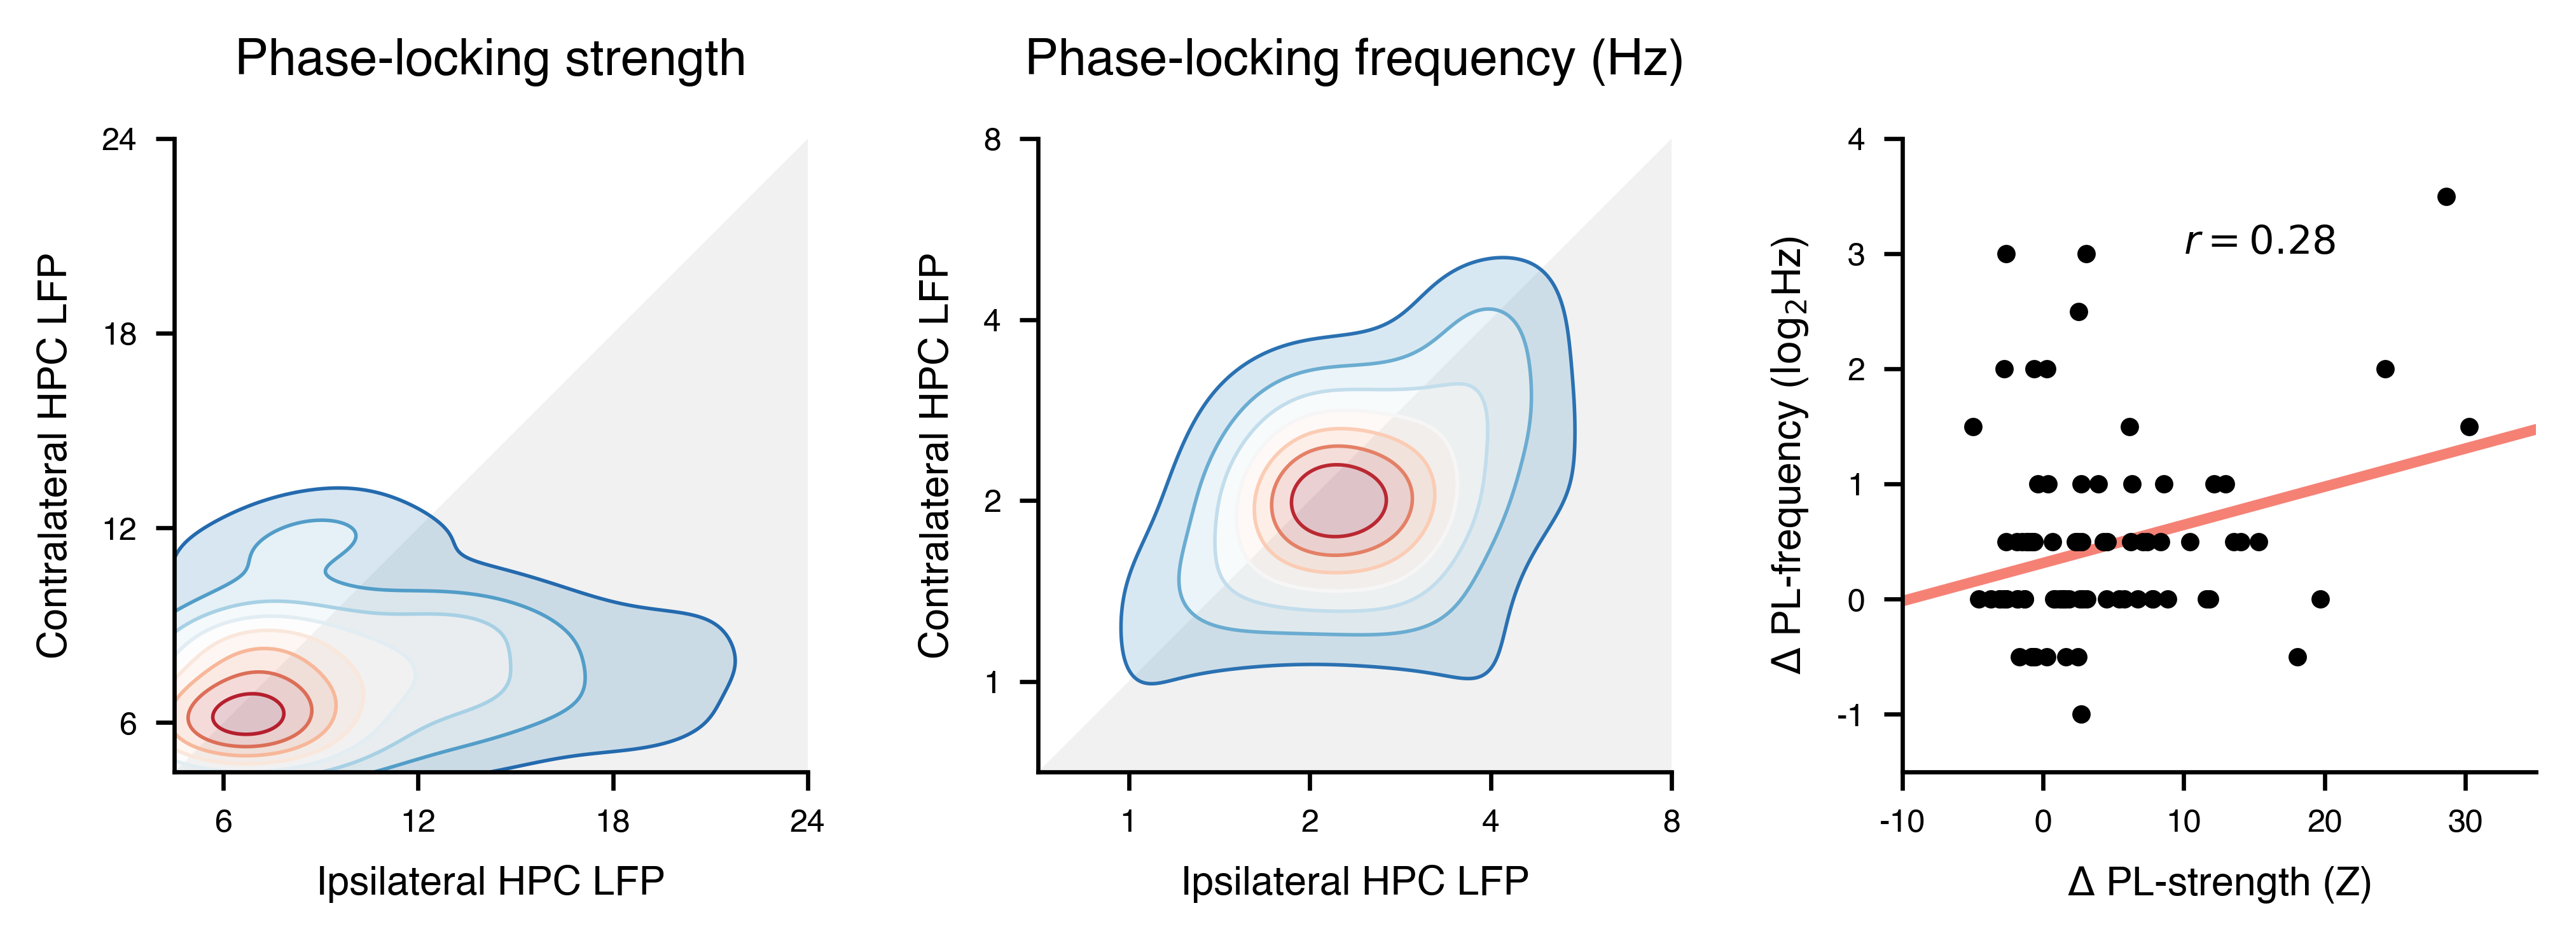

In [1333]:
fig, ax = plt.subplots(1, 3, figsize=(colws[2], colws[2]*0.4), dpi=600)
ax = np.ravel(ax)

tickfontsize = 6
labelfontsize = 7.5
figfontsize = 9.5

cols = ['pl_strength', 'pl_freq', 'pl_time_shift', 'pl_latency']
labs = ['Phase-locking strength', 'Phase-locking frequency (Hz)', 'Spike-LFP shift (ms)', 'Spike-LFP latency (ms)']
rois = bilat_pl['unit_roi3'].tolist()
lims = [(np.min(dat['pl_strength']), 24, [6, 12, 18, 24]),
        (1, 8, [2, 4, 6, 8]),
        (-10, 35, [-10, 0, 10, 20, 30]),
        (-1.5, 4, [-1, 0, 1, 2, 3, 4])]

for i in range(2):
    patch = patches.Polygon([(lims[i][0], lims[i][0]), (lims[i][1], lims[i][0]), (lims[i][1], lims[i][1])], 
                            linewidth=0, color=colors[5], alpha=0.1, zorder=0)
    ax[i].add_patch(patch)
    ax[i] = sns.kdeplot(dat[cols[i]][:, 0], dat[cols[i]][:, 1], clip=(np.min(dat[cols[i]]), np.max(dat[cols[i]])), ax=ax[i], linewidths=0.67, bw='scott',
                        cmap='RdBu_r', shade=False, shade_lowest=False, gridsize=1000)
    ax[i] = sns.kdeplot(dat[cols[i]][:, 0], dat[cols[i]][:, 1], clip=(np.min(dat[cols[i]]), np.max(dat[cols[i]])), ax=ax[i], linewidths=0.67, bw='scott',
                        cmap='RdBu_r', shade=True, alpha=0.2, shade_lowest=False, gridsize=1000)
    
    ax[i].set_aspect('equal')
    ax[i].set_xlim(lims[i][:2])
    ax[i].set_xticks(lims[i][2])
    ax[i].set_ylim(lims[i][:2])
    ax[i].set_yticks(lims[i][2])
    ax[i].set_title(labs[i], fontsize=figfontsize, y=1.05)
    
    if i == 1:
        ax[i].set_xticklabels([int(x) for x in freqs[lims[i][2]]], fontsize=tickfontsize)
        ax[i].set_yticklabels([int(x) for x in freqs[lims[i][2]]], fontsize=tickfontsize)
    else:
        ax[i].set_xticklabels(lims[i][2], fontsize=tickfontsize)
        ax[i].set_yticklabels(lims[i][2], fontsize=tickfontsize)
    ax[i].set_xlabel('Ipsilateral HPC LFP', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylabel('Contralateral HPC LFP', fontsize=labelfontsize, labelpad=5)
    
i = 2
xvals = dat['pl_strength'][:, 0] - dat['pl_strength'][:, 1] # ipsi - contra
yvals = 0.5 * (dat['pl_freq'][:, 0] - dat['pl_freq'][:, 1]) # ipsi - contra
xmin, xmax = lims[i][0], lims[i][1]
ymin, ymax = lims[i+1][0], lims[i+1][1]
fit = stats.linregress(xvals, yvals)
ax[i].plot((xmin, xmax), (fit.intercept + (fit.slope * xmin), fit.intercept + (fit.slope * xmax)),
           color=colors[1], linewidth=2, alpha=0.67, zorder=0)
ax[i].scatter(xvals, yvals, s=12, c='k', linewidths=0)
ax[i].annotate('$r = {:.2f}$'.format(fit.rvalue), xy=(10, 3), fontsize=labelfontsize)
ax[i].set_aspect((xmax-xmin)/(ymax-ymin))
ax[i].set_xlim(lims[i][:2])
ax[i].set_xticks(lims[i][2])
ax[i].set_xticklabels(lims[i][2], fontsize=tickfontsize)
ax[i].set_xlabel('$\Delta$ PL-strength (Z)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylim(lims[i+1][:2])
ax[i].set_yticks(lims[i+1][2])
ax[i].set_yticklabels(lims[i+1][2], fontsize=tickfontsize)
ax[i].set_ylabel('$\Delta$ PL-frequency ($\log_2$Hz)', fontsize=labelfontsize, labelpad=5)
    
fig.tight_layout()

if True:
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/bilateral_phase_locking_kde_plots.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/bilateral_phase_locking_kde_plots.png', 
                format='png', dpi=600, bbox_inches='tight')

In [113]:
# For cells in patients with bilateral hippocampal electrodes,
# how many are phase-locked to 0, 1, or 2 hippocampal regions?
bpl_df = (pl_df
          .query("(edge=='ctx-hpc')")
          .reset_index()
          .groupby('subj_sess_unit')
          .agg({'index': lambda x: list(x),
                'subj': lambda x: np.unique(x)[0],
                'subj_sess': lambda x: np.unique(x)[0],
                'unit': len, 
                'unit_fr': lambda x: np.round(np.unique(x), 1), 
                'same_hem': lambda x: list(x),
                'unit_hemroi': lambda x: np.unique(x), 
                'lfp_hemroi': lambda x: list(x), 
                'pl_strength': lambda x: list(x), 
                'pl_freq': lambda x: list(x), 
                'pl_time_shift': lambda x: list(x),
                'pl_latency': lambda x: list(x),
                'sig_z_fdr': lambda x: list(x),
                'index': lambda x: list(x)})
          .query("(unit==2)")
          .reset_index())
bpl_df['lfp_hemroi_0'] = bpl_df['lfp_hemroi'].apply(lambda x: x[0])
bpl_df['lfp_hemroi_1'] = bpl_df['lfp_hemroi'].apply(lambda x: x[1])
bpl_df['sig_z_fdr_0'] = bpl_df['sig_z_fdr'].apply(lambda x: x[0])
bpl_df['sig_z_fdr_1'] = bpl_df['sig_z_fdr'].apply(lambda x: x[1])
bpl_df['nsig'] = bpl_df['sig_z_fdr'].apply(lambda x: np.sum(x))

np.sum(bpl_df.nsig==0), np.sum(bpl_df.nsig>0), np.sum(bpl_df.nsig==1), np.sum(bpl_df.nsig==2), len(bpl_df)

(711, 346, 262, 84, 1057)

In [350]:
# Save the bilateral phase-locking DataFrame for mixed effects analysis in R
if False:
    cols = ['subj', 'sess', 'unit_chan_ind', 'unit', 'unit_hemroi', 'lfp_hemroi', 'unit_roi2', 'unit_roi3',
            'roi_unit_to_lfp', 'same_hem', 'locked_freq_ind_z', 'locked_mrl_z', 
            'tl_locked_freq_z', 'tl_locked_time_z', 'tl_locked_mrl_z', 'sig_z_fdr',
            'pl_freq', 'pl_strength', 'pl_time_shift', 'pl_latency']
    df = pl_df.query("(subj_sess_unit=={})".format(bpl_df['subj_sess_unit'].tolist()))[cols].copy()
    df['tl_locked_time_z'] = -df['tl_locked_time_z'] # flip times back (positive values = spikes precede LFP)
    fname = '/home1/dscho/projects/unit_activity_and_hpc_theta/figs/bilat_pl_df_{}-ctx-hpc.csv'.format(len(df))
    df.to_csv(fname, index=False)
    print('Saved {}'.format(fname))

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs/bilat_pl_df_2114-ctx-hpc.csv


In [120]:
bpl_df.shape, df.shape

((1057, 19), (2114, 4))

In [121]:
# Save the bilateral phase-locking DataFrame for mixed effects analysis in R
if False:
    cols = ['subj', 'subj_sess_unit', 'same_hem', 'sig_z_fdr']
    df = pl_df.query("(subj_sess_unit=={}) & (edge=='ctx-hpc')".format(bpl_df['subj_sess_unit'].tolist()))[cols].copy()
    fname = '/home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/R_tables/bilat_pl_df_ctx-hpc.csv'
    df.to_csv(fname, index=False)
    print('Saved {}'.format(fname))

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/R_tables/bilat_pl_df_ctx-hpc.csv


In [864]:
# Calculate the percent of neurons in each region that significantly
# phase-lock to ipsi- and contralateral hippocampal oscillations
def get_conf(x):
    """Return a 95% confidence interval using normal approximation of the binomial distribution.
    
    np ± 1.96 * sqrt(np(1-p))
    
    where n is the sample size and p is the probability of a given outcome
    """
    n = x.unit
    p = x.sig_z_fdr
    np_ =  n * p
    return 1.96 * np.sqrt(np_ * (1 - p))

df = (pl_df
      .query("(edge=='ctx-hpc') & (subj_sess_unit=={})".format(bpl_df['subj_sess_unit'].tolist()))
      .groupby(['subj_sess_unit', 'same_hem'])
      .agg({'unit': len, 'unit_roi2': lambda x: list(x)[0],'sig_z_fdr': lambda x: np.sum(x)>0})
      .reset_index()
      .groupby(['unit_roi2', 'same_hem'])
      .agg({'unit': len, 'sig_z_fdr': np.mean})
      .reset_index())

rois = od([('amy', 'AMY'),
           ('ec', 'EC'), 
           ('phg', 'PHG'),
           ('ofc', 'OFC'),
           ('ac', 'AC'),
           ('ctx', 'Other')])

df['unit_roi2'] = df.unit_roi2.astype('category').cat.reorder_categories(rois.keys(), ordered=True)
df['hem'] = df.same_hem.apply(lambda x: 'ipsi' if x else 'contra')
df['hem'] = df.hem.astype('category').cat.reorder_categories(['ipsi', 'contra'], ordered=True)
df['err'] = df.apply(lambda x: get_conf(x)/x.unit, axis=1)
df['sig_z_ratio'] = df['sig_z_fdr'] / max(df['sig_z_fdr'])

d_ = od(pl_df.query("(subj_sess_unit=={})".format(bpl_df.query("(nsig==2)")['subj_sess_unit'].tolist())).groupby('unit_roi2').agg({'subj_sess_unit': lambda x: len(np.unique(x))})['subj_sess_unit'].to_dict())
df2 = []
for roi in rois:
    n_unit = df.loc[df['unit_roi2']==roi].iloc[0]['unit']
    df2.append([roi, None, n_unit, d_.get(roi, 0)/n_unit, 'bilat', 0, 0])
df2 = pd.DataFrame(df2, columns=df.columns)

df = pd.concat((df, df2)).reset_index(drop=True)
df = df.sort_values(['unit_roi2', 'hem'])
df['hem'] = df.hem.astype('category').cat.reorder_categories(['ipsi', 'contra', 'bilat'], ordered=True)
df['unit_roi2'] = df.unit_roi2.astype('category').cat.reorder_categories(rois.keys(), ordered=True)

In [744]:
df

unit_roi2 same_hem  unit  sig_z_fdr     hem       err  sig_z_ratio
16        ac     None    84   0.000000   bilat  0.000000     0.000000
0         ac    False    84   0.011905  contra  0.023194     0.022230
1         ac     True    84   0.059524    ipsi  0.050598     0.111152
12       amy     None   284   0.161972   bilat  0.000000     0.000000
2        amy    False   284   0.200704  contra  0.046583     0.374784
3        amy     True   284   0.468310    ipsi  0.058035     0.874497
17       ctx     None   244   0.040984   bilat  0.000000     0.000000
4        ctx    False   244   0.057377  contra  0.029181     0.107143
5        ctx     True   244   0.221311    ipsi  0.052089     0.413265
13        ec     None   183   0.087432   bilat  0.000000     0.000000
6         ec    False   183   0.098361  contra  0.043148     0.183673
7         ec     True   183   0.535519    ipsi  0.072261     1.000000
15       ofc     None   145   0.041379   bilat  0.000000     0.000000
8        ofc    False   145   0.055172  contra  0.037163     0.103026
9        ofc     True   145   0.096552    ipsi  0.048073     0.180296
14       phg     None   117   0.051282   bilat  0.000000     0.000000
10       phg    False   117   0.102564  contra  0.054975     0.191523
11       phg     True   117   0.136752    ipsi  0.062258     0.255364

In [440]:
od(pl_df.query("(subj_sess_unit=={})".format(bpl_df.query("(nsig==2)")['subj_sess_unit'].tolist())).groupby('unit_roi2').agg({'subj_sess_unit': lambda x: len(np.unique(x))})['subj_sess_unit'].to_dict())

OrderedDict([('amy', 46), ('ctx', 10), ('ec', 16), ('ofc', 6), ('phg', 6)])

In [444]:
df

unit_roi2 same_hem  unit  sig_z_fdr     hem       err  sig_z_ratio
16        ac     None    84   0.000000   bilat  0.000000     0.000000
0         ac    False    84   0.011905  contra  0.023194     0.022230
1         ac     True    84   0.059524    ipsi  0.050598     0.111152
12       amy     None   284   0.161972   bilat  0.000000     0.000000
2        amy    False   284   0.200704  contra  0.046583     0.374784
3        amy     True   284   0.468310    ipsi  0.058035     0.874497
17       ctx     None   244   0.040984   bilat  0.000000     0.000000
4        ctx    False   244   0.057377  contra  0.029181     0.107143
5        ctx     True   244   0.221311    ipsi  0.052089     0.413265
13        ec     None   183   0.087432   bilat  0.000000     0.000000
6         ec    False   183   0.098361  contra  0.043148     0.183673
7         ec     True   183   0.535519    ipsi  0.072261     1.000000
15       ofc     None   145   0.041379   bilat  0.000000     0.000000
8        ofc    False   145   0.055172  contra  0.037163     0.103026
9        ofc     True   145   0.096552    ipsi  0.048073     0.180296
14       phg     None   117   0.051282   bilat  0.000000     0.000000
10       phg    False   117   0.102564  contra  0.054975     0.191523
11       phg     True   117   0.136752    ipsi  0.062258     0.255364

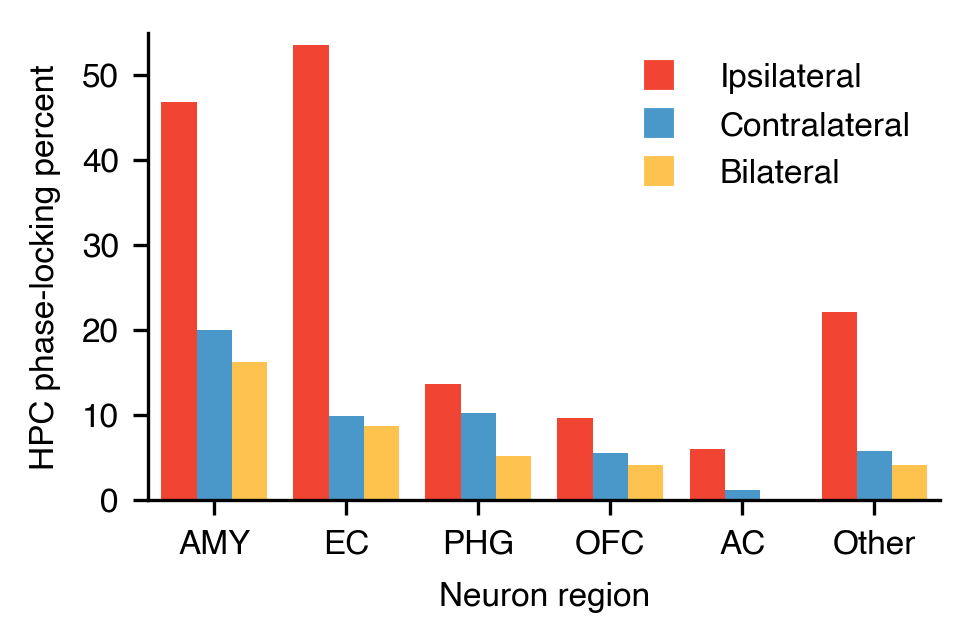

In [873]:
fig, ax = plt.subplots(1, 1, figsize=(colws[1], colws[1]*0.67), dpi=300) # 2 column width
ax = np.ravel(ax)

tickfontsize = 8
labelfontsize = 8
# tickfontsize = 16
# labelfontsize = 18


i = 0
sns.barplot(x='unit_roi2', y='sig_z_fdr', hue='hem', data=df, 
            palette=[colors[1], colors[0], colors[6]], saturation=1, ax=ax[i])
xax = np.repeat(np.arange(6, dtype=float), 2)
xax[::2] -= 0.2
xax[1::2] += 0.2
ax[i].set_xticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylim([0, 0.55])
ax[i].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax[i].set_yticklabels([0, 10, 20, 30, 40, 50], fontsize=tickfontsize)
ax[i].set_xlabel('Neuron region', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC phase-locking percent', fontsize=labelfontsize, labelpad=5)
ax[i].get_legend().remove()

custom_lines = [Line2D([0], [0], marker='s', color='w', label='Ipsilateral', markerfacecolor=colors[1], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Contralateral', markerfacecolor=colors[0], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Bilateral', markerfacecolor=colors[6], markersize=tickfontsize)]
legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_pct_by_roi_and_hem_bilat_neurons.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_pct_by_roi_and_hem_bilat_neurons.png', 
                format='png', dpi=300, bbox_inches='tight')

In [862]:
# What percent of cells were phase-locked at the subject level?
df = (pl_df
      .query("(edge=='ctx-hpc') & (same_hem==False) & (subj_sess_unit=={})".format(bpl_df['subj_sess_unit'].tolist()))
      .groupby('subj_sess_unit')
      .agg({'subj': lambda x: list(x)[0], 'unit': len, 'sig_z_fdr': lambda x: np.sum(x)>0})
      .groupby(['subj'])
      .agg({'unit': len, 'sig_z_fdr': np.sum})
      .sort_values('unit', ascending=False))
df['pct'] = df.apply(lambda x: np.round(100 * (x.sig_z_fdr/x.unit), 1), axis=1)
print('Contralateral phase-locking:')
print('Mean: {:.1f}%, std: {:.1f}%'.format(np.mean(df['pct']), np.std(df['pct'])))
df

Contralateral phase-locking:
Mean: 10.5%, std: 6.3%


unit  sig_z_fdr   pct
subj                       
U381   149       30.0  20.1
U380   148        5.0   3.4
U384   135        5.0   3.7
U371   122       18.0  14.8
U385   111       14.0  12.6
U369    84        6.0   7.1
U395    63       10.0  15.9
U379    59        0.0   0.0
U372    45        4.0   8.9
U390    31        3.0   9.7
U393    31        5.0  16.1
U394    28        4.0  14.3
U370    24        3.0  12.5
U396    16        3.0  18.8
U392    11        0.0   0.0

In [403]:
if False:
    dat = []
    for idx, row in bpl_df.iterrows():
        if row['same_hem'][0] == True:
            dat.append([row['subj'], row['unit_fr'], row['sig_z_fdr'][0], row['sig_z_fdr'][1]])
        else:
            dat.append([row['subj'], row['unit_fr'], row['sig_z_fdr'][1], row['sig_z_fdr'][0]])
    dat = pd.DataFrame(dat, columns=['subj', 'fr', 'ipsi_sig', 'contra_sig'])
    
    fname = '/home1/dscho/projects/unit_activity_and_hpc_theta/figs/bilat_pl_odds_{}-ctx-hpc.csv'.format(len(dat))
    dat.to_csv(fname, index=False)
    print('Saved {}'.format(fname))

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs/bilat_pl_odds_1057-ctx-hpc.csv


In [127]:
if False:
    dat = []
    for idx, row in bpl_df.iterrows():
        if row['same_hem'][0] == True:
            dat.append([row['subj'], row['sig_z_fdr'][0], row['sig_z_fdr'][1]])
        else:
            dat.append([row['subj'], row['sig_z_fdr'][1], row['sig_z_fdr'][0]])
    dat = pd.DataFrame(dat, columns=['subj', 'ipsi_sig', 'contra_sig'])
    
    fname = '/home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/R_tables/bilat_pl_odds-ctx_hpc.csv'.format(len(dat))
    dat.to_csv(fname, index=False)
    print('Saved {}'.format(fname))

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/public_data_release/data/R_tables/bilat_pl_odds-ctx_hpc.csv


In [1102]:
n_cells = len(bpl_df)

ipsi_sig_units = pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True) & (subj_sess_unit=={})".format(bpl_df['subj_sess_unit'].tolist()))['subj_sess_unit'].tolist()
contra_sig_units = pl_df.query("(edge=='ctx-hpc') & (same_hem==False) & (sig_z_fdr==True) & (subj_sess_unit=={})".format(bpl_df['subj_sess_unit'].tolist()))['subj_sess_unit'].tolist()

n_sig_ipsi = len(ipsi_sig_units)
n_sig_contra = len(pl_df.query("(same_hem==False) & (sig_z_fdr==True) & (subj_sess_unit=={})".format(bpl_df['subj_sess_unit'].tolist())))
n_sig_either = len(bpl_df.query("(nsig>=1)"))
n_sig_both = len(bpl_df.query("(nsig==2)"))
n_sig_neither = len(bpl_df.query("(nsig==0)"))
n_sig_ipsi_only = len(pl_df.query("(same_hem==True) & (sig_z_fdr==True) & (subj_sess_unit=={})".format(bpl_df.query("(nsig==1)")['subj_sess_unit'].tolist())))
n_sig_contra_only = len(pl_df.query("(same_hem==False) & (sig_z_fdr==True) & (subj_sess_unit=={})".format(bpl_df.query("(nsig==1)")['subj_sess_unit'].tolist())))

vals = od([('n_cells', n_cells),
           ('n_sig_ipsi', len(ipsi_sig_units)),
           ('n_sig_contra', len(contra_sig_units)),
           ('n_sig_either', n_sig_either),
           ('n_sig_both', n_sig_both),
           ('n_sig_neither', n_sig_neither),
           ('n_sig_ipsi_only', n_sig_ipsi_only),
           ('n_sig_contra_only', n_sig_contra_only)])

vals['pct_ipsi'] = vals['n_sig_ipsi'] / vals['n_cells']
vals['pct_contra'] = vals['n_sig_contra'] / vals['n_cells']
vals['pct_contra_g_ipsi'] = vals['n_sig_both'] / vals['n_sig_ipsi']
vals['pct_ipsi_g_contra'] = vals['n_sig_both'] / vals['n_sig_contra']

for k, v in vals.items():
    print(k, v)

n_cells 1057
n_sig_ipsi 320
n_sig_contra 110
n_sig_either 346
n_sig_both 84
n_sig_neither 711
n_sig_ipsi_only 617
n_sig_contra_only 74
pct_ipsi 0.30274361400189215
pct_contra 0.10406811731315042
pct_contra_g_ipsi 0.2625
pct_ipsi_g_contra 0.7636363636363637


In [409]:
0.2625/0.10406811731315042

2.5223863636363637

In [401]:
# Test P(A|B) = P(A)
xtab = np.array([[vals['n_cells']*vals['pct_contra']**2, vals['n_sig_contra']],
                 [vals['n_sig_contra'], vals['n_cells']]])
print(xtab)

results = stats.chi2_contingency(xtab)
print('Chi^2({}) = {:.1f}, p = {}'.format(results[2], results[0], results[1]))

[[  11.4474929  110.       ]
 [ 110.        1057.       ]]
Chi^2(1) = 0.0, p = 1.0


In [400]:
# Test P(A|B) = P(A)
xtab = np.array([[vals['n_cells']*vals['pct_ipsi']**2, vals['n_sig_ipsi']],
                 [vals['n_sig_ipsi'], vals['n_cells']]])
print(xtab)

results = stats.chi2_contingency(xtab)
print('Chi^2({}) = {:.1f}, p = {}'.format(results[2], results[0], results[1]))

[[  96.87795648  320.        ]
 [ 320.         1057.        ]]
Chi^2(1) = 0.0, p = 0.9486782795973506


In [397]:
# Test P(A|B) = P(A)
xtab = np.array([[vals['n_sig_both'], vals['n_sig_ipsi']],
                 [vals['n_sig_contra'], vals['n_cells']]])
print(xtab)

results = stats.chi2_contingency(xtab)
print('Chi^2({}) = {:.1f}, p = {}'.format(results[2], results[0], results[1]))

[[  84  320]
 [ 110 1057]]
Chi^2(1) = 34.8, p = 3.6963723096383383e-09


## Phase-locking single-cell examples

In [421]:
# U390_ses3 unit9 RAH (R PHG → R HPC; iFreq4)

# potentially interesting iUnits
# EC: 38, 51, 55, 136p, 142 and 143c, 146*, 147p, 159* (and 160, 167), 190, 198*, 281c* and 282*, 289c* and 290 and 574, 292* and 569
# AMY: 8, 14, 18, 22, 34*, 39c, 47h*, 109c, 184*, 186*, 194*, 196*, 204c*, 213c, 215, 220, 224c*, 228, 244c, 253, 259, 269, 294* and 296
#      273h*, (!)275h* and 276c, 287c and 288*, 291p
# CTX: 30*, 152*
# PHG: 56, 133c, 170*, 171, 173, 216c
# AC: 255
# OFC: 274

# * = good example; c = contralateral; h = high frequency; p = PAC?; and = same cell; (!) def. in the paper

In [912]:
# For cells in patients with bilateral hippocampal electrodes,
# how many are phase-locked to 0, 1, or 2 hippocampal regions?
ddf = (pl_df
      .query("(edge=='ctx-hpc') & (sig_z_fdr==True)")
      .reset_index(drop=True)
      .reset_index()
      .groupby('subj_sess_unit')
      .agg({'index': lambda x: list(x),
            'unit': len, 
            'unit_fr': lambda x: np.round(np.unique(x), 1), 
            'tl_locked_mrl_z': np.max, 
            'same_hem': lambda x: list(x),
            'locked_mrl_z': lambda x: list(x), 
            'unit_hemroi': lambda x: np.unique(x), 
            'lfp_hemroi': lambda x: list(x), 
            'locked_freq_ind_z': lambda x: list(x), 
            'tl_locked_time_z': lambda x: list(x),
            'sig_z_fdr': lambda x: list(x),
            'index': lambda x: list(x)})
      .query("(unit==2)")
      .sort_values(['unit', 'tl_locked_mrl_z'], ascending=False)
      .reset_index())
ddf['lfp_hemroi_0'] = ddf['lfp_hemroi'].apply(lambda x: x[0])
ddf['lfp_hemroi_1'] = ddf['lfp_hemroi'].apply(lambda x: x[1])
ddf['sig_z_fdr_0'] = ddf['sig_z_fdr'].apply(lambda x: x[0])
ddf['sig_z_fdr_1'] = ddf['sig_z_fdr'].apply(lambda x: x[1])
ddf['nsig'] = ddf['sig_z_fdr'].apply(lambda x: np.sum(x))

np.sum(ddf.nsig==0), np.sum(ddf.nsig>0), np.sum(ddf.nsig==1), np.sum(ddf.nsig==2), len(ddf)

(0, 84, 0, 84, 84)

In [1677]:
# df = hpc_pl_df.query("(same_hem==True) & (gamma_pl==True)")
df = pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)").reset_index(drop=True).copy()
dat = np.flip(df.tl_mrls_z.tolist(), axis=-1)
print(dat.shape)

# Keys are the time in ms that is plotted to left and right of
# spike onset in spike-triggered LFP plots
wins = od([('100', {'time_win': 0.1, 
                    'xticks': np.linspace(0, 400, num=5, dtype=int), 
                    'xticklabels': np.linspace(-0.1, 0.1, num=5),
                    'step': 1}),
           ('250', {'time_win': 0.25, 
                    'xticks': np.linspace(0, 1000, num=5, dtype=int), 
                    'xticklabels': np.linspace(-0.25, 0.25, num=5),
                    'step': 1}),
           ('500', {'time_win': 0.5, 
                    'xticks': np.linspace(0, 2000, num=5, dtype=int), 
                    'xticklabels': np.linspace(-0.5, 0.5, num=5),
                    'step': 1}),
           ('750', {'time_win': 0.75, 
                    'xticks': np.linspace(0, 3000, num=5, dtype=int), 
                    'xticklabels': np.linspace(-0.75, 0.75, num=5),
                    'step': 1}),
           ('1000', {'time_win': 1, 
                     'xticks': np.linspace(0, 4000, num=5, dtype=int), 
                     'xticklabels': np.linspace(-1, 1, num=5),
                     'step': 1}),
           ('1500', {'time_win': 1.5, 
                     'xticks': np.linspace(0, 6000, num=5, dtype=int), 
                     'xticklabels': np.linspace(-1.5, 1.5, num=5),
                     'step': 1}),
           ('2000', {'time_win': 2, 
                     'xticks': np.linspace(0, 8000, num=5, dtype=int), 
                     'xticklabels': np.linspace(-2, 2, num=5, dtype=int),
                     'step': 1}),
           ('4000', {'time_win': 4, 
                     'xticks': np.linspace(0, 8000, num=5, dtype=int), 
                     'xticklabels': np.linspace(-4, 4, num=5, dtype=int),
                     'step': 2}),
           ('10000', {'time_win': 10, 
                      'xticks': np.linspace(0, 8000, num=5, dtype=int), 
                      'xticklabels': np.linspace(-10, 10, num=5, dtype=int),
                      'step': 5}),
           ('20000', {'time_win': 20, 
                      'xticks': np.linspace(0, 8000, num=5, dtype=int), 
                      'xticklabels': np.linspace(-20, 20, num=5, dtype=int),
                      'step': 10}),
           ('30000', {'time_win': 30, 
                      'xticks': np.linspace(0, 8000, num=5, dtype=int), 
                      'xticklabels': np.linspace(-30, 30, num=5, dtype=int),
                      'step': 15})])

(478, 16, 401)


In [418]:
units = np.array(hpc_pl_df.query("(unit_hemroi=='LEC') & (subj_sess=='U371_env2')")['subj_sess_unit'].index.tolist())
len(units), units

(58, array([ 14,  21,  47,  51,  72,  84,  86,  91,  94, 110, 123, 127, 134,
        145, 146, 154, 182, 187, 191, 203, 237, 243, 245, 247, 250, 256,
        258, 268, 274, 278, 284, 289, 299, 305, 322, 366, 371, 373, 375,
        377, 381, 382, 386, 391, 393, 409, 411, 436, 442, 454, 494, 496,
        500, 501, 502, 516, 524, 526]))

In [415]:
9/156, 9/102

(0.057692307692307696, 0.08823529411764706)

In [414]:
hpc_pl_df.groupby('mono_roi2').size()

mono_roi2
contra_amy       94
contra_ec        27
contra_other     64
ipsi_amy        156
ipsi_ec         102
ipsi_other       84
dtype: int64

In [ ]:
# convincing beta-gamma phase-locking:
# amy->iHPC: 47l, 86ls, 191ls, 245ls!, 247l!, 258ls!, 393ls!, 409, 411
# ec->iHPC: 134l, 145l, 268ls!, 289ls, 436ls!, 442, 454!, 496ls!, 524!
# no convincing examples of 16+Hz phase-locking in any neocortical cells or for any cells to contra-HPC

# ! = visually striking; l = also has low amplitude phase-locking; ls = low amplitude coupling is strongest

In [168]:
# cols = ['subj_sess', 'unit_hemroi', 'lfp_hemroi', 'unit_fr', 'tl_locked_freq_z', 'tl_locked_time_z', 'tl_locked_mrl_z', 'sig_z_fdr']
# print(np.unique((pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (unit_roi3=='amy') & (same_hem==False) & (tl_locked_freq_z==3)")
#  .sort_values('tl_locked_mrl_z', ascending=False)[cols]['subj_sess']), return_counts=True))
# (pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (subj!='U387')")
#  .sort_values('tl_locked_mrl_z', ascending=False)[cols].reset_index()#)
#  .groupby('subj_sess').apply(lambda x: list(x['index'])))

In [1051]:
# throw out U387 RAH (all sessions); U394_ses3 RAH
# some bad connections on U372_ses1; U373_ses3 LMH; U381_ses2 RAH; U381_ses3 RAH; U393_ses2; U395 RAH and LAH

[0, 1925, 1948]

In [749]:
hpc_pl_df.query("(same_hem==True) & (gamma_pl==True)").groupby('unit_roi3').agg({'unit': len})

unit
unit_roi3      
amy          51
ctx          17
ec           53

In [1667]:
# Gamma phase-locked neurons (blinded review)
review_order = np.arange(len(df))
np.random.shuffle(review_order)
print('{} cells to review'.format(len(review_order)))

478 cells to review


In [1706]:
pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)").reset_index(drop=True).query("(same_hem==True) & (unit_hemroi=='ROF') & (subj_sess=='U394_ses1')").sort_values('locked_mrl_z', ascending=False)

subj  sess  subj_sess subj_sess_unit subj_unit_chan unit unit_chan_ind  \
369  U394     1  U394_ses1   U394_ses1_27        U394_40   27            39   
367  U394     1  U394_ses1   U394_ses1_20        U394_34   20            33   
374  U394     1  U394_ses1   U394_ses1_22        U394_36   22            35   
371  U394     1  U394_ses1   U394_ses1_26        U394_39   26            38   
366  U394     1  U394_ses1   U394_ses1_19        U394_33   19            32   
364  U394     1  U394_ses1   U394_ses1_25        U394_38   25            37   
363  U394     1  U394_ses1   U394_ses1_24        U394_38   24            37   
361  U394     1  U394_ses1   U394_ses1_21        U394_35   21            34   

    unit_hemroi unit_hem unit_roi unit_is_hpc  unit_nspikes   unit_fr  \
369         ROF        R       OF           0          4319  3.641870   
367         ROF        R       OF           0          4161  3.504124   
374         ROF        R       OF           0          7430  6.254005   
371         ROF        R       OF           0          4841  4.074427   
366         ROF        R       OF           0          3278  2.755760   
364         ROF        R       OF           0          1503  1.269111   
363         ROF        R       OF           0          1420  1.196879   
361         ROF        R       OF           0          1254  1.054933   

    lfp_hemroi lfp_hem lfp_roi  lfp_is_hpc  same_chan  same_hemroi  same_hem  \
369        RAH       R      AH        True      False        False      True   
367        RAH       R      AH        True      False        False      True   
374        RAH       R      AH        True      False        False      True   
371        RAH       R      AH        True      False        False      True   
366        RAH       R      AH        True      False        False      True   
364        RAH       R      AH        True      False        False      True   
363        RAH       R      AH        True      False        False      True   
361        RAH       R      AH        True      False        False      True   

     same_roi  both_hpc unit_hemroi2 lfp_hemroi2 unit_roi2 lfp_roi2  \
369     False     False         rofc        rhpc       ofc      hpc   
367     False     False         rofc        rhpc       ofc      hpc   
374     False     False         rofc        rhpc       ofc      hpc   
371     False     False         rofc        rhpc       ofc      hpc   
366     False     False         rofc        rhpc       ofc      hpc   
364     False     False         rofc        rhpc       ofc      hpc   
363     False     False         rofc        rhpc       ofc      hpc   
361     False     False         rofc        rhpc       ofc      hpc   

     same_roi2                   lfp_chan_inds     edge  unit_nsamp_spikes  \
369      False  [8, 9, 10, 11, 12, 13, 14, 15]  ctx-hpc               4319   
367      False  [8, 9, 10, 11, 12, 13, 14, 15]  ctx-hpc               4161   
374      False  [8, 9, 10, 11, 12, 13, 14, 15]  ctx-hpc               7430   
371      False  [8, 9, 10, 11, 12, 13, 14, 15]  ctx-hpc               4841   
366      False  [8, 9, 10, 11, 12, 13, 14, 15]  ctx-hpc               3278   
364      False  [8, 9, 10, 11, 12, 13, 14, 15]  ctx-hpc               1503   
363      False  [8, 9, 10, 11, 12, 13, 14, 15]  ctx-hpc               1420   
361      False  [8, 9, 10, 11, 12, 13, 14, 15]  ctx-hpc               1254   

                                            spike_inds  \
369  [4500, 4548, 4585, 5148, 5944, 5970, 7120, 750...   
367  [4047, 4073, 4488, 4555, 4992, 5060, 5626, 701...   
374  [4209, 4212, 4237, 4291, 4924, 5090, 5191, 530...   
371  [5309, 5650, 6061, 7109, 7993, 8026, 10042, 11...   
366  [4434, 5081, 5374, 5669, 6427, 7085, 11268, 12...   
364  [4600, 5290, 7537, 8359, 8961, 9280, 9734, 106...   
363  [6378, 8320, 10631, 13547, 14203, 14736, 15088...   
361  [5048, 12490, 14522, 15840, 22131, 22656, 2376...   

                                               b

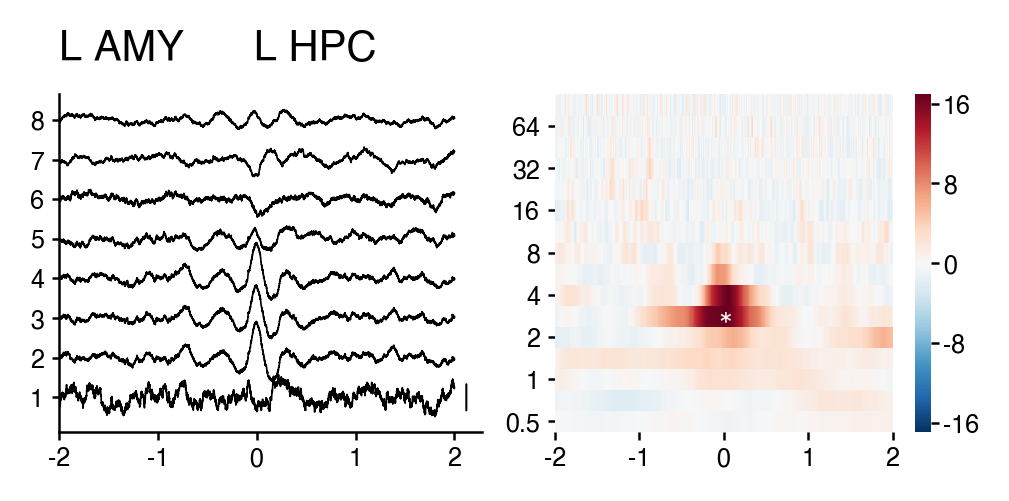

In [1709]:
iUnit = 148 #366
win = '2000'
add_labels = False
# -------------------------
      
info = df.iloc[iUnit]
st_lfp, offsets = spike_triggered_lfp(info, subj_df, time_win=wins[win]['time_win'], spike_shift=0, step=wins[win]['step'])

mpl.rcParams['xtick.major.width'] = 0.6
mpl.rcParams['ytick.major.width'] = 0.6
mpl.rcParams['axes.linewidth'] = 0.6
mpl.rcParams['xtick.major.size'] = 1.8
mpl.rcParams['ytick.major.size'] = 1.8
mpl.rcParams['xtick.major.pad'] = 1.8
mpl.rcParams['ytick.major.pad'] = 1.8

fig, ax = plt.subplots(1, 2, figsize=(colws[1], colws[1]*0.4841), dpi=300)
ax = np.ravel(ax)
tickfontsize = 6
labelfontsize = 8
figfontsize = 10

# -------------------------
# Spike-triggered LFP
i = 0
for iChan in range(st_lfp.shape[0]):
    ax[i].plot(st_lfp[iChan, :], linewidth=0.4, color='k')
xmax = 1.07 * (int(win)*4) / wins[win]['step']
xruler = 1.03 * (int(win)*4) / wins[win]['step']
ax[i].set_xlim([0, xmax])
ax[i].set_xticks(wins[win]['xticks'])
ax[i].set_xticklabels(wins[win]['xticklabels'], fontsize=tickfontsize)
ax[i].set_yticks(offsets)
ax[i].set_yticklabels(np.arange(1, 1 + st_lfp.shape[0], dtype=int), fontsize=tickfontsize)
ax[i].grid(False)
ax[i].annotate('', xy=(xruler, -5), xytext=(xruler, 5), arrowprops=dict(arrowstyle="-", color='k', linewidth=0.5))
# ax[i].annotate('', xy=(xruler, -15), xytext=(xruler, 15), arrowprops=dict(arrowstyle="-", color='k', linewidth=0.5))
ax[i].annotate('{}'.format(fmt_str(info, False)).replace('CTX', 'STG'), xy=(0, 1.1), xycoords='axes fraction', fontsize=figfontsize)
if add_labels:
    ax[i].set_xlabel('Time to spike (sec)', fontsize=labelfontsize, labelpad=2.3)
    ax[i].set_ylabel('HPC microwire', fontsize=labelfontsize, labelpad=2.3)
    ax[i].annotate('10$\mu$V', xy=(xruler, 0), xytext=(xruler, 0), fontsize=tickfontsize)
else:
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

# -------------------------
# Offset-frequency plot
i = 1
vmax = np.max(np.abs(dat[iUnit, :, :]))
vmin = -vmax
freq_ind, time_ind = np.unravel_index(dat[iUnit, :, :].argmax(), dat[iUnit, :, :].shape)
ax[i] = sns.heatmap(dat[iUnit, :, :], vmin=vmin, vmax=vmax, cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i])
# ax[i].plot(np.array(freq_ind), np.array(time_ind), marker='*', markersize=10, color='w')
ax[i].plot([time_ind], [freq_ind + 0.32], marker='$*$', alpha=1, markersize=4, markerfacecolor='w', markeredgewidth=0.1, markeredgecolor='w')
ax[i].set_xticks(np.arange(0, 401, 100))
ax[i].set_xticklabels(np.linspace(-2, 2, num=5, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(len(freqs))[::2] + 0.5)
ax[i].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfontsize)
ax[i].invert_yaxis()
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize, pad=1)
cbar.set_ticks(np.linspace(int(vmin), int(vmax), 5))
# cbar.set_ticklabels([str(np.round(x, 1)).strip(".0") if x != 0 else "0" for x in np.linspace(int(vmin), int(vmax), 5)])
cbar.set_ticklabels([str(np.round(x, 1)) if str(np.round(x, 1)).find(".0") == -1 else str(np.round(x, 1))[:-2] 
                     for x in np.linspace(int(vmin), int(vmax), 5)])

if add_labels:
    ax[i].set_xlabel('Time shift (sec)', fontsize=labelfontsize, labelpad=2.3)
    ax[i].set_ylabel('Freq (Hz)', fontsize=labelfontsize, labelpad=0)
    cbar.set_label('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=2)
#     ax[i].annotate('', xy=(0, -0.11), xycoords='axes fraction', xytext=(1, -0.11), 
#                    arrowprops=dict(arrowstyle="<->", color='k'))
#     ax[i].annotate('Spikes lag LFP', xy=(0.095, -0.17), xycoords='axes fraction', fontsize=tickfontsize)
#     ax[i].annotate('Spikes lead LFP', xy=(0.575, -0.17), xycoords='axes fraction', fontsize=tickfontsize)
else:
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    cbar.set_label('')

fig.tight_layout(pad=0.5, rect=(0, 0, 1, 1))

mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['xtick.major.size'] = 3.5
mpl.rcParams['ytick.major.size'] = 3.5
mpl.rcParams['xtick.major.pad'] = 3.5
mpl.rcParams['ytick.major.pad'] = 3.5

# print(info.subj_sess, 'unit{} ({}), chan{} ({:.1f}Hz)'.format(info.unit, iUnit, info.unit_chan_ind, info.unit_fr), info.unit_hemroi, info.lfp_hemroi, 
#       'iFreq {} ({:.1f} Hz)'.format(info.locked_freq_ind_z, freqs[info.locked_freq_ind_z]), 
#       '{} ms'.format(time_steps_ms[time_ind]), 'Z-MRL = {:.1f}'.format(vmax), 'LFP chans: {}'.format(info.lfp_chan_inds), sep=', ')
      
if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/example_phase_locking-iUnit{}-{}-{}_to_{}_iFreq{}-FR_{:.1f}Hz.pdf'
                .format(iUnit, info.subj_sess, info.unit_hemroi, info.lfp_hemroi, info.locked_freq_ind_z, info.unit_fr), 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/example_phase_locking-iUnit{}-{}-{}_to_{}_iFreq{}-FR_{:.1f}Hz.png'
                .format(iUnit, info.subj_sess, info.unit_hemroi, info.lfp_hemroi, info.locked_freq_ind_z, info.unit_fr), 
                format='png', dpi=300, bbox_inches='tight')

**Bilat examples:**
247, 248; 436, 435

In [1131]:
hpc_pl_df.query("(subj_sess=='U395_ses1') & (unit_hemroi=='REC') & (same_hem==True)")
# df.query("(subj_sess_unit=='U370_env1_22')")
df.query("(subj_sess_unit=='U395_ses1_8')")

subj  sess  subj_sess subj_sess_unit subj_unit_chan unit unit_chan_ind  \
383  U395     1  U395_ses1    U395_ses1_8        U395_11    8            10   
384  U395     1  U395_ses1    U395_ses1_8        U395_11    8            10   

    unit_hemroi unit_hem unit_roi unit_is_hpc  unit_nspikes   unit_fr  \
383         REC        R       EC           0           426  0.282707   
384         REC        R       EC           0           426  0.282707   

    lfp_hemroi lfp_hem lfp_roi  lfp_is_hpc  same_chan  same_hemroi  same_hem  \
383        LAH       L      AH        True      False        False     False   
384        RAH       R      AH        True      False        False      True   

     same_roi  both_hpc unit_hemroi2 lfp_hemroi2 unit_roi2 lfp_roi2  \
383     False     False          rec        lhpc        ec      hpc   
384     False     False          rec        rhpc        ec      hpc   

     same_roi2                     lfp_chan_inds     edge  unit_nsamp_spikes  \
383      False  [40, 41, 42, 43, 44, 45, 46, 47]  ctx-hpc                426   
384      False  [16, 17, 18, 19, 20, 21, 22, 23]  ctx-hpc                426   

                                            spike_inds  \
383  [5237, 22633, 22767, 37301, 37524, 37528, 4557...   
384  [5237, 22633, 22767, 37301, 37524, 37528, 4557...   

                                               bs_mrls  \
383  [[0.049087733, 0.04539381, 0.04850755, 0.04739...   
384  [[0.055771373, 0.04135746, 0.050865866, 0.0498...   

                                               tl_mrls  \
383  [[0.05642559, 0.056527082, 0.056610294, 0.0566...   
384  [[0.07091157, 0.07109754, 0.07129342, 0.071497...   

                                             bs_mrls_z  \
383  [[-0.04864267, -0.46595258, -0.11418723, -0.23...   
384  [[0.6738188, -0.9120501, 0.13409781, 0.0178063...   

                                             tl_mrls_z  \
383  [[-0.42249316, -0.43906426, -0.4481606, -0.465...   
384  [[-0.22466174, -0.23454861, -0.24201234, -0.24...   

                                                mrls_z  locked_freq_ind_z  \
383  [0.002915673, -0.82697356, -0.5647563, -0.9019...                  4   
384  [2.1906383, 2.8670328, 0.49337956, 1.3187375, ...                  5   

     locked_mrl_z  bs_ind_z  bs_pval_z  sig_z  tl_locked_freq_z  \
383      7.287834         0   0.000999   True                 4   
384     11.956956         0   0.000999   True                 5   

     tl_locked_time_z  tl_locked_mrl_z  pref_phase  \
383              -460         9.394768    2.280738   
384              -100        12.149930    0.159976   

                                         phase_offsets  \
383  [2.2051475, 0.5097239, 0.41885328, 2.513742, 2...   
384  [1.0196157, 1.9201615, 2.8188145, 1.8839456, 2...   

     pref_phase_tl_locked_time_freq_z  \
383                          2.258360   
384                          2.120165   

                   phase_offsets_tl_locked_time_freq_z unit_roi3     roi  \
383  [1.8361256, 0.8139807, 0.43667555, 2.063911, 2...        ec  contra   
384  [1.472617, 1.6340655, 2.6603935, 1.5260383, 1....        ec      ec   

    roi_unit_to_lfp  pl_freq  pl_strength  pl_time_shift  pl_latency  \
383         ec_cont        4     9.394768         -460.0       460.0   
384         ec_ipsi        5    12.149930         -100.0       100.0   

     sig_z_fdr  pl_duration  pl_cycles  
383       True          NaN        NaN  
384       True          NaN        NaN

U370_env1, unit22 chan38 (2.1Hz), LA, LAH, iFreq 10 (16.0 Hz), 10.0 ms, Z-MRL = 11.4, LFP chans: [40, 41, 42, 43, 44, 45, 46, 47]
U370_env1, unit22 chan38 (2.1Hz), LA, RAH, iFreq 4 (2.0 Hz), 200.0 ms, Z-MRL = 11.4, LFP chans: [8, 9, 10, 11, 12, 13, 14, 15]


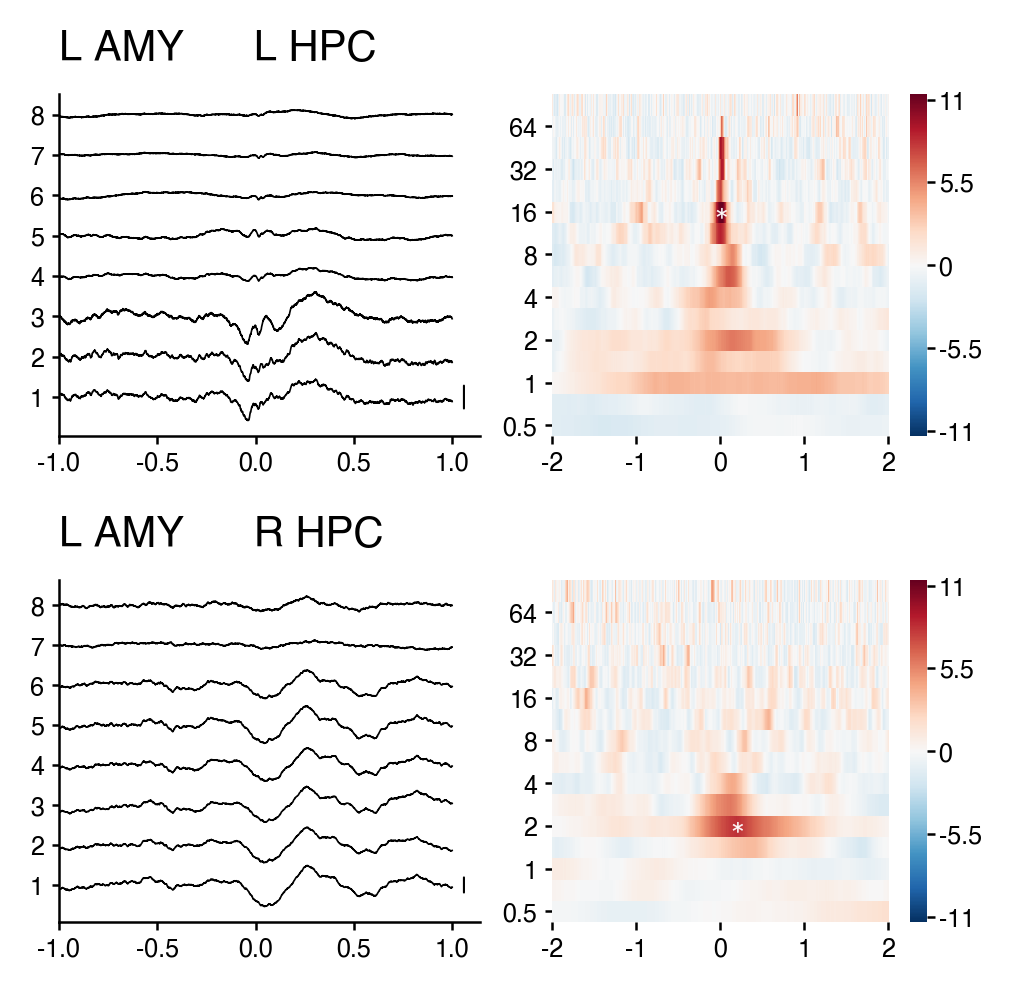

In [1330]:
# 292, 34, 159, 204, 170, 30
iUnits = [215, 216]
# iUnits = [384, 383]
win = '1000'
add_labels = False
# -------------------------
      
mpl.rcParams['xtick.major.width'] = 0.6
mpl.rcParams['ytick.major.width'] = 0.6
mpl.rcParams['axes.linewidth'] = 0.6
mpl.rcParams['xtick.major.size'] = 1.8
mpl.rcParams['ytick.major.size'] = 1.8
mpl.rcParams['xtick.major.pad'] = 1.8
mpl.rcParams['ytick.major.pad'] = 1.8

fig, ax = plt.subplots(2, 2, figsize=(colws[1], colws[1]*0.9682), dpi=300)
ax = np.ravel(ax)
tickfontsize = 6
labelfontsize = 8
figfontsize = 10

lfp_rois = []
vmax = np.max(np.abs(dat[iUnits, :, :]))
vmin = -vmax
for ii in range(2):
    iUnit = iUnits[ii]
    info = df.iloc[iUnit]
    lfp_rois.append(info.lfp_hemroi)
    st_lfp, offsets = spike_triggered_lfp(info, subj_df, time_win=wins[win]['time_win'], spike_shift=0) # time_steps[time_ind]; BE CAREFUL

    i = 2 * ii
    for iChan in range(st_lfp.shape[0]):
        ax[i].plot(st_lfp[iChan, :], linewidth=0.4, color='k')
    xmax = 1.07 * (int(win)*4)
    xruler = 1.03 * (int(win)*4)
    xrulerlabel = 1.03 * (int(win)*4)
    ax[i].set_xlim([0, xmax])
    ax[i].set_xticks(wins[win]['xticks'])
    ax[i].set_xticklabels(wins[win]['xticklabels'], fontsize=tickfontsize)
    ax[i].set_yticks(offsets)
    ax[i].set_yticklabels(np.arange(1, 1 + st_lfp.shape[0], dtype=int), fontsize=tickfontsize)
    ax[i].grid(False)
#     ax[i].annotate('', xy=(xruler, -25), xytext=(xruler, 25), arrowprops=dict(arrowstyle="-", color='k', linewidth=0.5))
    ax[i].annotate('', xy=(xruler, -15), xytext=(xruler, 15), arrowprops=dict(arrowstyle="-", color='k', linewidth=0.5))
    ax[i].annotate('{}'.format(fmt_str(info)).replace('A', 'AMY'), xy=(0, 1.1), xycoords='axes fraction', fontsize=figfontsize)
    if add_labels:
        ax[i].set_xlabel('Time to spike (sec)', fontsize=labelfontsize, labelpad=2.3)
        ax[i].set_ylabel('HPC microwire', fontsize=labelfontsize, labelpad=2.3)
        ax[i].annotate('10$\mu$V', xy=(xrulerlabel, 0), xytext=(xrulerlabel, 0), fontsize=tickfontsize)
    else:
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

    # -------------------------
    i += 1
    freq_ind, time_ind = np.unravel_index(dat[iUnit, :, :].argmax(), dat[iUnit, :, :].shape)
    ax[i] = sns.heatmap(dat[iUnit, :, :], vmin=vmin, vmax=vmax, cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i])
    ax[i].plot(np.array(freq_ind), np.array(time_ind), marker='*', markersize=10, color='w')
    ax[i].plot([time_ind], [freq_ind + 0.32], marker='$*$', alpha=1, markersize=4, markerfacecolor='w', markeredgewidth=0.1, markeredgecolor='w')
    ax[i].set_xticks(np.arange(0, 401, 100))
    ax[i].set_xticklabels(np.linspace(-2, 2, num=5, dtype=int), fontsize=tickfontsize, rotation=0)
    ax[i].set_yticks(np.arange(len(freqs))[::2] + 0.5)
    ax[i].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfontsize)
    ax[i].invert_yaxis()
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=tickfontsize, pad=1)
    cbar.set_ticks(np.linspace(int(vmin), int(vmax), 5))
    cbar.set_ticklabels([str(np.round(x, 1)) if str(np.round(x, 1)).find(".0") == -1 else str(np.round(x, 1))[:-2] 
                         for x in np.linspace(int(vmin), int(vmax), 5)])

    if add_labels:
        ax[i].set_xlabel('Time shift (sec)', fontsize=labelfontsize, labelpad=2.3)
        ax[i].set_ylabel('Freq (Hz)', fontsize=labelfontsize, labelpad=0)
        cbar.set_label('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=2)
    #     ax[i].annotate('', xy=(0, -0.11), xycoords='axes fraction', xytext=(1, -0.11), 
    #                    arrowprops=dict(arrowstyle="<->", color='k'))
    #     ax[i].annotate('Spikes lag LFP', xy=(0.095, -0.17), xycoords='axes fraction', fontsize=tickfontsize)
    #     ax[i].annotate('Spikes lead LFP', xy=(0.575, -0.17), xycoords='axes fraction', fontsize=tickfontsize)
    else:
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        cbar.set_label('')
        
    print(info.subj_sess, 'unit{} chan{} ({:.1f}Hz)'.format(info.unit, info.unit_chan_ind, info.unit_fr), info.unit_hemroi, info.lfp_hemroi, 
          'iFreq {} ({:.1f} Hz)'.format(info.locked_freq_ind_z, freqs[info.locked_freq_ind_z]), 
          '{} ms'.format(time_steps_ms[time_ind]), 'Z-MRL = {:.1f}'.format(vmax), 'LFP chans: {}'.format(info.lfp_chan_inds), sep=', ')

fig.tight_layout(pad=0.5, h_pad=1, rect=(0, 0, 1, 1))

mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['xtick.major.size'] = 3.5
mpl.rcParams['ytick.major.size'] = 3.5
mpl.rcParams['xtick.major.pad'] = 3.5
mpl.rcParams['ytick.major.pad'] = 3.5

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/example_bilat_phase_locking-iUnit{}-{}-{}_to_{}_iFreq{}_30uV.pdf'
                .format(iUnit, info.subj_sess, info.unit_hemroi, '_'.join(lfp_rois), info.locked_freq_ind_z), 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/example_bilat_phase_locking-iUnit{}-{}-{}_to_{}_iFreq{}_30uV.png'
                .format(iUnit, info.subj_sess, info.unit_hemroi, '_'.join(lfp_rois), info.locked_freq_ind_z), 
                format='png', dpi=300, bbox_inches='tight')

In [ ]:
# theta peak is 0; trough is π

In [48]:
ts = np.expand_dims(np.array([np.sin(x) for x in np.linspace(0, 2 * np.pi * 20, 200 * 5)]), axis=0)
ts = TimeSeries(ts, name='sine wave', 
                dims=['channel', 'time'], 
                coords={'channel': np.arange(ts.shape[0]),
                        'time': np.arange(ts.shape[1]),
                        'samplerate': 200})
ts_phase = manning_analysis.run_morlet(ts, freqs=[4], output='phase', savedir=None)

CPP total time wavelet loop:  0.0012335777282714844


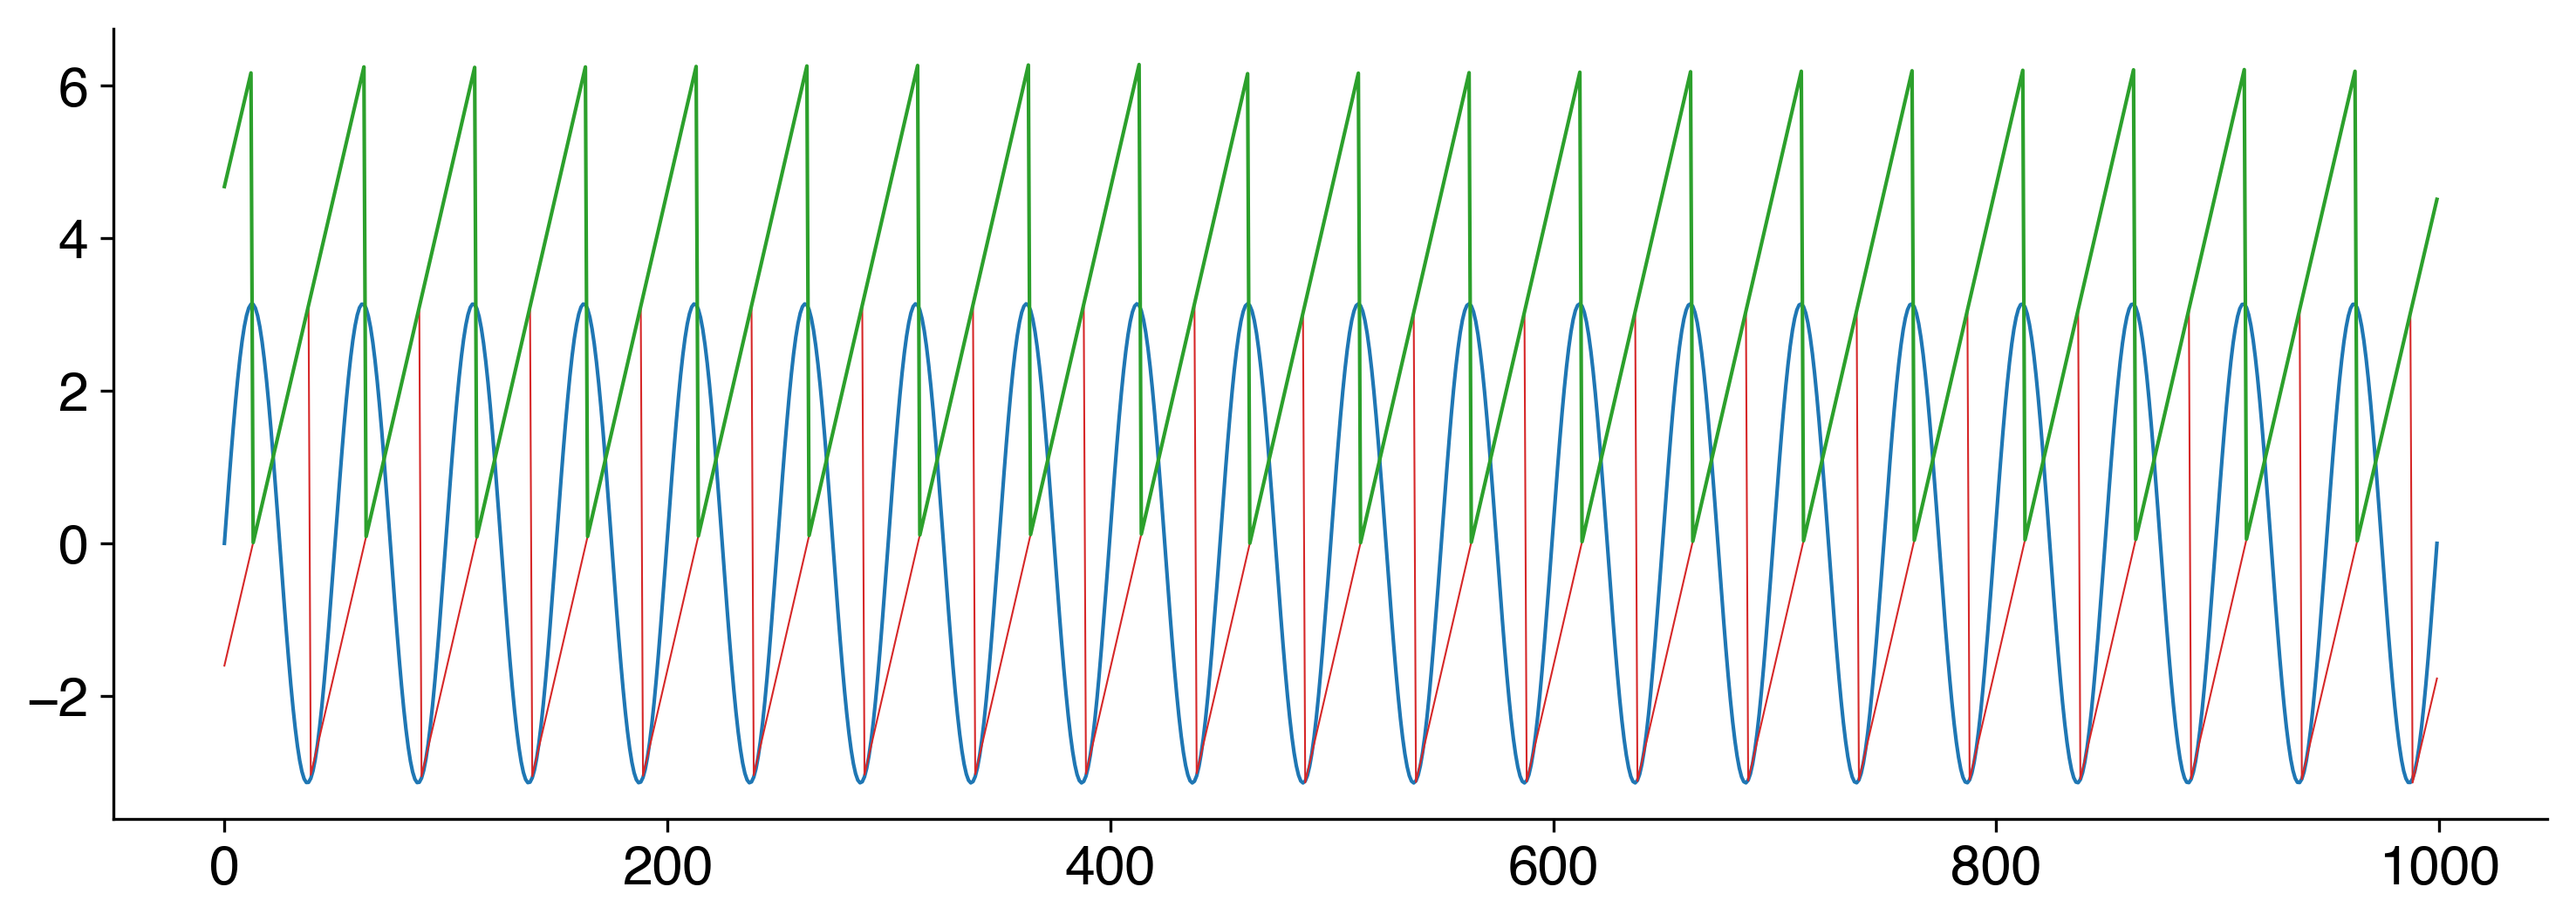

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=300)

ax.plot(ts.data.squeeze() * np.pi)
ax.plot(ts_phase.data.squeeze(), linewidth=0.5)
ax.plot(phase_locking.convert_radians(ts_phase.data.squeeze()))

## Phase-locking by time shift

In [697]:
time_win = 2
sampling_rate = 2000
time_steps = np.arange(-time_win*sampling_rate, time_win*sampling_rate+1, sampling_rate*0.01, dtype=int)
time_steps_ms = (time_steps / sampling_rate) * 1000

In [697]:
(pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True)").
 groupby('lfp_roi')
 .agg({'unit': len, 'pl_freq': lambda x: np.mean(freqs[x]), 'locked_freq_ind_z': lambda x: np.mean(freqs[x])}))

unit   pl_freq  locked_freq_ind_z
lfp_roi                                   
AH        246  4.839318           4.816527
MH         65  4.995604           5.336064
PH         51  3.324008           3.509297

In [244]:
# cmap = sns.palettes.blend_palette((colors[0], 
#                                    sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
#                                    sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
#                                    colors[1]), 101)
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

len(cmap)

501

In [698]:
np.mean(hpc_pl_df['pl_time_shift']), np.std(hpc_pl_df['pl_time_shift'])

(-68.84937238493724, 255.7353297870275)

In [245]:
np.mean(hpc_pl_df['tl_locked_time_z']), np.std(hpc_pl_df['tl_locked_time_z'])

(-100.75356415478615, 439.0176526642644)

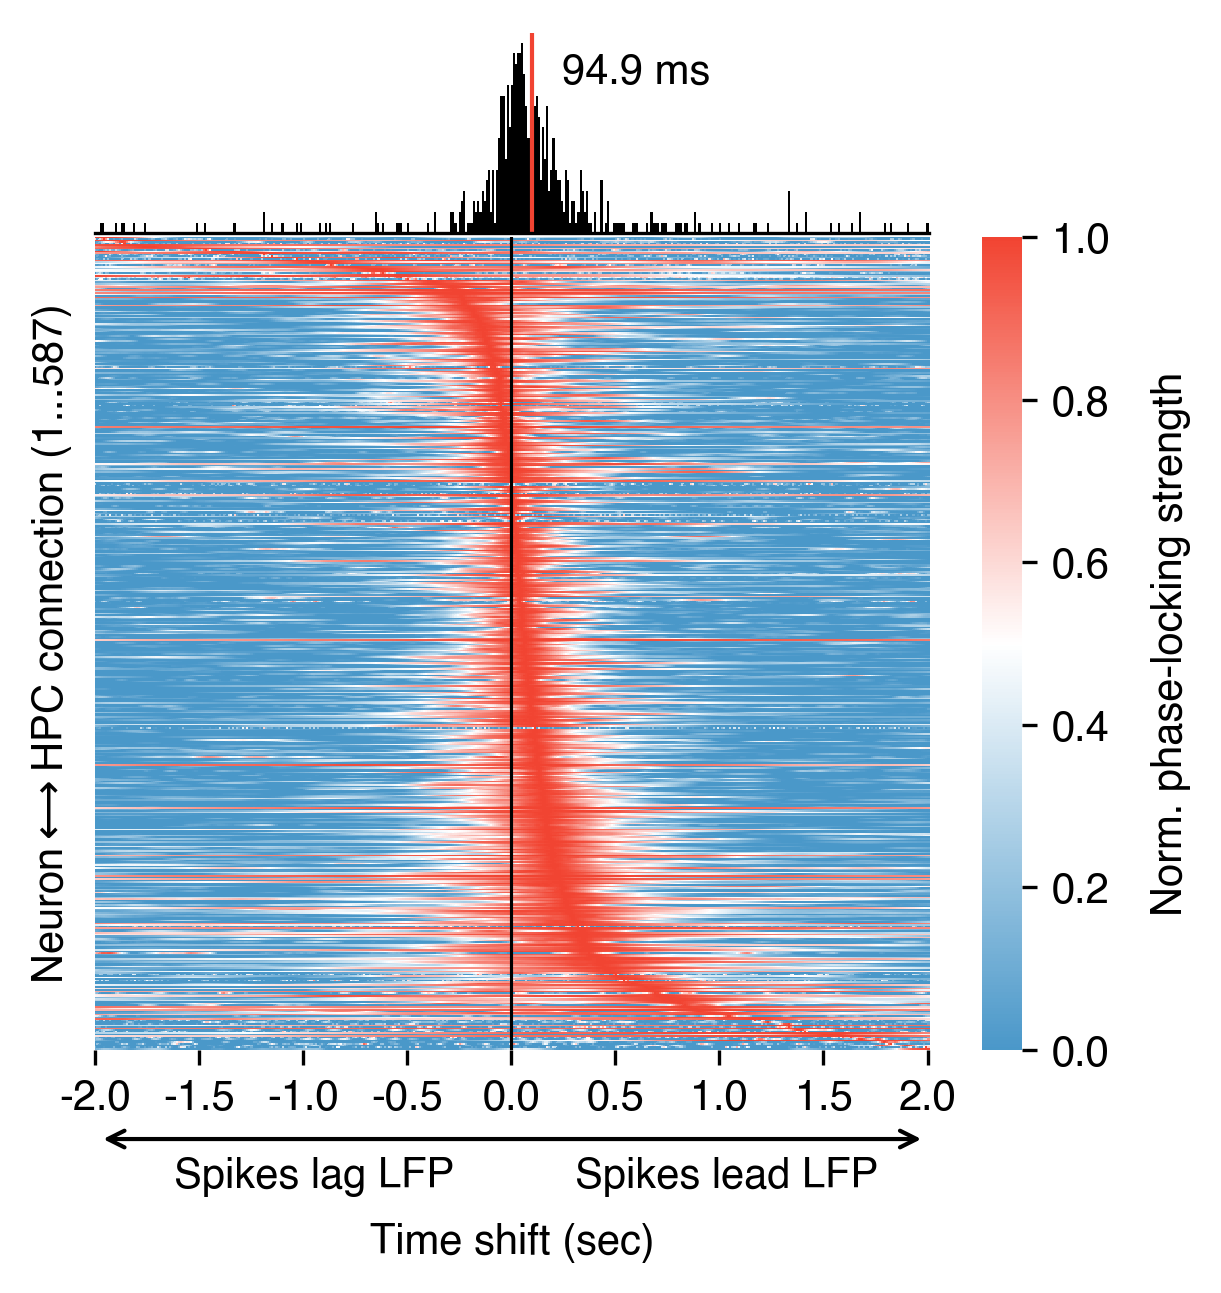

In [29]:
hpc_tl_mrls = np.flip(hpc_pl_df
                      .sort_values(['tl_locked_time_z'], ascending=False)
                      .apply(lambda x: x.tl_mrls_z[x.tl_locked_freq_z, :], axis=1).tolist(), 
                      axis=-1)

fig = plt.figure(figsize=(4.48819, 4.48819), dpi=300)
ax = [plt.subplot2grid((50, 50), (0, 0), rowspan=10, colspan=40),
      plt.subplot2grid((50, 50), (10, 0), rowspan=40, colspan=50)]

tickfontsize = 10
labelfontsize = 10

hpc_d = (pl_df
         .query("(sig_z_fdr==True) & (edge=='ctx-hpc')")
         .groupby('tl_locked_time_z')
         .size()
         .to_dict())
counts = []
for i in np.arange(-2000, 2001, 10)[::-1]: # flipping times back
    counts.append([hpc_d.get(i, 0)])
counts = pd.DataFrame(counts, columns=['hpc']).reset_index()

i = 0
ax[i].bar(counts.index, counts.hpc, width=1, color='k')
locked_times = -np.array(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc')").tl_locked_time_z.tolist())
ax[i].axvline(np.interp(np.mean(locked_times), np.linspace(-2000, 2000, 401), np.arange(401)), 
              color=colors[1], linewidth=1, linestyle='-')
ax[i].set_xlim([0, 400])
ax[i].set_xticks(np.arange(0, 401, 50))
ax[i].set_xticklabels('')
ax[i].set_xticks([])
ax[i].set_yticks([])
ax[i].set_xlabel('')
ax[i].set_ylabel('')
ax[i].spines['left'].set_visible(False)
ax[i].grid(False)
ax[i].annotate('{:.1f} ms'.format(np.mean(locked_times)), xy=(0.56, 0.75), 
                                  color='k', xycoords='axes fraction', fontsize=tickfontsize)

i = 1
sns.heatmap((hpc_tl_mrls[:, :].T / np.max(hpc_tl_mrls, axis=1)).T, ax=ax[i], 
             vmin=0, vmax=1, cmap=cmap, cbar=True)
ax[i].axvline(x=200, color='k', linewidth=0.75, alpha=1)
ax[i].set_xticks(np.arange(0, 401, 50))
ax[i].set_xticklabels(np.arange(-2, 2.1, 0.5), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks([])
ax[i].set_xlabel('Time shift (sec)', fontsize=labelfontsize, labelpad=25)
ax[i].set_ylabel('Neuron$\longleftrightarrow$HPC connection (1...587)', fontsize=labelfontsize, labelpad=5)
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. phase-locking strength', fontsize=tickfontsize)

ax[i].annotate('', xy=(0, -0.11), xycoords='axes fraction', xytext=(1, -0.11), 
               arrowprops=dict(arrowstyle="<->", color='k'))
ax[i].annotate('Spikes lag LFP', xy=(0.095, -0.17), xycoords='axes fraction', fontsize=tickfontsize)
ax[i].annotate('Spikes lead LFP', xy=(0.575, -0.17), xycoords='axes fraction', fontsize=tickfontsize)

#fig.tight_layout(pad=1, h_pad=0)

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/phase_locking_by_time.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/phase_locking_by_time.png', 
                format='png', dpi=300, bbox_inches='tight')

In [685]:
pd.DataFrame(np.array(np.where(dat>2)))

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   \
0    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2   
1  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170   

   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   \
0    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2   
1  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185   

   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   \
0    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2   
1  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200   

   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   \
0    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2   
1  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215   

   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   \
0    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2   
1  216  217  218  219  220  221  222  223  224  225  226  227  228  229  230   

   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   \
0    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2   
1  231  232  233  234  235  236  237  238  239  240  241  242  243  244  245   

   90   91   92   93   94   95   96   97   98   99   100  101  102  103  104  \
0    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2   
1  246  247  248  249  250  251  252  253  254  255  256  257  258  259  260   

   105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  \
0    2    2    2    2    2    2    2    2    2    2    2    2    2    2    2   
1  261  262  263  264  265  266  267  268  269  270  271  272  273  274  275   

   120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  \
0    2    2    2    2    2    2    2    2    2    2    3    3    3    3    3   
1  276  277  278  279  280  281  282  283  284  285  137  138  139  140  141   

   135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  \
0    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3   
1  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156   

   150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  \
0    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3   
1  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171   

   165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  \
0    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3   
1  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186   

   180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  \
0    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3   
1  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201   

   195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  \
0    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3   
1  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216   

   210  211  212  213  214  215  216  217  218  219  220  221  222  223  224  \
0    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3   
1  217  218  219  220  221  222  223  224  225  226  227  228  229  230  231   

   225  226  227  228  229  230  231  232  233  234  235  236  237  238  239  \
0    3    3    3    3    3    3    3    3    3    3    3    3    3    3    3   
1  232  233  234  235  236  237  238  239  240  241  242  243  244  245  246   

   240  241  242  243  244  245  246  247  248  249  250  251  252  253  254  \
0    3    3    3    3    3    3    3    3    3    3    3    3    3 

In [686]:
2, 156, 285
3, 137, 293
4, 157, 262
5, 170, 245
6, 180, 227
7, 192, 213

(16, 401)

In [701]:
Path = mpath.Path
path_data = [(Path.MOVETO, (2, 156 - 1)),
             (Path.LINETO, (2, 285 + 1)),
             (Path.LINETO, (3, 285 + 1)),
             (Path.LINETO, (3, 293 + 1)),
             (Path.LINETO, (4, 293 + 1)),
             (Path.LINETO, (4, 262 + 1)),
             (Path.LINETO, (5, 262 + 1)),
             (Path.LINETO, (5, 245 + 1)),
             (Path.LINETO, (6, 245 + 1)),
             (Path.LINETO, (6, 227 + 1)),
             (Path.LINETO, (7, 227 + 1)),
             (Path.LINETO, (7, 213 + 1)),
             (Path.LINETO, (8, 213 + 1)),
             (Path.LINETO, (8, 192 - 1)),
             (Path.LINETO, (7, 192 - 1)),
             (Path.LINETO, (7, 180 - 1)),
             (Path.LINETO, (6, 180 - 1)),
             (Path.LINETO, (6, 170 - 1)),
             (Path.LINETO, (5, 170 - 1)),
             (Path.LINETO, (5, 157 - 1)),
             (Path.LINETO, (4, 157 - 1)),
             (Path.LINETO, (4, 137 - 1)),
             (Path.LINETO, (3, 137 - 1)),
             (Path.LINETO, (3, 156 - 1)),
             (Path.LINETO, (3, 156 - 1)),
             (Path.CLOSEPOLY, (2, 156 - 1))]
codes, verts = zip(*path_data)
path = mpath.Path(verts, codes)
patch = patches.PathPatch(path, facecolor='r', alpha=0.5)
x, y = zip(*path.vertices)

In [354]:
hpc_pl_df.shape, hpc_pl_df.query("(tl_locked_time_z_abs<=500)").shape, len(hpc_pl_df.query("(tl_locked_time_z_abs<=500)")) / len(hpc_pl_df)

((491, 55), (432, 55), 0.879837067209776)

In [342]:
freqs[freq_ind], time_steps_ms[time_ind]

(2.0, 100.0)

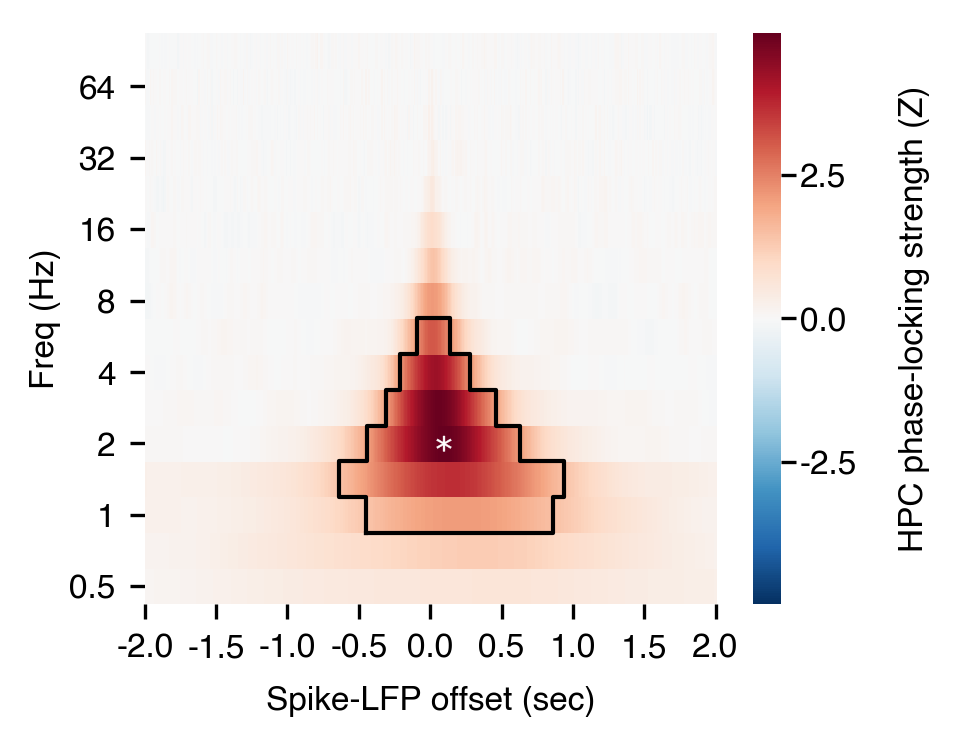

In [703]:
# Get the average time-lag Z-MRL matrix.
mean_tl_mrls_z = np.mean(hpc_pl_df.query("(pl_latency<=500)").tl_mrls_z.tolist(), axis=0) # freq x time_shift
dat = np.flip(mean_tl_mrls_z, axis=-1)
freq_ind, time_ind = np.unravel_index(dat[:, :].argmax(), dat[:, :].shape)

fig, ax = plt.subplots(1, 1, figsize=(3.34646-.34646, 4.01575 * 0.57), dpi=300)
ax = np.ravel(ax)

tickfontsize = 8
labelfontsize = 8

i = 0
vmax = np.max(np.abs(dat))
vmin = -vmax
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i])
# ax[i].axvline(x=200, color='k', linewidth=0.33, alpha=1)
ax[i].add_patch(patch)
ax[i].plot(y, x, color='k', linewidth=1)
ax[i].plot([time_ind], [freq_ind + 0.36], marker='$*$', alpha=1, markersize=6, markerfacecolor='w', markeredgewidth=0.1, markeredgecolor='w')

ax[i].set_xticks(np.arange(0, 401, 50))
ax[i].set_xticklabels(np.arange(-2, 2.1, 0.5), fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Spike-LFP offset (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].invert_yaxis()
ax[i].set_yticks(np.arange(len(freqs))[::2] + 0.5)
ax[i].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfontsize)
ax[i].set_ylabel('Freq (Hz)', fontsize=labelfontsize, labelpad=2)

cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize, pad=1)
cbar.set_ticks([-5.0, -2.5, 0.0, 2.5, 5.0])
cbar.set_ticklabels([-5.0, -2.5, 0.0, 2.5, 5.0])
cbar.set_label('HPC phase-locking strength (Z)', fontsize=labelfontsize)

fig.tight_layout(pad=0, h_pad=-0.3)

if False:
#     fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/phase_locking_by_time_1.pdf', 
#                 format='pdf', bbox_inches='tight')
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/mean_phase_locking_freq_time_matrix.png', 
                format='png', dpi=600, bbox_inches='tight')

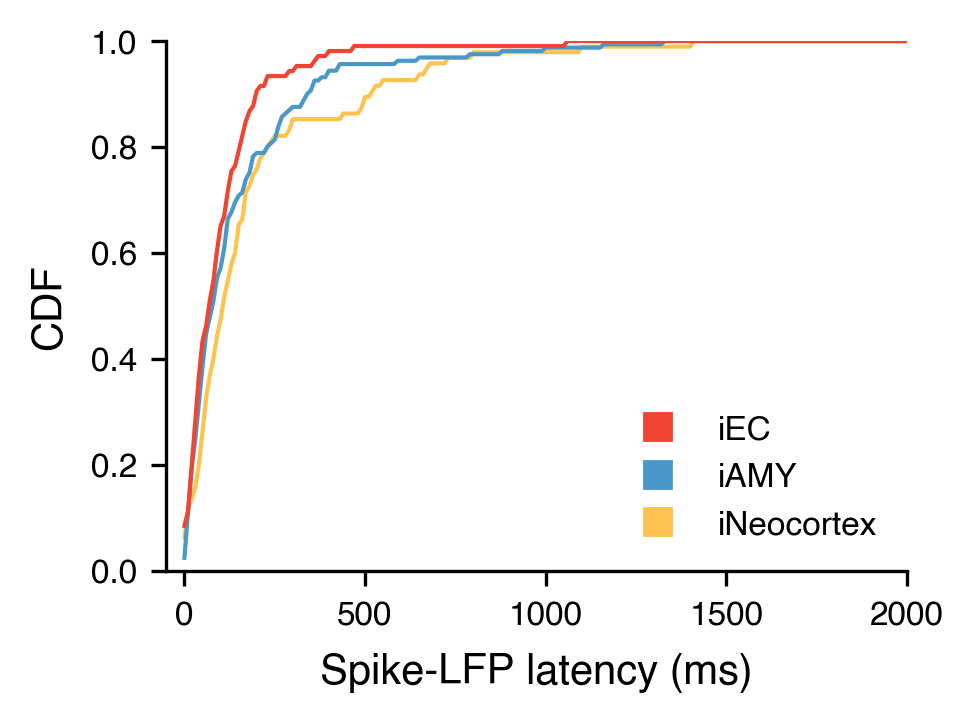

In [710]:
fig, ax = plt.subplots(1, 1, figsize=(3.34646, 3.34646*0.75), dpi=300)
ax = np.ravel(ax)

tickfontsize = 8
labelfontsize = 10

color_inds = [6, 0, 1]
rois = ['ctx', 'amy', 'ec']

i = 0
for iRoi, roi in enumerate(rois):
    hpc_d = (pl_df
             .query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True) & (roi=='{}')".format(roi))
             .groupby('pl_latency')
             .size()
             .to_dict())
    counts = []
    for iTime in np.arange(0, 2001, 10): # flipping times back
        counts.append([hpc_d.get(iTime, 0)])
    counts = pd.DataFrame(counts, columns=['hpc']).reset_index()
    counts['cdf'] = np.cumsum(counts['hpc']) / np.sum(counts['hpc'])
    counts['latency'] = np.arange(0, 2001, 10)
    ax[i].plot(counts['latency'], counts['cdf'], color=colors[color_inds[iRoi]], linewidth=1)
        
ax[i].set_xlim([-50, 2000])
ax[i].set_xticks(np.arange(0, 2001, 500, dtype=int))
ax[i].set_xticklabels(np.arange(0, 2001, 500, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Spike-LFP latency (ms)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylim([0, 1])
ax[i].set_yticks(np.linspace(0, 1, 6))
ax[i].set_yticklabels(['{:.1f}'.format(x) for x in np.linspace(0, 1, 6)], fontsize=tickfontsize)
ax[i].set_ylabel('CDF', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='iEC', markerfacecolor=colors[1], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='iAMY', markerfacecolor=colors[0], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='iNeocortex', markerfacecolor=colors[6], markersize=tickfontsize)]
legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=4)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_time_by_roi_cdf.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/hpc_phase_locking_time_by_roi_cdf.png', 
                format='png', dpi=300, bbox_inches='tight')

In [1013]:
n_sig = len(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)"))
print(len(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True) & (4<=pl_freq<=8)")),
      len(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True) & (4<=pl_freq<=8)"))/n_sig,
      len(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True) & (pl_freq<=2)")),
      len(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True) & (11<=pl_freq)")),
      np.percentile(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")['pl_freq'], 5),
      np.percentile(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")['pl_freq'], 50),
      np.percentile(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")['pl_freq'], 95),
      2**((np.mean(-pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")['pl_freq'])/2)-1),
      2**((np.std(-pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")['pl_freq'])/2)-1))

262 0.7237569060773481 31 7 2.0 5.0 9.949999999999989 3.152387613566481e+36 383948.1682137434


In [1023]:
n_sig = len(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)"))
print('{}/{} ({:.1f}%)'.format(len(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True) & (-400<=pl_time_shift<=200)")), n_sig,
                            100 * len(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True) & (-400<=pl_time_shift<=200)"))/n_sig),
      '{}/{} ({:.1f}%)'.format(len(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True) & (pl_time_shift<0)")), n_sig,
                            100 * len(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True) & (pl_time_shift<0)"))/n_sig),
      '{}/{} ({:.1f}%)'.format(len(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True) & (pl_time_shift>0)")), n_sig,
                            100 * len(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True) & (pl_time_shift>0)"))/n_sig),
      np.percentile(-pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")['pl_time_shift'], 5),
      np.percentile(-pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")['pl_time_shift'], 50),
      np.percentile(-pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")['pl_time_shift'], 95),
      np.mean(-pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")['pl_time_shift']),
      np.std(-pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")['pl_time_shift']))

327/362 (90.3%) 236/362 (65.2%) 107/362 (29.6%) -199.5 50.0 398.9999999999998 60.74585635359116 237.83611644141683


In [981]:
pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)").groupby('unit_roi3').agg({'unit': len})

unit
unit_roi3      
amy         161
ctx          95
ec          106

In [1039]:
pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)").shape

(362, 58)

In [1045]:
# Perform a paired-samples t-test across neurons within each subject,
# than a one-sample t-test on the t-stats from each subject (in
# subjects with > n_neuron_thresh neurons).
n_neuron_thresh = 7
arr = -pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)")['pl_time_shift']
subj_t_stats = (pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)")
                .groupby('subj').agg({'unit': len, 'pl_time_shift': lambda x: stats.ttest_1samp(-x, 0)[0]}).query("unit>{}".format(n_neuron_thresh))['pl_time_shift'])
mod_fit = stats.ttest_1samp(subj_t_stats, 0)

print('{:.1f} +/- {:.1f} time shift across significant neurons'.format(np.mean(arr), np.std(arr)))
print('t = {:.1f} +/- {:.1f}; t({}) = {:.1f}, p = {:.4f}'.format(np.mean(subj_t_stats), np.std(subj_t_stats), len(subj_t_stats)-1, mod_fit[0], mod_fit[1]))

60.7 +/- 237.8 time shift across significant neurons
t = 1.5 +/- 1.4; t(13) = 3.8, p = 0.0021


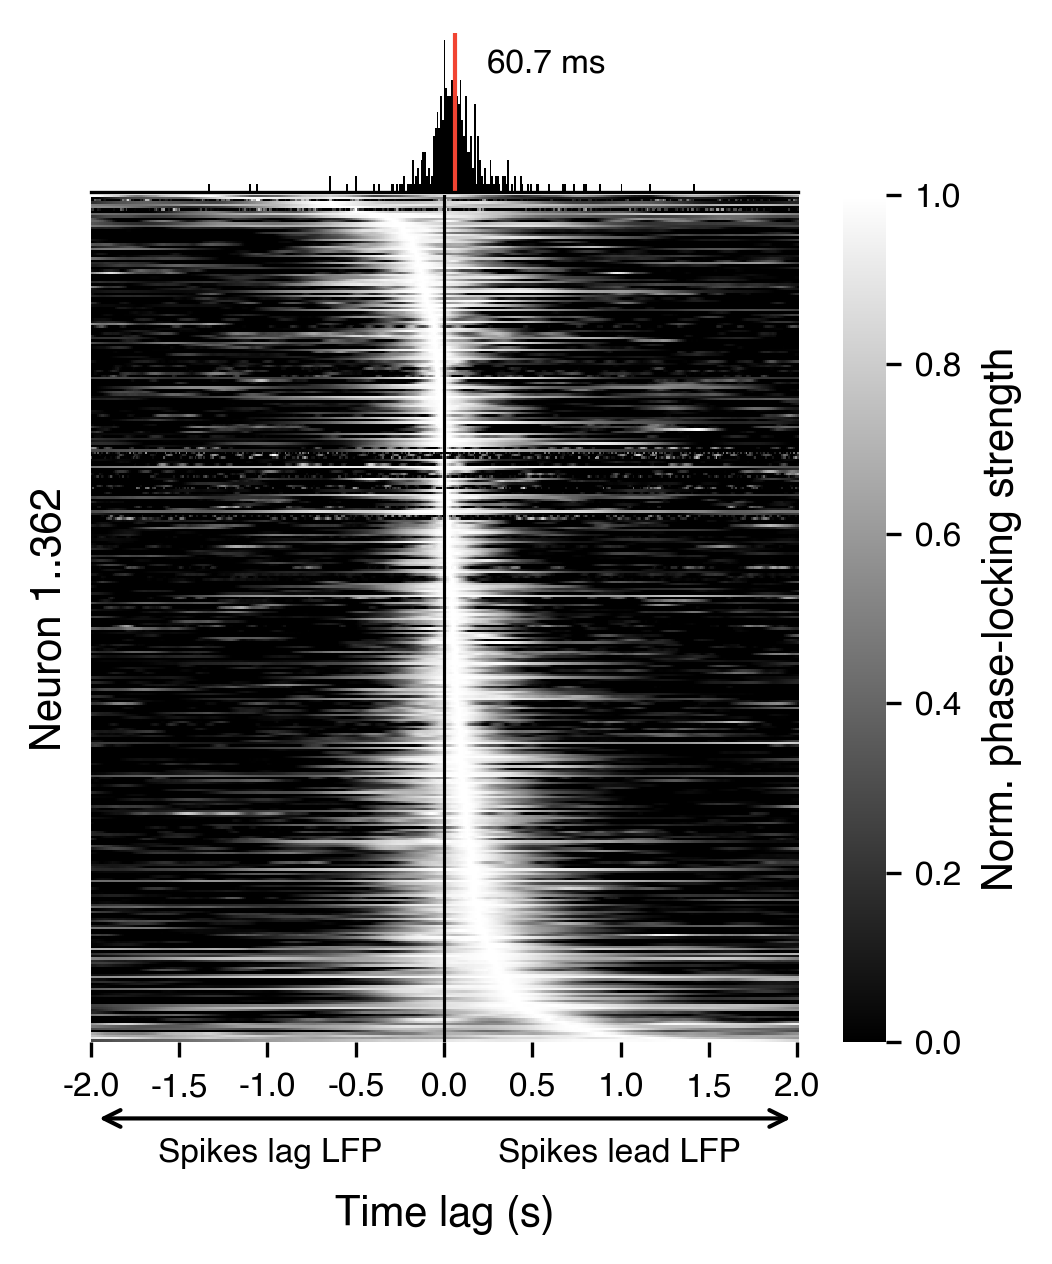

In [1027]:
hpc_tl_mrls = np.flip(pl_df
                      .query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")
                      .sort_values(['pl_time_shift'], ascending=False)
                      .apply(lambda x: x.tl_mrls_z[x.pl_freq, :], axis=1).tolist(), 
                      axis=-1)

fig = plt.figure(figsize=(colws[1], colws[1]*1.2), dpi=300)
ax = [plt.subplot2grid((50, 50), (0, 0), rowspan=8, colspan=40),
      plt.subplot2grid((50, 50), (8, 0), rowspan=45, colspan=50)]

tickfontsize = 8
labelfontsize = 10

hpc_d = (pl_df
         .query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)")
         .groupby('pl_time_shift')
         .size()
         .to_dict())
counts = []
for i in np.arange(-2000, 2001, 10)[::-1]: # flipping times back
    counts.append([hpc_d.get(i, 0)])
counts = pd.DataFrame(counts, columns=['hpc']).reset_index()

i = 0
ax[i].bar(counts.index, counts.hpc, width=1, color='k')
locked_times = -np.array(pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)").pl_time_shift.tolist())
ax[i].axvline(np.interp(np.mean(locked_times), np.linspace(-2000, 2000, 401), np.arange(401)), 
              color=colors[1], linewidth=1, linestyle='-')
ax[i].set_xlim([0, 400])
ax[i].set_xticks(np.arange(0, 401, 50))
ax[i].set_xticklabels('')
ax[i].set_xticks([])
ax[i].set_yticks([])
ax[i].set_xlabel('')
ax[i].set_ylabel('')
ax[i].spines['left'].set_visible(False)
ax[i].grid(False)
ax[i].annotate('{:.1f} ms'.format(np.mean(locked_times)), xy=(0.56, 0.75), 
                                  color='k', xycoords='axes fraction', fontsize=tickfontsize)

i = 1
sns.heatmap((hpc_tl_mrls[:, :].T / np.max(hpc_tl_mrls, axis=1)).T, ax=ax[i], 
             vmin=0, vmax=1, cmap='gray', cbar=True)
ax[i].axvline(x=200, color='k', linewidth=0.75, alpha=1)
ax[i].set_xticks(np.arange(0, 401, 50))
ax[i].set_xticklabels(np.arange(-2, 2.1, 0.5), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks([])
ax[i].set_xlabel('Time lag (s)', fontsize=labelfontsize, labelpad=22)
ax[i].set_ylabel('Neuron 1..{}'.format(hpc_tl_mrls.shape[0]), fontsize=labelfontsize, labelpad=5)
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(np.round(np.linspace(0, 1, 6), 1))
cbar.set_label('Norm. phase-locking strength', fontsize=labelfontsize, labelpad=5)

ax[i].annotate('', xy=(0, -0.09), xycoords='axes fraction', xytext=(1, -0.09), 
               arrowprops=dict(arrowstyle="<->", color='k'))
ax[i].annotate('Spikes lag LFP', xy=(0.095, -0.14), xycoords='axes fraction', fontsize=tickfontsize)
ax[i].annotate('Spikes lead LFP', xy=(0.575, -0.14), xycoords='axes fraction', fontsize=tickfontsize)

fig.tight_layout(pad=0, h_pad=-0.3)

if True:
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/phase_locking_by_time_1.pdf', 
                format='pdf', bbox_inches='tight')
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/phase_locking_by_time_1.png', 
                format='png', dpi=600, bbox_inches='tight')

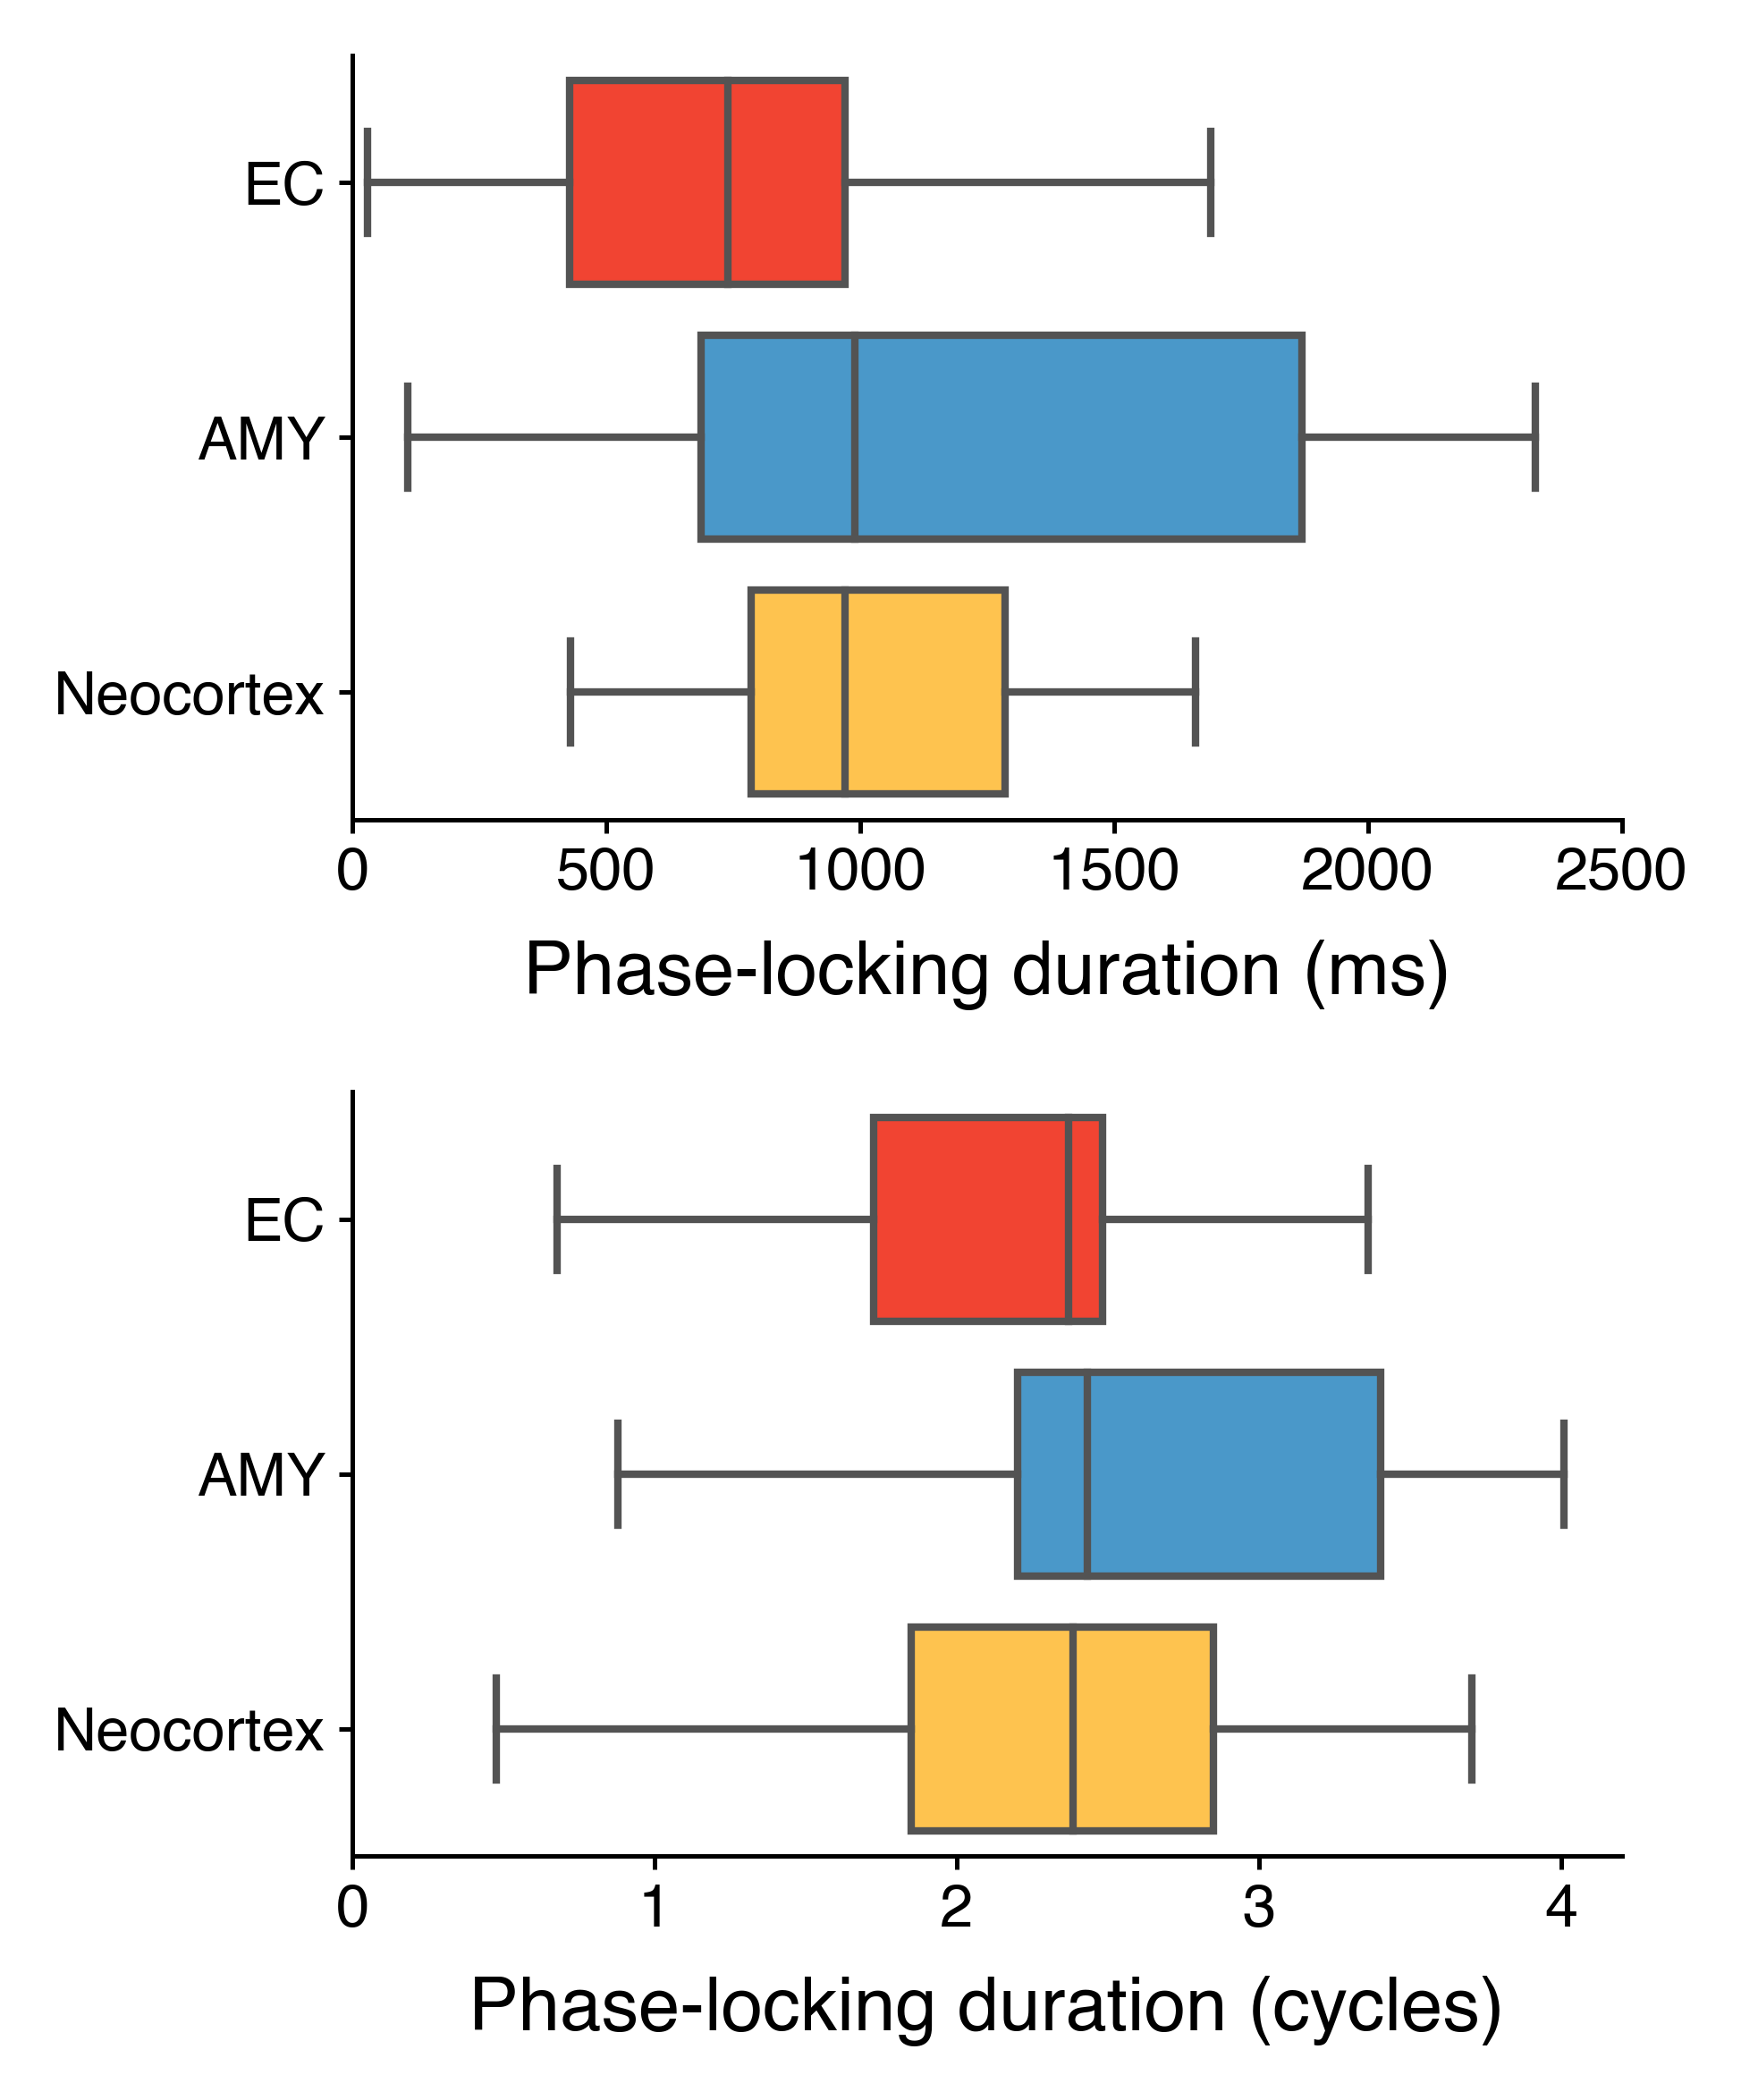

In [1046]:
mpl.rcParams['xtick.major.width'] = 0.6
mpl.rcParams['ytick.major.width'] = 0.6
mpl.rcParams['axes.linewidth'] = 0.6
mpl.rcParams['xtick.major.size'] = 1.8
mpl.rcParams['ytick.major.size'] = 1.8
mpl.rcParams['xtick.major.pad'] = 1.8
mpl.rcParams['ytick.major.pad'] = 1.8

fig, ax = plt.subplots(2, 1, figsize=(3.34646, 4.01575), dpi=600)
ax = np.ravel(ax)

tickfontsize=8
labelfontsize=10

rois = od([('ec', 'EC'),
           ('amy', 'AMY'), 
           ('ctx', 'Neocortex')])

df = pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)").copy()
df['unit_roi3'] = df['unit_roi3'].astype('category').cat.reorder_categories(rois.keys(), ordered=True)
df['pl_time_shift'] = -df['pl_time_shift']

i = 0
sns.boxplot(y='unit_roi3', x='pl_duration', data=df,
            showfliers=False, notch=False,
            saturation=100, palette=[colors[1], colors[0], colors[6]],
            linewidth=1, ax=ax[i])
ax[i].set_xlim([0, 2500])
ax[i].set_xticks(np.arange(0, 2501, 500, dtype=int))
ax[i].set_xticklabels(np.arange(0, 2501, 500, dtype=int), fontsize=tickfontsize)
ax[i].tick_params(labelsize=tickfontsize)
ax[i].set_xlabel('Phase-locking duration (ms)', fontsize=labelfontsize, labelpad=5)
ax[i].set_yticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylabel('', fontsize=labelfontsize, labelpad=8)

# ------------------------------------------------------

i = 1
sns.boxplot(y='unit_roi3', x='pl_cycles', data=df,
            showfliers=False, notch=False,
            saturation=100, palette=[colors[1], colors[0], colors[6]],
            linewidth=1, ax=ax[i])
ax[i].set_xlim([0, 4.2])
ax[i].set_xticks(np.arange(0, 4.1, 1, dtype=int))
ax[i].set_xticklabels(np.arange(0, 4.1, 1, dtype=int), fontsize=tickfontsize)
ax[i].tick_params(labelsize=tickfontsize)
ax[i].set_xlabel('Phase-locking duration (cycles)', fontsize=labelfontsize, labelpad=5)
ax[i].set_yticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylabel('', fontsize=labelfontsize, labelpad=8)

# custom_lines = [Line2D([0], [0], marker='s', color='w', label='Ipsilateral', markerfacecolor=colors[1], markersize=tickfontsize),
#                 Line2D([0], [0], marker='s', color='w', label='Contralateral', markerfacecolor=colors[0], markersize=tickfontsize)]
# legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['xtick.major.size'] = 3.5
mpl.rcParams['ytick.major.size'] = 3.5
mpl.rcParams['xtick.major.pad'] = 3.5
mpl.rcParams['ytick.major.pad'] = 3.5

if False:
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/phase_locking_by_time_2.pdf', 
                format='pdf', bbox_inches='tight')

In [845]:
frs = np.array(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby('subj_sess_unit')['unit_fr'].apply(lambda x: np.median(x)).tolist())

(1233,)

In [853]:
np.median(frs), np.percentile(frs, 25), np.percentile(frs, 75)

(2.3338735103607178, 0.8900693655014038, 5.590949058532715)

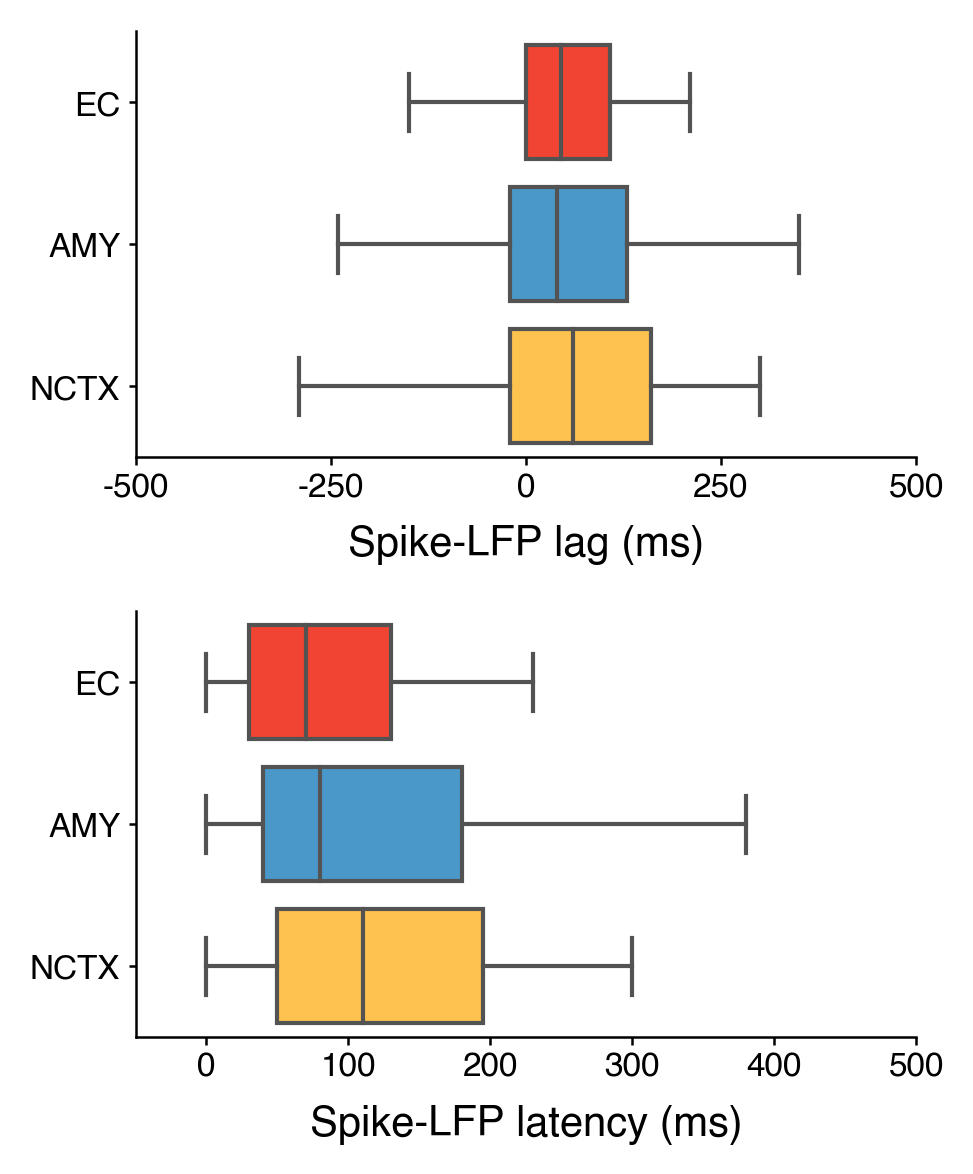

In [898]:
mpl.rcParams['xtick.major.width'] = 0.6
mpl.rcParams['ytick.major.width'] = 0.6
mpl.rcParams['axes.linewidth'] = 0.6
mpl.rcParams['xtick.major.size'] = 1.8
mpl.rcParams['ytick.major.size'] = 1.8
mpl.rcParams['xtick.major.pad'] = 1.8
mpl.rcParams['ytick.major.pad'] = 1.8

fig, ax = plt.subplots(2, 1, figsize=(3.34646, 4.01575), dpi=300)
ax = np.ravel(ax)

tickfontsize=8
labelfontsize=10

rois = od([('ec', 'EC'),
           ('amy', 'AMY'), 
           ('ctx', 'NCTX')])

df = pl_df.query("(sig_z_fdr==True) & (edge=='ctx-hpc') & (same_hem==True)").copy()
df['unit_roi3'] = df['unit_roi3'].astype('category').cat.reorder_categories(rois.keys(), ordered=True)
df['pl_time_shift'] = -df['pl_time_shift']

i = 0
sns.boxplot(y='unit_roi3', x='pl_time_shift', data=df,
            showfliers=False, notch=False,
            saturation=100, palette=[colors[1], colors[0], colors[6]],
            linewidth=1, ax=ax[i])
ax[i].set_xlim([-500, 500])
ax[i].set_xticks(np.arange(-500, 501, 250, dtype=int))
ax[i].set_xticklabels(np.arange(-500, 501, 250, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Spike-LFP lag (ms)', fontsize=labelfontsize, labelpad=5)
ax[i].set_yticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylabel('', fontsize=labelfontsize, labelpad=8)

# ------------------------------------------------------

i = 1
sns.boxplot(y='unit_roi3', x='pl_latency', data=df,
            showfliers=False, notch=False,
            saturation=100, palette=[colors[1], colors[0], colors[6]],
            linewidth=1, ax=ax[i])
ax[i].set_xlim([-50, 500])
ax[i].set_xticks(np.arange(0, 501, 100, dtype=int))
ax[i].set_xticklabels(np.arange(0, 501, 100, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Spike-LFP latency (ms)', fontsize=labelfontsize, labelpad=5)
ax[i].set_yticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylabel('', fontsize=labelfontsize, labelpad=8)

# custom_lines = [Line2D([0], [0], marker='s', color='w', label='Ipsilateral', markerfacecolor=colors[1], markersize=tickfontsize),
#                 Line2D([0], [0], marker='s', color='w', label='Contralateral', markerfacecolor=colors[0], markersize=tickfontsize)]
# legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['xtick.major.size'] = 3.5
mpl.rcParams['ytick.major.size'] = 3.5
mpl.rcParams['xtick.major.pad'] = 3.5
mpl.rcParams['ytick.major.pad'] = 3.5

if False:
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/phase_locking_by_time_2.pdf', 
                format='pdf', bbox_inches='tight')

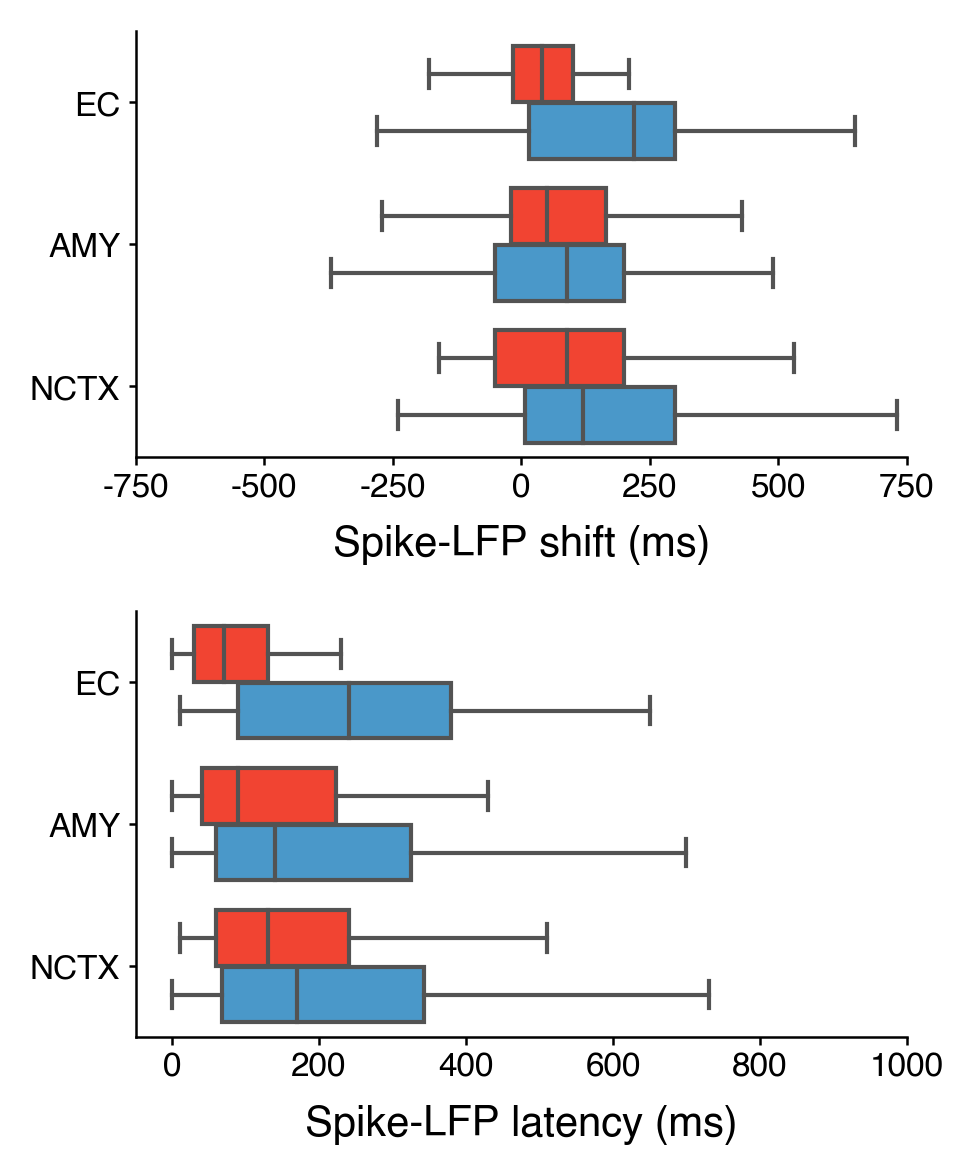

In [644]:
mpl.rcParams['xtick.major.width'] = 0.6
mpl.rcParams['ytick.major.width'] = 0.6
mpl.rcParams['axes.linewidth'] = 0.6
mpl.rcParams['xtick.major.size'] = 1.8
mpl.rcParams['ytick.major.size'] = 1.8
mpl.rcParams['xtick.major.pad'] = 1.8
mpl.rcParams['ytick.major.pad'] = 1.8

fig, ax = plt.subplots(2, 1, figsize=(3.34646, 4.01575), dpi=300)
ax = np.ravel(ax)

tickfontsize=8
labelfontsize=10

rois = od([('ec', 'EC'),
           ('amy', 'AMY'), 
           ('ctx', 'NCTX')])

df = hpc_pl_df.copy()
df['unit_roi3'] = df.unit_roi3.astype('category').cat.reorder_categories(rois.keys(), ordered=True)
df['hem'] = df.same_hem.apply(lambda x: 'ipsi' if x else 'contra')
df['hem'] = df.hem.astype('category').cat.reorder_categories(['ipsi', 'contra'], ordered=True)
df['tl_locked_time_z'] = -df['tl_locked_time_z']

i = 0
sns.boxplot(y='unit_roi3', x='tl_locked_time_z', hue='hem', data=df,
            showfliers=False, notch=False,
            saturation=100, palette=[colors[1], colors[0]],
            linewidth=1, ax=ax[i])
ax[i].set_xlim([-750, 750])
ax[i].set_xticks(np.arange(-750, 751, 250, dtype=int))
ax[i].set_xticklabels(np.arange(-750, 751, 250, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Spike-LFP shift (ms)', fontsize=labelfontsize, labelpad=5)
ax[i].set_yticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylabel('', fontsize=labelfontsize, labelpad=8)
ax[i].get_legend().remove()

# ------------------------------------------------------

i = 1
sns.boxplot(x='tl_locked_time_z_abs', y='unit_roi3', hue='hem', data=df,
            showfliers=False, notch=False,
            saturation=100, palette=[colors[1], colors[0]],
            linewidth=1, ax=ax[i])
ax[i].set_xlim([-50, 1000])
ax[i].set_xticks(np.arange(0, 1001, 200, dtype=int))
ax[i].set_xticklabels(np.arange(0, 1001, 200, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Spike-LFP latency (ms)', fontsize=labelfontsize, labelpad=5)
ax[i].set_yticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylabel('', fontsize=labelfontsize, labelpad=8)
ax[i].get_legend().remove()

# custom_lines = [Line2D([0], [0], marker='s', color='w', label='Ipsilateral', markerfacecolor=colors[1], markersize=tickfontsize),
#                 Line2D([0], [0], marker='s', color='w', label='Contralateral', markerfacecolor=colors[0], markersize=tickfontsize)]
# legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['xtick.major.size'] = 3.5
mpl.rcParams['ytick.major.size'] = 3.5
mpl.rcParams['xtick.major.pad'] = 3.5
mpl.rcParams['ytick.major.pad'] = 3.5

if False:
    fig.savefig('/home1/dscho/projects/unit_activity_and_hpc_theta/figs/phase_locking_by_time_2.pdf', 
                format='pdf', bbox_inches='tight')

In [ ]:
# RUN ANOVA FIRST
# stats.ttest_ind(hpc_pl_df.query("(mono_roi==['ec', 'amy'])").tl_locked_time_z_abs,
#                 hpc_pl_df.query("(mono_roi==['ipsi', 'contra'])").tl_locked_time_z_abs)
from statsmodels.formula.api import ols

mod = ols('tl_locked_time_z_abs ~ mono_roi2', data=hpc_pl_df).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

In [457]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

multi_comp = MultiComparison(hpc_pl_df['tl_locked_time_z_abs'], hpc_pl_df['mono_roi'])
print(multi_comp.tukeyhsd(0.001).summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.00
group1 group2 meandiff   lower    upper   reject
------------------------------------------------
 amy     ec   -86.8514 -248.5067  74.804  False 
 amy   other  130.9461   1.3429  260.5494  True 
  ec   other  217.7975   68.225   367.37   True 
------------------------------------------------


## Phase-locking to HPC vs. local

In [918]:
sess_durations = np.array(subj_df.query("subj_sess=={}".format(list(pl_df.query("(edge=='ctx-hpc')")['subj_sess'].unique())))
                          ['sess_duration'].unique())

print('{} sessions from {} subjects lasting {:.1f} ± {:.1f} min'
      .format(len(pl_df.query("(edge=='ctx-hpc')")['subj_sess'].unique()), 
              len(pl_df.query("(edge=='ctx-hpc')")['subj'].unique()), 
              np.mean(sess_durations)/60, np.std(sess_durations)/60))

43 sessions from 18 subjects lasting 25.4 ± 6.9 min


In [1610]:
# For all cortical neurons that are phase-locked to HPC LFP,
# get the preferred phase and phase offset for each spike when
# referenced to the local LFP at the HPC LFP preferred frequency.
# This info is appended to the unit-to-region phase-locking Series 
# and saved to /.../unit_to_region_for_power/sig
# and /.../unit_to_region_for_power/nsig (for insignificant comparisons)
n_bootstraps = 1000
t0 = 200

hpc_pl_df = pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (same_hem==True)").reset_index(drop=True).copy()
local_mrl_zs = []
local_pvals = []
for index, hpc_row in hpc_pl_df.iterrows():
    subj_sess = hpc_row.subj_sess
    unit = hpc_row.unit
    lfp_roi = hpc_row.lfp_hemroi
    hpc_locked_iFreq = hpc_row.locked_freq_ind_z
#     hpc_locked_iFreq = hpc_row.pl_freq
    
    local_row = pl_df.query("(subj_sess=='{}') & (unit=={}) & (same_hemroi==True)".format(subj_sess, unit)).iloc[0]
    local_mrl_z = local_row['tl_mrls_z'][hpc_locked_iFreq, t0]
    bs_ind = np.sum(local_row['bs_mrls_z'][hpc_locked_iFreq, :] >= local_mrl_z)
    pval = (1 + bs_ind) / (1 + n_bootstraps)
    local_mrl_zs.append(local_mrl_z)
    local_pvals.append(pval)

local_sig_fdr = sm.stats.multipletests(local_pvals, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
hpc_pl_df['local_mrl_z'] = local_mrl_zs
hpc_pl_df['local_sig_fdr'] = local_sig_fdr
hpc_pl_df['hpc_gt_loc'] = hpc_pl_df.apply(lambda x: x['locked_mrl_z'] > x['local_mrl_z'], axis=1)
hpc_pl_df['hpc_min_loc_pl_strength'] = hpc_pl_df.apply(lambda x: x['locked_mrl_z'] - x['local_mrl_z'], axis=1)

In [1612]:
arr = np.array(hpc_pl_df.query("(hpc_gt_loc==True)")['hpc_min_loc_pl_strength'].tolist())
print('{} neurons are more strongly phase-locked to the HPC than the local LFP at their peak frequency'.format(len(hpc_pl_df.query("(hpc_gt_loc==True)"))))
print('HPC - local strength: {:.1f} +/- {:.1f} (M +/- SD)'.format(np.mean(arr), np.std(arr)))

248 neurons are more strongly phase-locked to the HPC than the local LFP at their peak frequency
HPC - local strength: 4.6 +/- 3.5 (M +/- SD)


In [1613]:
hpc_vs_loc = hpc_pl_df.groupby('subj_sess_unit').agg({'unit': len, 'hpc_gt_loc': np.sum, 'local_sig_fdr': np.sum}).reset_index()
hpc_vs_loc['hpc_not_loc_sig'] = hpc_vs_loc.apply(lambda x: x['local_sig_fdr'] < x['unit'], axis=1)
arr = np.array(hpc_pl_df.loc[list(hpc_vs_loc.query("(hpc_gt_loc==True) & (hpc_not_loc_sig==False)").index)]
               .apply(lambda x: x['locked_mrl_z'] - x['local_mrl_z'], axis=1).tolist())
print('{:.1f} +/- {:.1f}'.format(np.mean(arr), np.std(arr)), len(arr))

1.2 +/- 6.9 169


In [1615]:
print('{}/{} ({:.1f}%) of neurons are phase-locked to the HPC at a frequency that local phase-locking is not significant'
      .format(np.sum(hpc_vs_loc['hpc_not_loc_sig']), len(hpc_vs_loc), 100 * np.sum(hpc_vs_loc['hpc_not_loc_sig']) / len(hpc_vs_loc)))

79/362 (21.8%) of neurons are phase-locked to the HPC at a frequency that local phase-locking is not significant


In [1616]:
n = len(hpc_vs_loc.query("(hpc_gt_loc==True) & (hpc_not_loc_sig==False)"))
print('{}/{} ({:.1f}%) of neurons are phase-locked to both the HPC and local LFP at the HPC max frequency, but HPC phase-locking is stronger'
      .format(n, len(hpc_vs_loc), 100 * n/len(hpc_vs_loc)))

169/362 (46.7%) of neurons are phase-locked to both the HPC and local LFP at the HPC max frequency, but HPC phase-locking is stronger


## Other

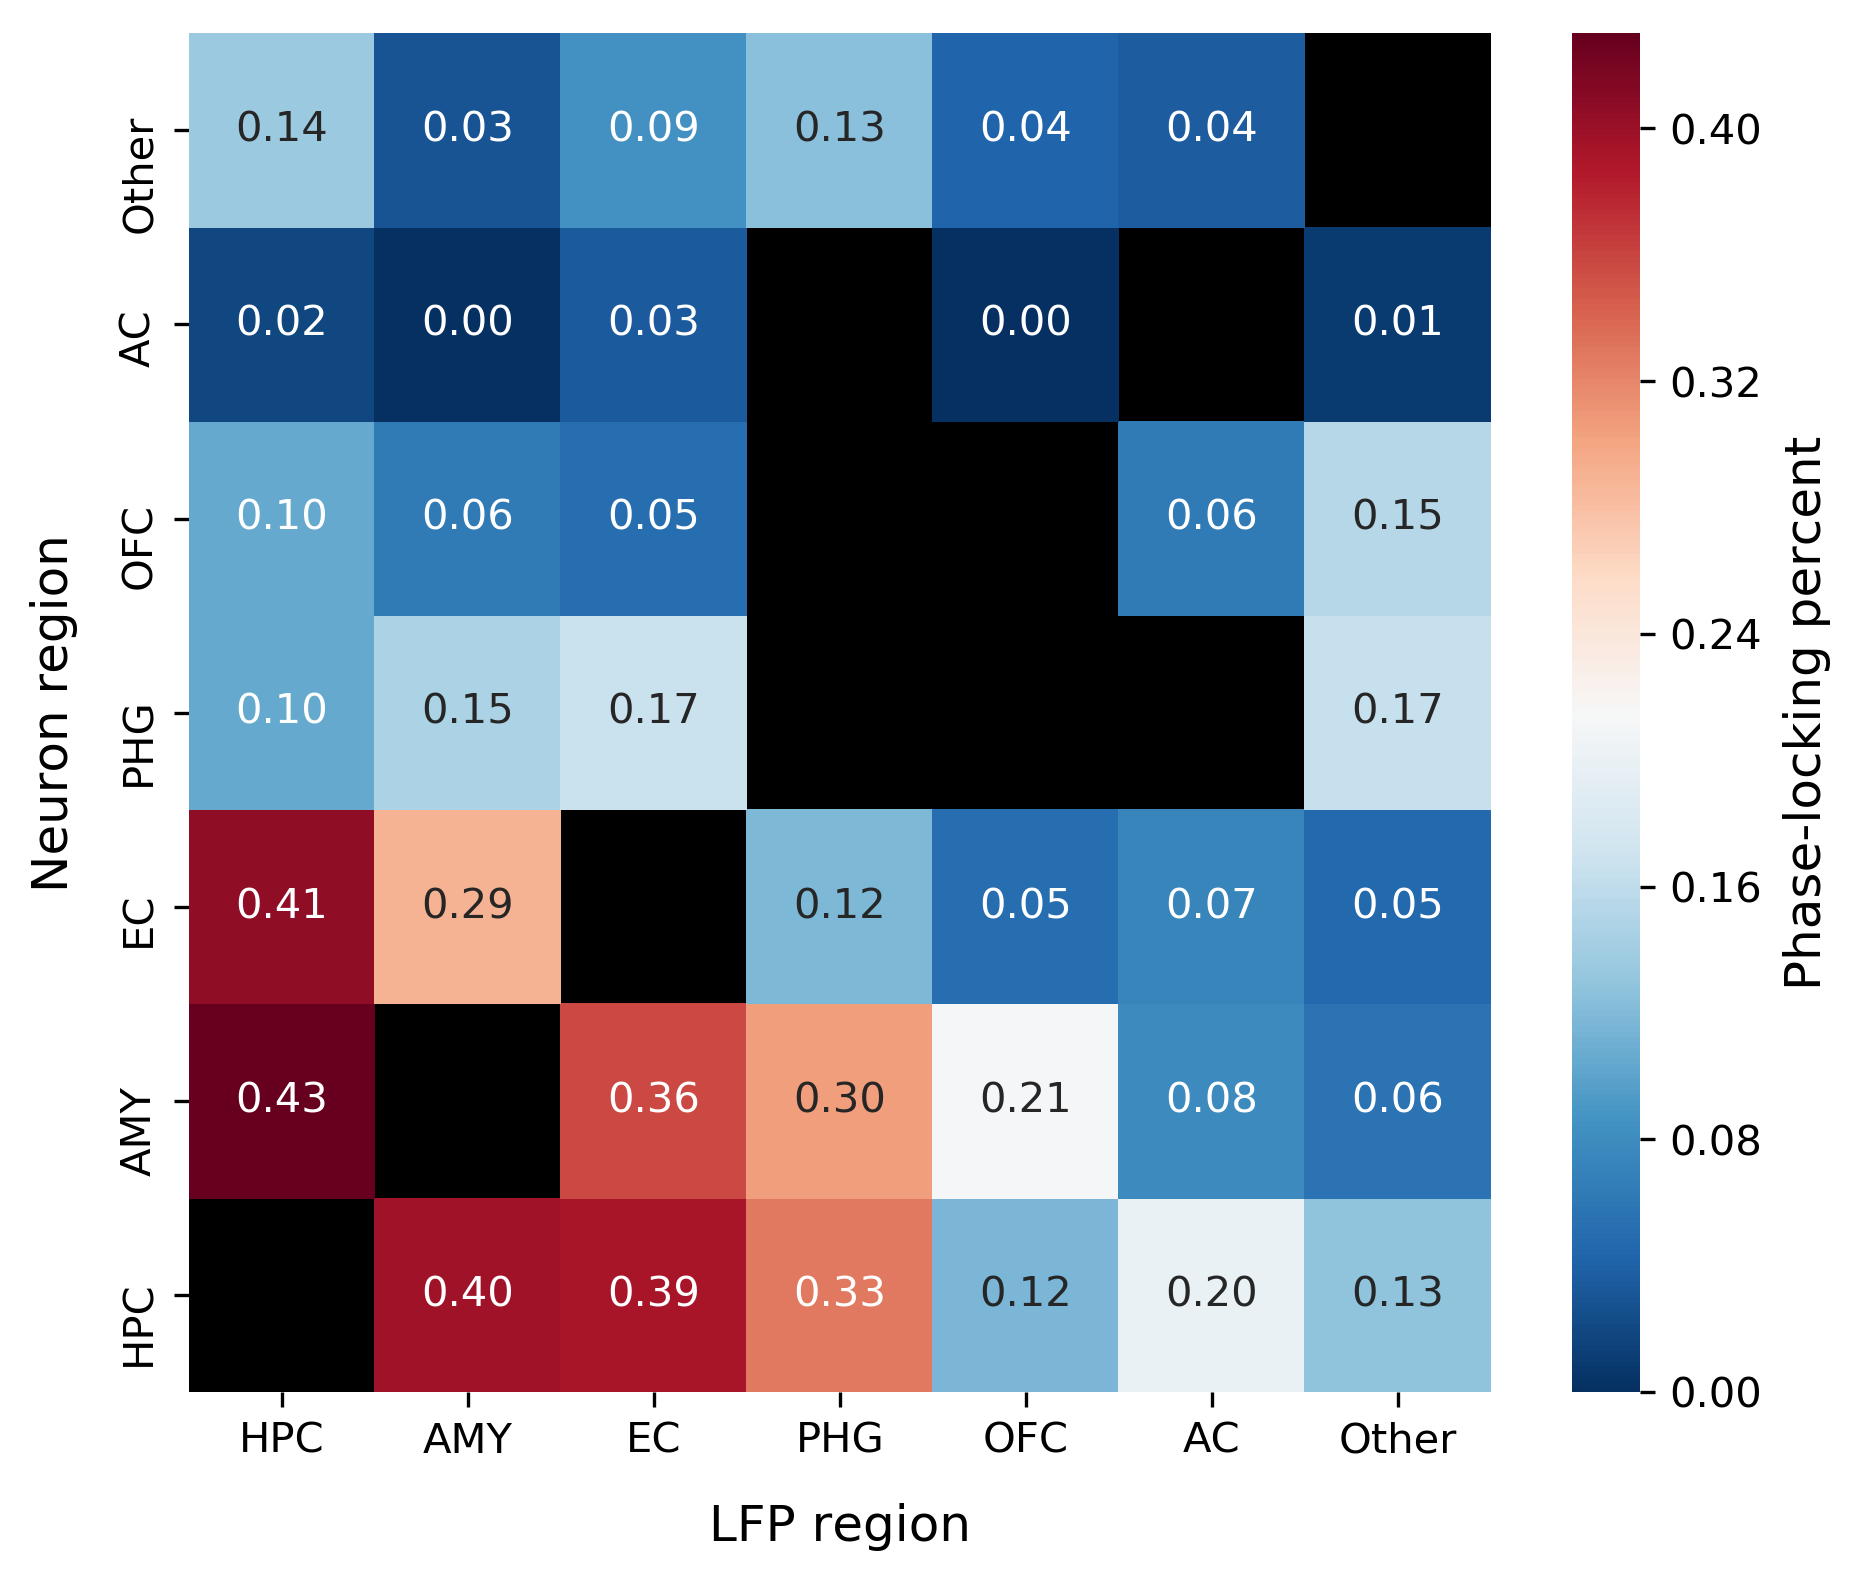

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=300)
ax = np.ravel(ax)

df = (pl_df
      #.query("(edge=={})".format(['ctx-ctx', 'ctx-hpc', 'hpc-ctx', 'hpc-hpc']))
      .query("(unit_roi2 != lfp_roi2) & (same_hem==True)")
      .groupby(['unit_roi2', 'lfp_roi2'])
      .agg({'unit': len, 'sig_z_fdr2': np.mean}).reset_index())
df.loc[df.unit<50, 'sig_z_fdr2'] = np.nan
df.loc[df.unit_roi2=='ctx', 'unit_roi2'] = 'Other'
df.unit_roi2 = df.unit_roi2.astype('category').cat.reorder_categories(['hpc', 'amy', 'ec', 'phg', 'ofc', 'ac', 'Other'])
df.unit_roi2 = df.unit_roi2.apply(lambda x: x.upper() if x != 'Other' else x)
df.loc[df.lfp_roi2=='ctx', 'lfp_roi2'] = 'Other'
df.lfp_roi2 = df.lfp_roi2.astype('category').cat.reorder_categories(['hpc', 'amy', 'ec', 'phg', 'ofc', 'ac', 'Other'])
df.lfp_roi2 = df.lfp_roi2.apply(lambda x: x.upper() if x != 'Other' else x)

i = 0
dat = df.set_index(['unit_roi2', 'lfp_roi2'])[['sig_z_fdr2']].unstack()
vmax = np.max(dat.max(skipna=True))
ax[i] = sns.heatmap(np.array(dat), vmin=0, vmax=vmax, annot=True, fmt='.2f', cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i])
ax[i].set_facecolor('k')
ax[i].set_xticklabels(dat.index.categories, fontsize=tickfs)
ax[i].set_yticklabels(dat.index.categories, fontsize=tickfs)
ax[i].set_xlabel('LFP region', fontsize=labfs+2, labelpad=10)
ax[i].set_ylabel('Neuron region', fontsize=labfs+2, labelpad=10)
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfs)
cbar.ax.ticklabel_format()
cbar.set_label('Phase-locking percent', fontsize=labfs+2)
# ax[i+icpt].set_yticks(np.arange(len(freqs))[::2] + 0.5)
# ax[i+icpt].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfs)
ax[i].invert_yaxis()

In [127]:
unit_to_lfp = []
lfp_to_unit = []
for roi1, roi2 in itertools.combinations(df.unit_roi2.unique(), 2):
    unit_to_lfp.append(df.query("(unit_roi2=='{}') & (lfp_roi2=='{}')".format(roi1, roi2)).sig_z_fdr2.iat[0])
    lfp_to_unit.append(df.query("(unit_roi2=='{}') & (lfp_roi2=='{}')".format(roi2, roi1)).sig_z_fdr2.iat[0])
unit_to_lfp = np.array(unit_to_lfp)
lfp_to_unit = np.array(lfp_to_unit)
ma = np.invert(np.isnan(unit_to_lfp) | np.isnan(lfp_to_unit))
stats.pearsonr(unit_to_lfp[ma], lfp_to_unit[ma])

(0.7519422225677926, 0.00020490879875652193)

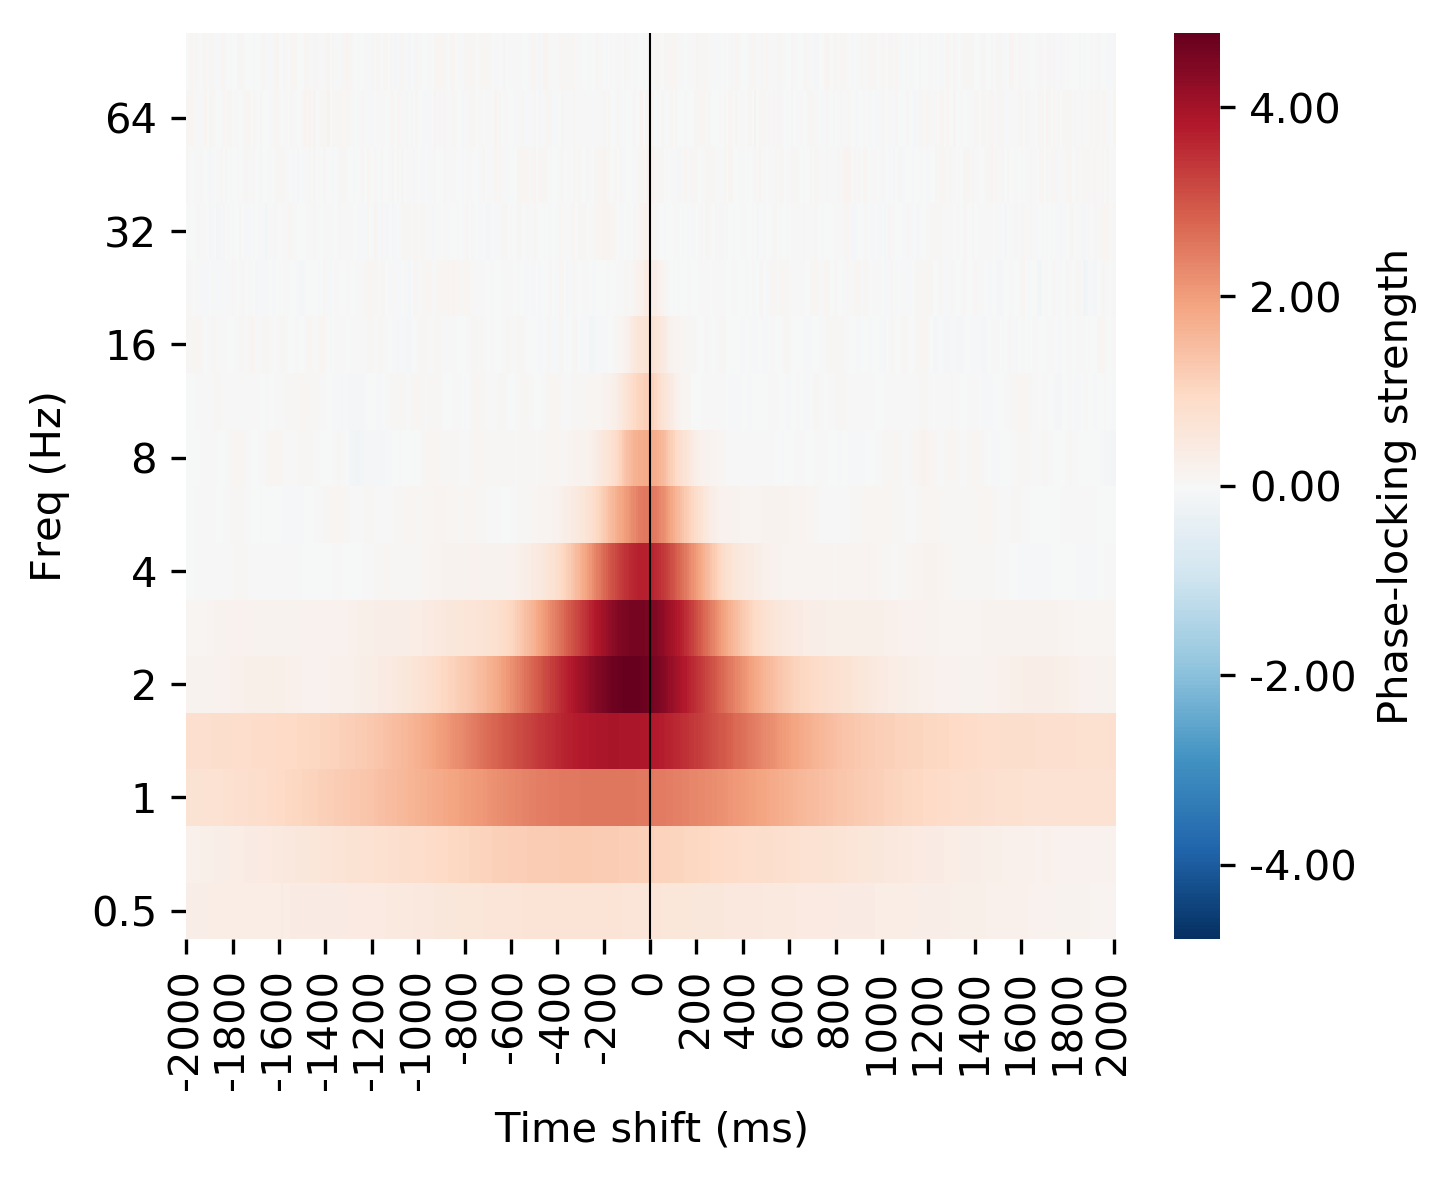

In [13]:
# Get the average time-lag Z-MRL matrix.
mean_tl_mrls_z = np.mean(pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)").tl_mrls_z.tolist(), axis=0) # freq x time_shift
dat = mean_tl_mrls_z

fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=300)
ax = np.ravel(ax)

i = 0
vmax = np.max(np.abs(dat))
vmin = -vmax
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='RdBu_r', cbar_kws={'format': '%.2f'}, ax=ax[i])
ax[i].axvline(x=200, color='k', linewidth=0.5, alpha=1)
ax[i].set_xticks(np.arange(0, 401)[::20])
ax[i].set_xticklabels(np.linspace(-2000, 2000, num=401)[::20].astype(int), fontsize=tickfs)
ax[i].set_yticks(np.arange(len(freqs))[::2] + 0.5)
ax[i].set_yticklabels([0.5] + list(np.round(freqs[::2]).astype(int)[1:]), rotation=0, fontsize=tickfs)
ax[i].invert_yaxis()
ax[i].set_xlabel('Time shift (ms)', fontsize=labfs)
ax[i].set_ylabel('Freq (Hz)', fontsize=labfs)
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfs)
cbar.ax.ticklabel_format()
cbar.set_label('Phase-locking strength', fontsize=labfs)

In [ ]:
# What plots should we make for each ctx->HPC connection?
# info: subj_sess, unit, unit ROI, LFP ROI, firing rate, no. spikes, locked frequency, phase-locking strength, time shift
# 1. spike waveforms
# 2. example LFPs for each channel (3 each of: close to mean phase, far from mean phase)
# 3. spike-triggered average LFP for each channel
# 4. spike-triggered average power at each frequency, averaged across channels
# 5. time-shifted phase-locking strength at each frequency (for the HPC LFP and for all other inter-electrode 
#    ROIs for the unit, so we can see if any artifacts emerge across electrode bundles)

In [414]:
fname = os.path.join('/scratch/dscho/unit_activity_and_hpc_theta', 'figs', 'pubmed_chart_functional_connectivity_and_fmri.csv')
pubmed = pd.read_csv(fname, header=1)
pubmed = pubmed.loc[1:21]

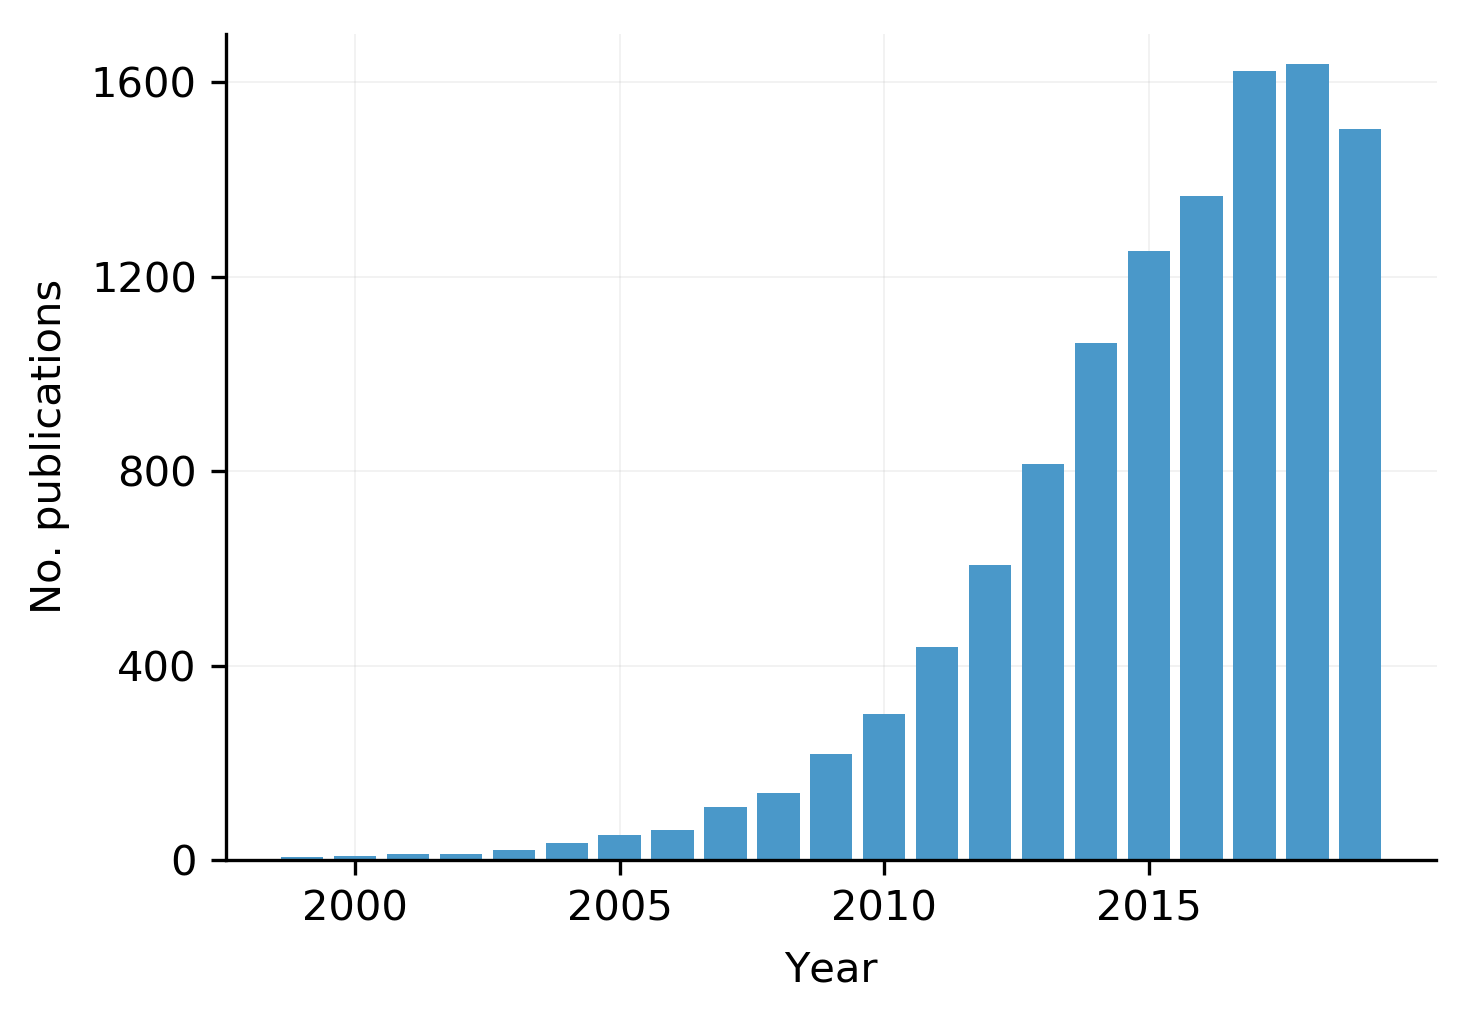

In [434]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), dpi=300)
ax = np.ravel(ax)

i = 0
ax[0].bar(pubmed['year'], pubmed['count'], width=0.8, color=colors[0])
ax[i].set_ylim([0, 1700])
ax[i].set_yticks(np.arange(0, 1700, 400, dtype=int))
ax[i].set_yticklabels(np.arange(0, 1700, 400, dtype=int), fontsize=tickfontsize)
ax[i].set_xticks(np.arange(2000, 2020, 5, dtype=int))
ax[i].set_xticklabels(np.arange(2000, 2020, 5, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Year', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('No. publications', fontsize=labelfontsize, labelpad=5)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/pubmed_functional_connectivity_by_year.png', 
                format='png', dpi=300, bbox_inches='tight')